# Imports

In [1]:
import os
import sys; sys.path.append('../')
import yaml
import time
import math
import json
import pickle
import datetime
import warnings
import traceback

import wandb
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt; plt.style.use('seaborn')
from sklearn import metrics
from sklearn.calibration import CalibrationDisplay


import torch
import torchmetrics
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


import utils
import utils.nn

warnings.filterwarnings('ignore')

# Load and Prepare

In [2]:
config_base = utils.base.ConfigBase()

In [3]:
with open('../scarpe/output/leagues.json', 'r', encoding='utf-8') as f:
    leagues = json.load(f)
    
with open('../scarpe/output/teams.json', 'r', encoding='utf-8') as f:
    teams = json.load(f)
    
with open('../scarpe/output/prize_pools.json', 'r', encoding='utf-8') as f:
    prize_pools = json.load(f)

In [4]:
odds = pd.read_csv("../parse/output/prematch_odds.csv")
odds = odds.sort_values(by='match_id')
odds = odds.rename({'radiant_win':'y_true'}, axis=1)
odds = odds.drop_duplicates('match_id')
odds = odds.reset_index(drop=True)

odds['y_true'] = odds['y_true'].astype('int64')

M = (1/odds['r_odd'] + 1/odds['d_odd']) - 1

odds['r_pred'] = (1-M)/odds['r_odd']
odds['d_pred'] = (1-M)/odds['d_odd']

In [5]:
def generate_sample_weight():
    import tensorflow as tf
    # ------------------------------------------------------------- #
    FEATURES = ['kills', 'deaths', 'assists', 'last_hits', 'denies_10', 'last_hits_10', 'denies_5', 'stuns', 'heal', 'obs_placed', 'sen_placed', 'camps_stacked', 'creeps_stacked']

    columns_r = [f"r_{f}" for f in FEATURES]
    columns_d = [f"d_{f}" for f in FEATURES]

    stats_r = train_df[columns_r].values.astype('float32')
    stats_d = train_df[columns_d].values.astype('float32')

    win_arr = train_df['radiant_win'].values
    win_arr = np.concatenate([win_arr[:, None], ~win_arr[:, None]], axis=-1).astype('float32')
    
    # ------------------------------------------------------------- #
    stats_r_input = tf.keras.Input(stats_r.shape[1], name='stats_r')
    stats_d_input = tf.keras.Input(stats_r.shape[1], name='stats_d')

    compare_fnn = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='gelu', activity_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='gelu', activity_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.2),
    ])

    r_emb = compare_fnn(tf.concat([stats_r_input, stats_d_input], axis=-1))
    d_emb = compare_fnn(tf.concat([stats_d_input, stats_r_input], axis=-1))

    r_out = tf.keras.layers.Dense(2, activation='softmax', name='r_out')
    d_out = tf.keras.layers.Dense(2, activation='softmax', name='d_out')
    
    model = tf.keras.Model(inputs=[stats_r_input, stats_d_input], outputs=[r_out(r_emb), d_out(d_emb)])
    
    # ------------------------------------------------------------- #
    optimizer = tf.keras.optimizers.SGD(1e-2, clipvalue=.5, momentum=0.9, nesterov=True)
    model.compile(
        optimizer=optimizer,
        loss={'r_out': tf.keras.losses.CategoricalCrossentropy(), 
              'd_out': tf.keras.losses.CategoricalCrossentropy()},
        metrics=['accuracy', tf.keras.metrics.AUC(num_thresholds=60, name='auc')]
    )

    with tf.device('/gpu:0'):
        board_name = datetime.datetime.now().strftime("%Y.%m.%d - %H-%M")
        tb = tf.keras.callbacks.TensorBoard(log_dir=f'logs/fit/prematch/Match reliability {board_name}')
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        model.fit(
            [stats_r, stats_d], [win_arr, 1-win_arr],
            validation_split=0.2,
            callbacks=[es, tb],
            verbose=0,
            epochs=10**8,
            batch_size=1024,
            shuffle=True,
        )
        
    pred = model.predict([stats_r, stats_d])
    preds = (pred[0][:, 0] + pred[1][:, 1])/2
    
    weight = 1 - abs(train_df['radiant_win'].values - preds)
    # weight = abs((preds-0.5) * 2)
    train_df['sample_weight'] = weight

In [6]:
# train_df['part'] = 'train'
# if v_size > 0: val_df['part'] = 'val'
# if t_size > 0: test_df['part'] = 'test'

# for eval_ in [True, ]:
#     corpus = train_df.reset_index(drop=True)
#     train_dataset = utils.nn.datasets.LeagueDataset(
#         corpus=corpus, 
#         evaluate_tokenize=eval_,
#         indexes=corpus.index[(corpus['part'] == 'train')], 
#         y_output='crossentropy',
#     ).build()
#     with open(f'output/train_cache{"_evaluated" if eval_ else ""}.pkl', 'wb') as p:
#         pickle.dump(train_dataset.cache, p)
        
#     if v_size > 0:
#         corpus = pd.concat([corpus, val_df]).reset_index(drop=True)
#         val_dataset = utils.nn.datasets.LeagueDataset(
#             corpus=corpus, 
#             evaluate_tokenize=eval_,
#             indexes=corpus.index[(corpus['part'] == 'val')], 
#             y_output='crossentropy',
#         ).build()
#         with open(f'output/val_cache{"_evaluated" if eval_ else ""}.pkl', 'wb') as p:
#             pickle.dump(val_dataset.cache, p)
        
#     if t_size > 0:
#         corpus = pd.concat([corpus, test_df]).reset_index(drop=True)
#         test_dataset = utils.nn.datasets.LeagueDataset(
#             corpus=corpus, 
#             evaluate_tokenize=eval_,
#             indexes=corpus.index[(corpus['part'] == 'test')], 
#             y_output='crossentropy',
#         ).build()
#         with open(f'output/test_cache{"_evaluated" if eval_ else ""}.pkl', 'wb') as p:
#             pickle.dump(test_dataset.cache, p)

In [7]:
with open('../configs/train.yaml', 'r') as stream:
    config = yaml.safe_load(stream)['league']
    
v_size = config['split']['val']
t_size = config['split']['test']

train_df = pd.read_csv(f'../parse/output/league/train_df.csv')
# generate_sample_weight()
# train_df.to_csv(f'../parse/output/league/train_df.csv', index=False)

a1, a2 = 0.5, 1
b1, b2 = 0.00, 1
a, b = 0.25, 1
w = np.arange(a1, a2, (a2-a1)/len(train_df))
train_df['sample_weight'] = 1
train_df['sample_weight'] *= w

max_ = train_df['league_prize_pool'].max()
min_ = train_df['league_prize_pool'].min()
league_prize_pool = b1 + (train_df['league_prize_pool'] - min_)*(b2-b1)/(max_ - min_)
train_df['sample_weight'] += league_prize_pool

max_ = train_df['sample_weight'].max()
min_ = train_df['sample_weight'].min()
train_df['sample_weight'] = a + (train_df['sample_weight'] - min_)*(b-a)/(max_ - min_)

print(len(train_df))

if v_size > 0:
    val_df = pd.read_csv(f'../parse/output/league/val_df.csv')
    val_df['sample_weight'] = 1
    print(len(val_df))
if t_size > 0:
    test_df = pd.read_csv(f'../parse/output/league/test_df.csv')
    test_df['sample_weight'] = 1
    print(len(test_df))
    
tokenizer = utils.tokenizer.Tokenizer(path="../parse/output/tokenizer_league.pkl")

12257
500
500


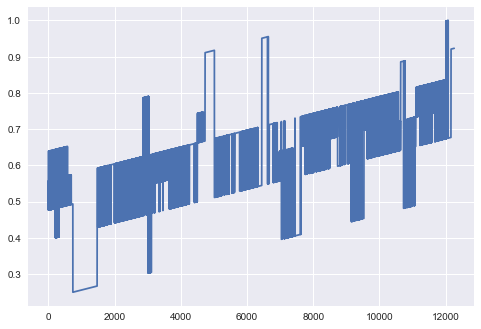

In [8]:
plt.plot(train_df['sample_weight'])

In [9]:
if v_size > 0:
    val_dataset = utils.nn.datasets.LeagueDataset(
        corpus=None, 
        indexes=None, 
        y_output='crossentropy')
    val_dataset.cache = pickle.load(open('output/val_cache_evaluated.pkl', 'rb'))
    val_dataset.build()
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, num_workers=0)

if t_size > 0:
    test_dataset = utils.nn.datasets.LeagueDataset(
        corpus=None, 
        indexes=None, 
        y_output='crossentropy')
    test_dataset.cache = pickle.load(open('output/test_cache_evaluated.pkl', 'rb'))
    test_dataset.build()
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)

# Helper Functions

In [10]:
def predict(mode, m):
    assert mode in ['train', 'val', 'test']
    
    preds = []
    models = []
    results = []
    for name in models_names:
        checkpoint = torch.load(f'output/models_w/prematch/{name} {m}.torch')
        
        # Load configs
        for config in checkpoint['configs']:
            utils.base.ConfigBase._configs[config] = checkpoint['configs'][config]
        
        # Build model from configs
        model = utils.nn.PrematchModel(**checkpoint['kwargs']).eval()
        model.to(device)
        
        # Load weights
        try:
            model.load_state_dict(checkpoint['model'])
        except Exception as e:
            if 'missing' in str(e).lower():
                raise Exception(e)
            else:
                print("Unexcepted w., load without strict")
                model.load_state_dict(checkpoint['model'], strict=False)
                    
        if checkpoint['ensemble_boosting']:
            models.append(model)
            
        else:
            config = checkpoint['configs']['train']['league']
            trainer = utils.nn.trainers.PrematchTrainer(
                model=model, 
                loss_fn=torch.nn.CrossEntropyLoss(reduction='none', label_smoothing=config['label_smoothing']),
                sheduler=None, optimizer=None, device=device, **config['trainer'])
            if mode == 'train':
                match_ids, pred, true = trainer.predict(train_loader)
            elif mode == 'val':
                match_ids, pred, true = trainer.predict(val_loader)
            elif mode == 'test':
                match_ids, pred, true = trainer.predict(test_loader)
            results.append(trainer.compute_metrics(pred, true))
            preds.append(pred)
            
        # Reset configs
        utils.base.ConfigBase._configs = {}
        
    if checkpoint['ensemble_boosting']:
        config = checkpoint['configs']['train']['league']
        trainer = utils.nn.trainers.PrematchTrainer(
            model=models, 
            loss_fn=torch.nn.CrossEntropyLoss(reduction='none', label_smoothing=config['label_smoothing']),
            sheduler=None, optimizer=None, device=device, **config['trainer'])

        if mode == 'train':
            match_ids, preds, true = trainer.predict(train_loader)
        elif mode == 'val':
            match_ids, preds, true = trainer.predict(val_loader)
        elif mode == 'test':
            match_ids, preds, true = trainer.predict(test_loader)
            
    else:
        preds = torch.vstack(preds)
        preds = preds.mean(dim=0)
        
        
    return match_ids, preds, true

def _predict_with_odds(match_ids, pred, true):
    _odds = odds.copy()
    for idx, match_id in enumerate(match_ids):
        match_id = match_id.item()
        if (odds['match_id'] == match_id).any():
            b = _odds['match_id'] == match_id
            _odds.loc[b[b].index, 'y_pred'] = pred[idx].item()

    return _odds.dropna()

def predict_with_odds(mode, m):
    assert mode in ['train', 'val', 'test']
    
    match_ids, pred, true = predict(mode, m)
    return _predict_with_odds(match_ids, pred, true)

In [11]:
def evaluate(mode, m, cc=True):
    match_ids, pred, true = predict(mode, m)
    dfM = pd.DataFrame({'y_pred': pred, 'y_true': true})
    
    dfB = predict_with_odds(mode, m)
    evaluator = utils.nn.evaluate.BookEvaluator(dfB)
    m_metrics = utils.nn.evaluate.BinaryMetrics(dfM)
    
    print("Num of games:", len(dfM))
    print("Num of games with odds:", len(dfB))
    print()

    print(f"Metrics on whole {mode} corpus")
    print(m_metrics)
    print()

    print("My metrics on odds corpus")
    print(evaluator.metrics_m)
    print()

    print("Book metrics on odds corpus")
    print(evaluator.metrics_b)
    print()
    
    summary = {
        "mode": mode,
        "Num of games:": len(dfM),
        "Num of games with odds:": len(dfB),
        "Metrics on WHOLE corpus": m_metrics.summary,
        "My metrics on ODDS corpus": evaluator.metrics_m.summary,
        "Book metrics on ODDS corpus": evaluator.metrics_b.summary,
    }
    outputs = [summary]
    if cc: 
        outputs.append(utils.nn.evaluate.compression_charts(dfM, dfB, evaluator))
        plt.show()
        
    return outputs

In [12]:
def get_writer(name:str):
    log_dir = f"logs/fit/prematch/{name}"
    writer = SummaryWriter(log_dir)
    return writer

In [13]:
def get_run(name:str, _configs:dict, date:str):
    return wandb.init(
        project="Prematch-Research", 
        name=name,
        config=_configs,
        group=date,
    )

In [14]:
def as_num(n: str) -> float|int:
    with utils.development.suppress(Exception):
        n = float(n)
        if n.is_integer():
            n = int(n)
    return n

In [15]:
def dataframe_from_predict(match_ids, y_pred, y_true):
    df = {
        'match_id': [], 
        'radiant_win': [], 
        'pred': [], 
        'r_pred': [],
        'r_odd': [],
        'd_odd': [],
        'r_team_name': [], 
        'r_team_id': [], 
        'd_team_name': [], 
        'd_team_id': [], 
        'league_id': [], 
        'league_name': [], 
        'league_prize_pool': [],
    }

    _leagues = {l['leagueid']:l for l in leagues}
    _teams = {l['team_id']:l['name'] for l in teams}
    _prize_pools = {int(k):v for k, v in prize_pools.items()}
    
    to_concat = [train_df]
    if v_size > 0:
        to_concat.append(val_df)
    if t_size > 0:
        to_concat.append(test_df)
        
    _df = pd.concat(to_concat).set_index('match_id')
    _df['r_team_id'] = _df['r_team_id'].astype('int64')
    _df['d_team_id'] = _df['d_team_id'].astype('int64')

    _odds = odds.set_index('match_id')
    for idx, mid in enumerate(match_ids.tolist()):
        df['match_id'].append(mid)
        df['pred'].append(y_pred[idx].item())
        df['radiant_win'].append(y_true[idx].item())

        if mid in _odds.index:
            r_pred = _odds.loc[mid, 'r_pred']
            r_odd = _odds.loc[mid, 'r_odd']
            d_odd = _odds.loc[mid, 'd_odd']
            
        else:
            r_pred = None
            r_odd = None
            d_odd = None
            
        
        df['r_pred'].append(r_pred)
        df['r_odd'].append(r_odd)
        df['d_odd'].append(d_odd)

        r_team_id = int(_df.loc[mid, 'r_team_id'])
        d_team_id = int(_df.loc[mid, 'd_team_id'])
        df['r_team_id'] += [r_team_id]
        df['d_team_id'] += [d_team_id]

        df['r_team_name'] += [_teams.get(r_team_id)]
        df['d_team_name'] += [_teams.get(d_team_id)]

        league_id = _df.loc[mid, 'league_id']
        league_name = _df.loc[mid, 'league_name']
        league_prize_pool = _df.loc[mid, 'league_prize_pool']
        df['league_id'] += [league_id]
        df['league_name'] += [league_name]
        df['league_prize_pool'] += [_prize_pools[league_id]]

    return pd.DataFrame(df)

In [16]:
def make_dataframe(mode, m):
    match_ids, y_pred, y_true = predict(mode, m)
    return dataframe_from_predict(match_ids, y_pred.mean(dim=0), y_true)

In [17]:
def odds_dataframe_from_predict(match_ids, y_pred, y_true):
    df = {
        'match_id': [], 
        'y_true': [], 
        'y_pred': [], 
        'r_pred': [],
        'r_odd': [],
        'd_odd': [],
    }
    
    _odds = odds.set_index('match_id')
    for idx, mid in enumerate(match_ids.tolist()):
        df['match_id'].append(mid)
        df['y_pred'].append(y_pred[idx].item())
        df['y_true'].append(y_true[idx].item())

        if mid in _odds.index:
            r_pred = _odds.loc[mid, 'r_pred']
            r_odd = _odds.loc[mid, 'r_odd']
            d_odd = _odds.loc[mid, 'd_odd']
            
        else:
            r_pred = None
            r_odd = None
            d_odd = None
            
        df['r_pred'].append(r_pred)
        df['r_odd'].append(r_odd)
        df['d_odd'].append(d_odd)
    return pd.DataFrame(df)

#

# Train and Evaluate

In [18]:
# import random 

# import numpy as np
# import wandb


# wandb.login()

# def train_one_epoch(epoch, lr, bs): 
#     acc = 0.25 + ((epoch/30) +  (random.random()/10))
#     loss = 0.2 + (1 - ((epoch-1)/10 +  random.random()/5))
#     return acc, loss

# def evaluate_one_epoch(epoch): 
#     acc = 0.1 + ((epoch/20) +  (random.random()/10))
#     loss = 0.25 + (1 - ((epoch-1)/10 +  random.random()/6))
#     return acc, loss

# def main():
#     # Use the wandb.init() API to generate a background process 
#     # to sync and log data as a Weights and Biases run.
#     # Optionally provide the name of the project. 
#     run = wandb.init(project='my-first-sweep')

#     # note that we define values from `wandb.config` instead of 
#     # defining hard values
#     lr  =  wandb.config.lr
#     bs = wandb.config.batch_size
#     epochs = wandb.config.epochs
    
#     print(lr, bs, epochs)
#     for epoch in np.arange(1, epochs):
#         train_acc, train_loss = train_one_epoch(epoch, lr, bs)
#         val_acc, val_loss = evaluate_one_epoch(epoch)

#         wandb.log({
#             'epoch': epoch, 
#             'train_acc': train_acc,
#             'train_loss': train_loss, 
#             'val_acc': val_acc, 
#             'val_loss': val_loss
#         })
        
# sweep_configuration = {
#     'method': 'random',
#     'name': 'sweep',
#     'metric': {'goal': 'maximize', 'name': 'val_acc'},
#     'parameters': {
#         'batch_size': {'values': [16, 32, 64]},
#         'epochs': {'values': [5, 10, 15]},
#         'lr': {'max': 0.1, 'min': 0.0001}
#      }
# }

# sweep_id = wandb.sweep(sweep=sweep_configuration, project='my-first-sweep')
# wandb.agent(sweep_id, function=main, count=4)

### Train

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
optimizers = {
    'Adam': torch.optim.Adam,
    'AdamW': torch.optim.AdamW,
    'AdamS': utils.nn.optim.stable_wd.AdamS,
    'AdamC': utils.nn.optim.gradient_centralization.Adam,
    'SGD': torch.optim.SGD,
    'SGDS': utils.nn.optim.stable_wd.SGDS,
    'SGDC': utils.nn.optim.gradient_centralization.SGD,
}
init = {
    'xavier_uniform': nn.init.xavier_uniform_,
    'kaiming_uniform': nn.init.kaiming_uniform_,
    'uniform': nn.init.uniform_,
    'zeros': nn.init.zeros_,
}
grad_c = ['AdamC', 'SGDC']

In [21]:
def reset_parameters(self) -> None:
    iconf = config['linear_init']
    if iconf['ndim2'] != 'none':
        init[iconf['ndim2']](self.weight, **iconf['ndim2_kwargs'])
    else:
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        
    if self.bias is not None:
        if iconf['ndim1'] != 'none':
            init[iconf['ndim1']](self.bias, **iconf['ndim1_kwargs'])
        else:
            in_features, out_features = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(in_features) if in_features > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)

In [23]:
def train(num_of_runs=4, monitor=['LogLoss', 'AUC'], verbose=True, sweep=False) -> str:
    global run
    global model
    global trainer
    global train_loader, train_dataset
    
    def finish():
        if run is not None:
            run.finish()
             
    def save(m, n):
        checkpoint = trainer.checkpoint()
        if config['ensemble_boosting']:
            for n, c in enumerate(checkpoint):
                c['ensemble_boosting'] = True
                c['model_tag'] = f"Ensemble {n} {date} {m}"
                c['kwargs'] = {'teams_num': max(tokenizer.teams_vocab.values()), 'regression': False}
                torch.save(c, f'output/models_w/prematch/Ensemble {n} {date} {m}.torch')
        else:
            checkpoint = trainer.checkpoint()
            checkpoint['ensemble_boosting'] = False
            checkpoint['model_tag'] = f"Ensemble {n} {date} {m}"
            checkpoint['kwargs'] = {'teams_num': max(tokenizer.teams_vocab.values()), 'regression': False}
            torch.save(checkpoint, f'output/models_w/prematch/{name} {m}.torch')
            
    def log(mode):
        df = odds_dataframe_from_predict(match_ids, y_pred, y_true).dropna()
        if len(df) > 0:
            curve1, curve2 = utils.nn.evaluate.BookEvaluator.profit_curves(df)
            profit = (curve1[-1] + curve2[-1])/2
        else:
            profit = 0

        writer.add_scalar(f'Profit/{mode}', profit, epoch)
        run.log({f'Profit/{mode}': profit}, step=epoch)

        for _metric in _metrics:
            writer.add_scalar(f'{_metric}/{mode}', _metrics[_metric], epoch)
            run.log({f'{_metric}/{mode}': _metrics[_metric]}, step=epoch)
        return profit
    
    def edit_config_from_sweep():
        config = wandb.config
        # --------------------------------------------- #
        # Train   
        _configs['train']['league']['batch_size'] = config.batch_size
        _configs['train']['league']['label_smoothing'] = config.label_smoothing
        _configs['train']['league']['trainer']['grad_clip_norm'] = config.grad_clip_norm
        _configs['train']['league']['trainer']['sample_weight'] = config.sample_weight
        _configs['train']['league']['trainer']['c_reg_a'] = config.c_reg_a
        _configs['train']['league']['trainer']['c_reg_detach'] = config.c_reg_detach
        
        if config.rnn_bias_init == 'uniform':
            _configs['train']['league']['rnn_init']['ndim1'] = 'uniform'
            _configs['train']['league']['rnn_init']['ndim1_kwargs'] = {'a': -0.02, 'b': 0.02}
        elif config.rnn_bias_init == 'zeros':
            _configs['train']['league']['rnn_init']['ndim1'] = 'zeros'
            _configs['train']['league']['rnn_init']['ndim1_kwargs'] = {}
        elif config.rnn_bias_init == 'none':
            _configs['train']['league']['rnn_init']['ndim1'] = 'none'
            _configs['train']['league']['rnn_init']['ndim1_kwargs'] = {}
        else:
            raise
            
        if config.rnn_w_init == 'uniform':
            _configs['train']['league']['rnn_init']['ndim2'] = 'uniform'
            _configs['train']['league']['rnn_init']['ndim2_kwargs'] = {'a': -0.04, 'b': 0.04}
        elif config.rnn_w_init == 'kaiming_uniform':
            _configs['train']['league']['rnn_init']['ndim2'] = 'kaiming_uniform'
            _configs['train']['league']['rnn_init']['ndim2_kwargs'] = {}
        elif config.rnn_w_init == 'kaiming_uniform_6':
            _configs['train']['league']['rnn_init']['ndim2'] = 'kaiming_uniform'
            _configs['train']['league']['rnn_init']['ndim2_kwargs'] = {'a': 6}
        elif config.rnn_w_init == 'none':
            _configs['train']['league']['rnn_init']['ndim1'] = 'none'
            _configs['train']['league']['rnn_init']['ndim1_kwargs'] = {}
        else:
            raise
        
        _configs['train']['league']['optimizer'] = config.optimizer
        if config.optimizer.startswith('A'):
            _configs['train']['league'][config.optimizer]['lr'] = config.lr
        else:
            _configs['train']['league'][config.optimizer]['lr'] = config.lr * 10
        _configs['train']['league'][config.optimizer]['weight_decay'] = config.weight_decay
        
        # --------------------------------------------- #
        # Model
        _configs['models']['prematch']['windows_seq_encoder_type'] = [config.windows_seq_encoder_type]
        _configs['models']['prematch']['compare_encoder_type'] = config.compare_encoder_type
        
        # --------------------------------------------- #
        _configs['models']['prematch']['windowGamesFeatureEncoder']['statsEncoder']['wdropoout'] = config.w_dropout
        _configs['models']['prematch']['windowGamesFeatureEncoder']['statsEncoder']['bdropoout'] = config.w_dropout
        _configs['models']['prematch']['windows_seq_encoder'][config.windows_seq_encoder_type]['wdrop'] = config.w_dropout
        _configs['models']['prematch']['compare_encoder']['subtract']['wdropoout'] = config.w_dropout
        _configs['models']['prematch']['compare_encoder']['subtract']['bdropoout'] = config.w_dropout
        _configs['models']['prematch']['compare_encoder']['linear']['wdropoout'] = config.w_dropout
        _configs['models']['prematch']['compare_encoder']['linear']['bdropout'] = config.w_dropout
        
        _configs['models']['prematch']['windowGamesFeatureEncoder']['statsEncoder']['dropout'] = config.dropout
        _configs['models']['prematch']['windows_seq_encoder'][config.windows_seq_encoder_type]['dropouth'] = config.dropout
        _configs['models']['prematch']['compare_encoder']['subtract']['dropout'] = config.dropout
        _configs['models']['prematch']['compare_encoder']['linear']['dropout'] = config.dropout
            
        # --------------------------------------------- #
        _configs['models']['prematch']['team_embedding']['embedding_dim'] = config.team_embedding
        _configs['models']['prematch']['prize_pool_embedding']['embedding_dim'] = config.pp_embedding
        _configs['models']['prematch']['windowGamesFeatureEncoder']['statsEncoder']['num_layers'] = config.encoder_layers
        _configs['models']['prematch']['windowGamesFeatureEncoder']['statsEncoder']['ff_dim'] = config.encoder_dim
        _configs['models']['prematch']['windowGamesFeatureEncoder']['embed_dim'] = config.encoder_dim
        _configs['models']['prematch']['windows_seq_encoder'][config.windows_seq_encoder_type]['embed_dim'] = config.seq_encoder_dim
        _configs['models']['prematch']['windows_seq_encoder'][config.windows_seq_encoder_type]['num_layers'] = config.seq_encoder_layers
        _configs['models']['prematch']['compare_encoder'][config.compare_encoder_type]['in_fnn_dims'] = [config.compare_in_encoder_dim for _ in range(config.compare_in_encoder_layers)]
        _configs['models']['prematch']['compare_encoder'][config.compare_encoder_type]['compare_fnn_dims'] = [config.compare_out_encoder_dim for _ in range(config.compare_out_encoder_layers)]

            
        if config.norm == 'none':
            _configs['models']['prematch']['windowGamesFeatureEncoder']['statsEncoder']['norm'] = 'batch'
            _configs['models']['prematch']['windows_seq_encoder'][config.windows_seq_encoder_type]['norm'] = config.norm
            _configs['models']['prematch']['compare_encoder'][config.compare_encoder_type]['norm'] = config.norm
        elif config.norm == 'layer':
            _configs['models']['prematch']['windowGamesFeatureEncoder']['statsEncoder']['norm'] = config.norm
            _configs['models']['prematch']['windows_seq_encoder'][config.windows_seq_encoder_type]['norm'] = config.norm
            _configs['models']['prematch']['compare_encoder'][config.compare_encoder_type]['norm'] = 'none'
        elif config.norm == 'batch':
            _configs['models']['prematch']['windowGamesFeatureEncoder']['statsEncoder']['norm'] = config.norm
            _configs['models']['prematch']['windows_seq_encoder'][config.windows_seq_encoder_type]['norm'] = config.norm
            _configs['models']['prematch']['compare_encoder'][config.compare_encoder_type]['norm'] = config.norm
            
        _configs['models']['prematch']['windowGamesFeatureEncoder']['statsEncoder']['prenorm'] = config.prenorm
        _configs['models']['prematch']['windows_seq_encoder'][config.windows_seq_encoder_type]['prenorm'] = config.prenorm
        _configs['models']['prematch']['compare_encoder'][config.compare_encoder_type]['prenorm'] = config.prenorm

        if config.use_rec_activation:
            _configs['models']['prematch']['windows_seq_encoder'][config.windows_seq_encoder_type]['activation'] = 'gelu'

    def make_loader():
        global train_loader, train_dataset
        
        batch_size = config['batch_size']
        train_dataset = utils.nn.datasets.LeagueDataset(corpus=None, indexes=None, y_output='crossentropy')
        cache = pickle.load(open('output/train_cache_evaluated.pkl', 'rb'))
        train_dataset.cache = cache[len(cache)%batch_size:]
        train_dataset.build()
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=config['shuffle'], num_workers=0, drop_last=config['shuffle'])
        if verbose: 
            print("Train dataset size:", len(train_dataset))
            if v_size > 0: print("Val dataset size:", len(val_dataset))
            if t_size > 0: print("Test dataset size:", len(test_dataset))
        
    # --------------------------------------------- #
    if isinstance(monitor, str):
        monitor = [monitor]
        
    # MAKE MODEL TAG
    date = datetime.datetime.now().strftime("%Y.%m.%d - %H-%M")

    # --------------------------------------------- #
    if sweep:    
        if num_of_runs != 1:
            raise Exception("While sweep use one run `num_of_runs`")
        
        run = wandb.init(project="Prematch-Research", name=f"Sweep, {date}", config=_configs)
        edit_config_from_sweep()
        
    # --------------------------------------------- #
    config = config_base._get_config("train")['league']
    make_loader()
        
    # --------------------------------------------- #
    # Models define
    models = []
    for n in range(num_of_runs):
        # --------------------------------------------- #
        utils.base.ConfigBase._configs = {}
        _configs = {
            "features": config_base._get_config("features"),
            "match": config_base._get_config("match"),
            "models": config_base._get_config("models"),
            "train": config_base._get_config("train")
        }
        config = _configs['models']['prematch']
#         if n == 1:
#             config['windows_seq_encoder']['GRU']['embed_dim'] = 32
#             config['windows_seq_encoder']['GRU']['num_layers'] = 1
#             # config['compare_encoder']['subtract']['in_fnn_dims'] = [32, 32]
#             # config['compare_encoder']['subtract']['compare_fnn_dims'] = [32, 16]
            
#         elif n == 2:
#             config['windowGamesFeatureEncoder']['statsEncoder']['norm'] = 'layer'
#             config['windows_seq_encoder']['GRU']['norm'] = 'layer'
            
#         elif n == 3:
#             config['compare_encoder_type'] = 'linear'
            
        _configs['models']['prematch'] = config
        utils.base.ConfigBase._configs = _configs
        
        # --------------------------------------------- #
        config = config_base._get_config("train")['league']
        model = utils.nn.PrematchModel(teams_num=max(tokenizer.teams_vocab.values()), regression=False)
        if n == 0 and verbose: model.summary()

        # init
        utils.nn.blocks.set_init(reset_parameters)
        
        iconf = config['rnn_init']
        for w in model.windows_seq_encoder.parameters():
            if w.ndim == 2 and iconf['ndim2'] != 'none':
                init[iconf['ndim2']](w, **iconf['ndim2_kwargs'])

            if w.ndim == 1 and iconf['ndim1'] != 'none':
                init[iconf['ndim1']](w, **iconf['ndim1_kwargs'])
        models.append(model)

    # --------------------------------------------- #
    for n, model in enumerate(models):
        with utils.development.suppress(KeyboardInterrupt, trigger=finish):
            torch.cuda.empty_cache()
            
            # --------------------------------------------- #
            run = None
            writer = None
            if config['ensemble_boosting']:
                model = models
                name = f'Boosting Ensemble {num_of_runs} {date}'
                
                if n > 0:
                    return date
            else:
                name = f'Ensemble {n} {date}'
            
            # --------------------------------------------- #
            # Oprimizer
            if config['ensemble_boosting']:
                parameters = [{'params': m.parameters()} for m in model]
            else:
                parameters = model.parameters()
                
            opt_name = config['optimizer']
            if config['optimizer'] in grad_c:
                config[opt_name].update({'use_gc': True})    

            config[opt_name] = {k:as_num(v) for k, v in config[opt_name].items()}
            optimizer = optimizers[opt_name]               
            optimizer = optimizer(parameters, **config[opt_name])
            # --------------------------------------------- #
            # Scheduler
            scheduler = utils.nn.shedulers.TransformerLRScheduler(
                optimizer=optimizer,
                init_lr=float(config['scheduler']['init_lr']),
                peak_lr=float(config['scheduler']['peak_lr']),
                final_lr=float(config['scheduler']['final_lr']),
                final_lr_scale=float(config['scheduler']['final_lr_scale']),
                warmup_steps=int(config['scheduler']['warmup_steps']),
                decay_steps=int(config['scheduler']['decay_steps']),
            ) if config['use_scheduler'] else None

            # --------------------------------------------- #
            # Trainer
            trainer = utils.nn.trainers.PrematchTrainer(
                model=model, 
                device=device,
                loss_fn=torch.nn.CrossEntropyLoss(reduction='none', label_smoothing=config['label_smoothing']),
                sheduler=scheduler,
                optimizer=optimizer,
                **config['trainer'],
            )   

            # --------------------------------------------- #
            # Save init
            save('init', n)

            # --------------------------------------------- #
            wait = 0
            patience = 40

            epoch = 0
            best_loss = {}
            for m in monitor:
                best_loss[m] = np.inf if m == 'LogLoss' else -np.inf
                
            while (wait < patience) and epoch < 2_100:
                # --------------------------------------------- #
                # Train
                train_losses = trainer.train_epoch(train_loader)
                if writer is None: writer = get_writer(name)
                if run is None: run = get_run(name, _configs, date)
                
                writer.add_scalar(f'ContrastiveLoss/train', train_losses['ContrastiveLoss'], epoch)
                run.log({f'ContrastiveLoss/train': train_losses['ContrastiveLoss']}, step=epoch)
                writer.add_scalar(f'RDrop/train', train_losses['RDrop'], epoch)
                run.log({f'RDrop/train': train_losses['RDrop']}, step=epoch)
                        
                # if epoch%2 == 0:
                _metrics, match_ids, y_pred, y_true = trainer.evaluate(train_loader)
                log('train')
                    
                    # if config['ensemble_boosting']:
                        # for idx, m in enumerate(model):
                            # [print(f'model: {idx}, nan in {n}', torch.isnan(w).sum()) for n, w in m.named_parameters()]
                            # [writer.add_histogram(f"weights/{idx} {n}", w.cpu().detach(), global_step=epoch) for n, w in m.named_parameters()]
                    # else:
                        # [print(f'nan in {n}', torch.isnan(w).sum()) for n, w in m.named_parameters()]
                        # [writer.add_histogram(f"weights/{n}", w.cpu().detach(), global_step=epoch) for n, w in model.named_parameters()]

                # --------------------------------------------- #
                # Val
                if val_loader is not None:
                    _metrics, match_ids, y_pred, y_true = trainer.evaluate(val_loader)
                    val_metrics = _metrics.copy()
                    profit = log('val')
                    val_metrics['Profit'] = profit

                # --------------------------------------------- #
                # Test    
                if test_loader is not None: # and epoch%2 == 0:
                    _metrics, match_ids, y_pred, y_true = trainer.evaluate(test_loader)
                    log('test')

                # --------------------------------------------- #
                # EarlyStopping
                wait, epoch = wait+1, epoch+1
                if v_size > 0:
                    for m in monitor:
                        cond = (val_metrics[m] + 5e-4) < best_loss[m] if m == 'LogLoss' else val_metrics[m] > (best_loss[m] + 1e-3)
                        if cond:
                            best_loss[m] = val_metrics[m]
                            run.summary[m] = val_metrics[m]
                            wait = 0
                            save(m, n)

                if epoch%10 == 0:
                    patience += 1
                    
            if config['ensemble_boosting']:
                return date
            
    return date

In [ ]:
num_of_runs = 4
date = train(num_of_runs=num_of_runs, verbose=True)
models_names = [f'Ensemble {n} {date}' for n in range(num_of_runs)]

Train dataset size: 8128
Val dataset size: 335
Test dataset size: 368
Layer (type:depth-idx)                             Param #
├─WindowGamesFeatureEncoder: 1-1                   --
|    └─StatsEncoder: 2-1                           --
|    |    └─SparseConnectedLayer: 3-1              1,024
|    |    └─SparseConnectedLayer: 3-2              1,024
|    |    └─ModuleList: 3-3                        3,872
|    └─Embedding: 2-2                              --
|    |    └─Embedding: 3-4                         64
|    |    └─Dropout: 3-5                           --
├─WindowSeqEncoder: 1-2                            --
|    └─ModuleList: 2-3                             --
|    |    └─RNN: 3-6                               15,168
|    └─SeqMasking: 2-4                             --
|    └─SeqPermutation: 2-5                         --
├─Embedding: 1-3                                   --
|    └─Embedding: 2-6                              1,208
|    └─Dropout: 2-7                          

Unexcepted w., load without strict
Unexcepted w., load without strict
Unexcepted w., load without strict
Unexcepted w., load without strict
Unexcepted w., load without strict
Unexcepted w., load without strict
Unexcepted w., load without strict
Unexcepted w., load without strict
Num of games: 335
Num of games with odds: 159

Metrics on whole val corpus
--------------------------------------
accuracy   = 0.7014925373134329
b_accuracy = 0.6959820783350195
AUC        = 0.7421231391819627

log_loss   = 0.6122956499679765
mae        = 0.44273656402061234
mse        = 0.2114298932100105
--------------------------------------

My metrics on odds corpus
--------------------------------------
accuracy   = 0.6981132075471698
b_accuracy = 0.6971428571428572
AUC        = 0.7492857142857143

log_loss   = 0.6147307454757424
mae        = 0.4439499628431392
mse        = 0.212129225780582
--------------------------------------

Book metrics on odds corpus
--------------------------------------
accuracy

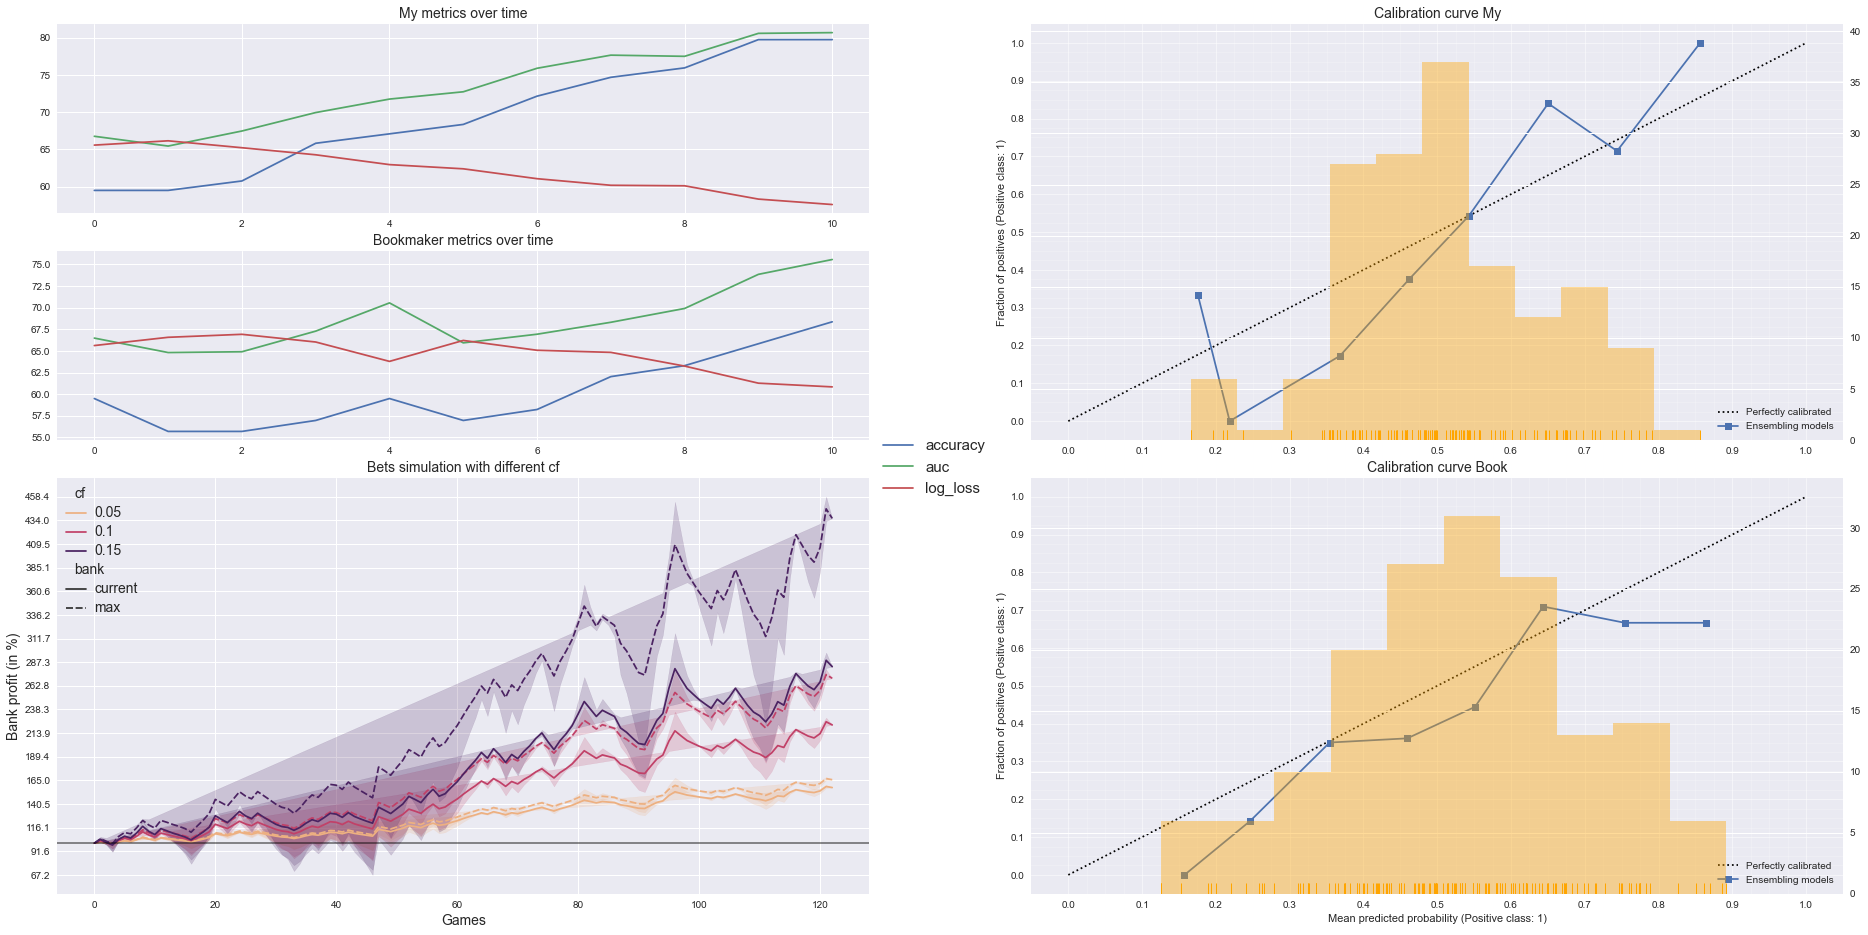

Unexcepted w., load without strict
Unexcepted w., load without strict
Unexcepted w., load without strict
Unexcepted w., load without strict
Unexcepted w., load without strict
Unexcepted w., load without strict
Unexcepted w., load without strict
Unexcepted w., load without strict
Num of games: 368
Num of games with odds: 170

Metrics on whole test corpus
--------------------------------------
accuracy   = 0.5788043478260869
b_accuracy = 0.578976936723832
AUC        = 0.6106889414547605

log_loss   = 0.6784493617470497
mae        = 0.4780356411052787
mse        = 0.24252401515962516
--------------------------------------

My metrics on odds corpus
--------------------------------------
accuracy   = 0.6058823529411764
b_accuracy = 0.6026884700665189
AUC        = 0.6756513303769403

log_loss   = 0.6453040396507904
mae        = 0.46234650576815883
mse        = 0.22710842369029263
--------------------------------------

Book metrics on odds corpus
--------------------------------------
accur

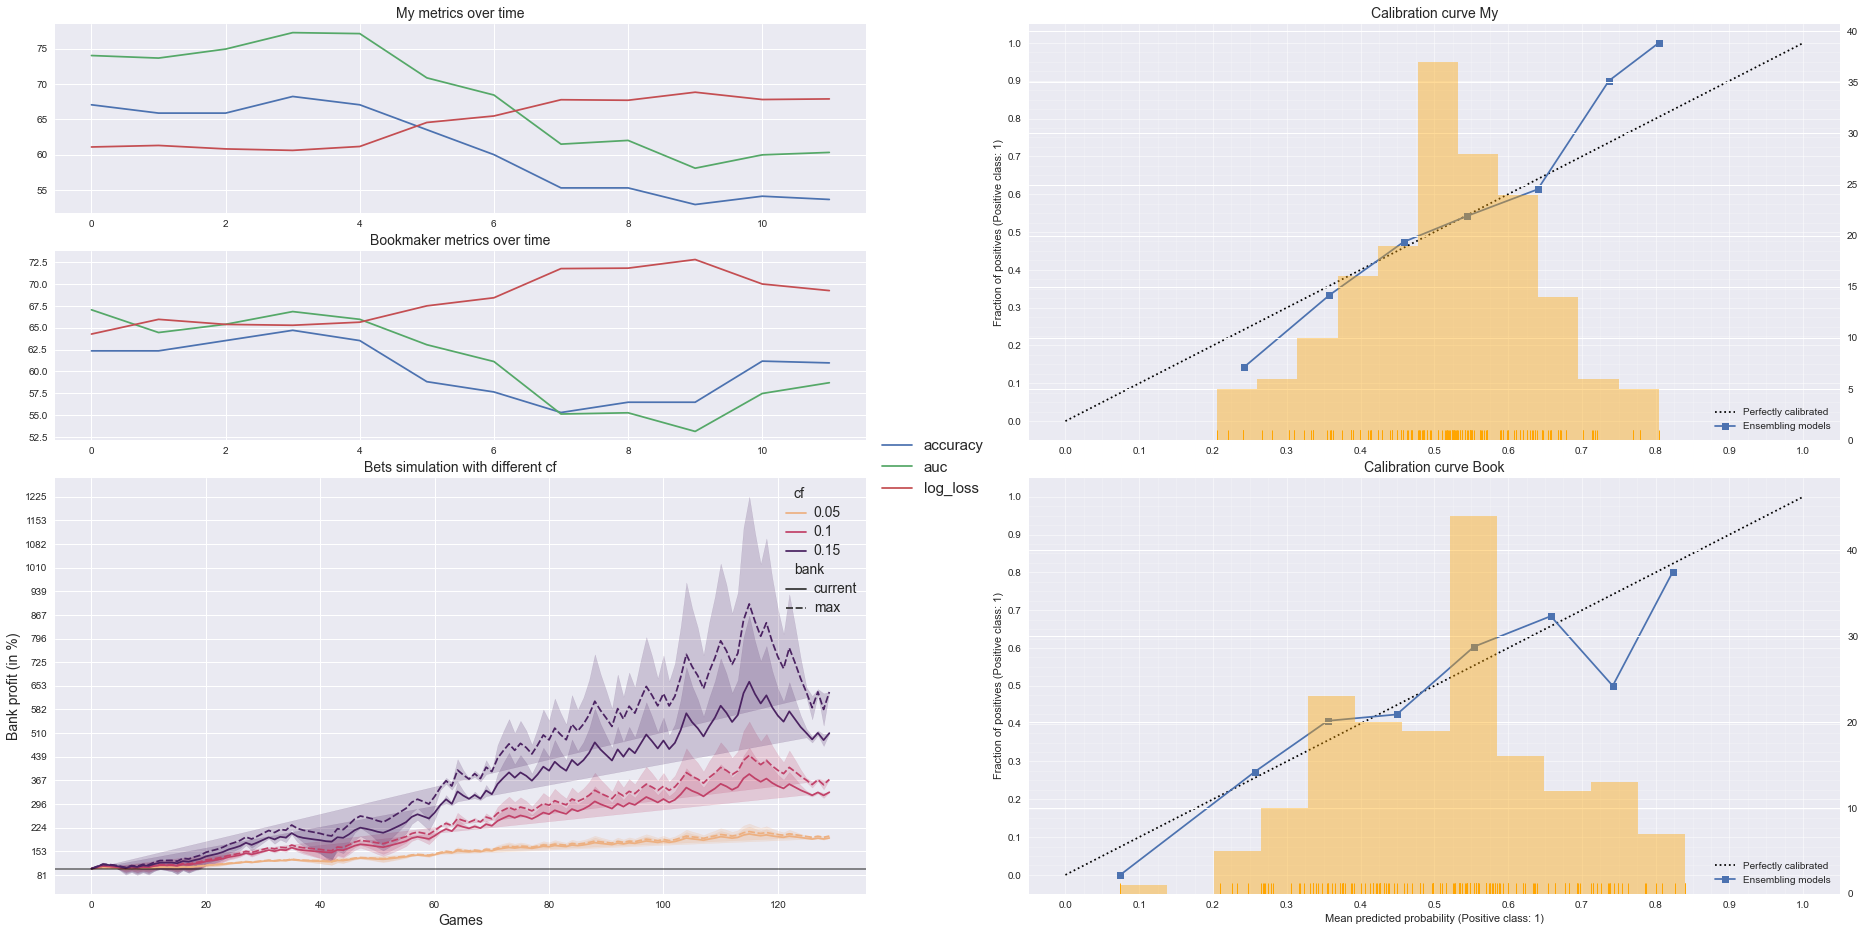

In [29]:
_ = evaluate('val', 'AUC')
_ = evaluate('test', 'AUC')

In [ ]:
df = make_dataframe('val', 'AUC')
df

### Evaluate

In [135]:
checkpoint = torch.load(f'output/models_w/prematch/Ensemble 0 2022.11.15 - 04-35 AUC.torch')

In [136]:
checkpoint['configs']['train']

{'public': {'split': {'val': 0.025, 'test': 0.075}},
 'league': {'split': {'val': 500, 'test': 500},
  'batch_size': 32,
  'label_smoothing': 0.1,
  'ensemble_boosting': True,
  'trainer': {'backward_second_output': False,
   'grad_clip_norm': 1,
   'grad_clip_value': 0,
   'r_drop': 0,
   'c_reg': ['r_window', 'd_window', 'r_window_featurs', 'd_window_featurs'],
   'c_reg_a': 0,
   'c_reg_e': 5,
   'c_reg_detach': True,
   'c_reg_distance': 'cos',
   'sample_weight': True},
  'rnn_init': {'ndim2': 'uniform',
   'ndim2_kwargs': {'a': -0.04, 'b': 0.04},
   'ndim1': 'zeros',
   'ndim1_kwargs': {}},
  'linear_init': {'ndim2': 'none',
   'ndim2_kwargs': {},
   'ndim1': 'none',
   'ndim1_kwargs': {}},
  'shuffle': False,
  'optimizer': 'Adam',
  'Adam': {'lr': '1e-3', 'weight_decay': '5e-6', 'amsgrad': False},
  'AdamW': {'lr': '5e-5', 'weight_decay': '6e-4', 'amsgrad': False},
  'AdamS': {'lr': '1e-4', 'weight_decay': '1e-6', 'amsgrad': False},
  'AdamC': {'lr': '5e-4', 'weight_decay': '1e

In [114]:
checkpoint['configs']['models']

{'prematch': {'windows_seq_encoder_type': ['GRU'],
  'compare_encoder_type': 'subtract',
  'team_embedding': {'embedding_dim': 8,
   'dropout': 0,
   'init': 'uniform',
   'init_kwargs': {'a': -0.1, 'b': 0.1},
   'max_norm': None},
  'prize_pool_embedding': {'embedding_dim': 16,
   'dropout': 0,
   'init': 'uniform',
   'init_kwargs': {'a': -0.1, 'b': 0.1},
   'max_norm': None},
  'windowGamesFeatureEncoder': {'statsEncoder': {'num_layers': 4,
    'ff_dim': 32,
    'norm': 'batch',
    'prenorm': False,
    'dropout': 0.15,
    'wdropoout': 0.15,
    'bdropoout': 0.15,
    'bias': True},
   'resultEncoder': {'dropout': 0,
    'init': 'uniform',
    'init_kwargs': {'a': -0.05, 'b': 0.05},
    'max_norm': None},
   'embed_dim': 32,
   'pos_encoding': False,
   'seq_permutation': {'shuffles_num': 10, 'max_step': 5, 'p': 0},
   'seq_masking': {'p': 0}},
  'windows_seq_encoder': {'transformer': {'embed_dim': 32,
    'num_heads': 2,
    'ff_dim': 32,
    'num_encoder_layers': 2,
    'skip_co

In [ ]:
dates = [
    '2022.11.03 - 06-07',
    '2022.11.04 - 18-05',
    '2022.11.04 - 11-31',
    '2022.11.05 - 10-09',
    '2022.11.06 - 09-34',
]
models_names = [f'Ensemble 0 {date}' for date in dates]

In [ ]:
checkpoint = torch.load(f'output/models_w/prematch/Ensemble 0 2022.11.06 - 09-34 AUC.torch')

In [ ]:
checkpoint['configs']['train']

In [ ]:
checkpoint['configs']['models']

In [ ]:
api = wandb.Api()
sweep = api.sweep('iorymaeda/Prematch-Research/sweeps/ozy0bjvj')

In [ ]:
sweep_runs = sweep.runs

In [ ]:
run = sweep_runs[-1]

In [ ]:
sweep.

In [ ]:
sweep_runs.

In [ ]:
evaluate('test', 'AUC')

In [ ]:
summary, cc_fig, gc_fig = evaluate('val', 'AUC')
_configs = {
    "features": config_base._get_config("features"),
    "match": config_base._get_config("match"),
    "models": config_base._get_config("models"),
    "train": config_base._get_config("train")
}
run = wandb.init(project="Prematch-Research", reinit=True, group=date, name=f"Summary", config=_configs)
for n, v in summary.items():
    run.summary[n] = v

# train_metrics, match_ids, y_pred, y_true = trainer.evaluate(train_loader)
# df = dataframe_from_predict(match_ids, y_pred, y_true)
# run.summary['train'] = df

run.finish()

### Sweep

In [22]:
def sweep():
    train(num_of_runs=1, verbose=False, sweep=True)

In [23]:
date = datetime.datetime.now().strftime("%Y.%m.%d - %H-%M")

sweep_configuration = {
    'method': 'bayes',
    'name': f'sweep - {date}',
    'metric': {'goal': 'maximize', 'name': 'AUC/val'},
    'parameters': {
        'batch_size': {'max': 256, 'min': 32},
        'label_smoothing': {'max': 0.15, 'min': 0.},
        'grad_clip_norm': {'distribution': 'uniform', 'max': 10., 'min': 0.},
        'sample_weight': {'values': [True, False]},
        'c_reg_a': {'values': [0, 0.005, 0.01, 0.025]},
        'c_reg_detach': {'value': True},
        'r_drop': {'value': 0},
        'rnn_bias_init': {'values': ['uniform', 'zeros', 'none']},
        'rnn_w_init': {'values': ['uniform', 'kaiming_uniform', 'kaiming_uniform_6', 'none']},
        'optimizer': {'values': ['Adam', 'AdamS', 'AdamC', 'SGD', 'SGDC', 'SGDS']},
        'lr': {'max': 1e-3, 'min': 5e-5},
        'weight_decay': {'max': 1e-3, 'min': 1e-6},
        'windows_seq_encoder_type': {'value': 'GRU'},
        'compare_encoder_type': {'values': ['linear', 'subtract']},
        'dropout': {'max': 0.5, 'min': 0.},
        'w_dropout': {'max': 0.5, 'min': 0.},
        'norm': {'values': ['layer', 'batch', 'none']},
        'prenorm': {'values': [True, False]},
        'use_rec_activation': {'values': [True, False]},
        'team_embedding':  {'distribution': 'int_uniform', 'max': 16, 'min': 1},
        'pp_embedding':  {'distribution': 'int_uniform', 'max': 8, 'min': 1},
        'encoder_layers': {'distribution': 'int_uniform', 'max': 4, 'min': 1},
        'encoder_dim': {'distribution': 'int_uniform', 'max': 64, 'min': 8},
        'seq_encoder_layers': {'distribution': 'int_uniform', 'max': 4, 'min': 1},
        'seq_encoder_dim': {'distribution': 'int_uniform', 'max': 64, 'min': 8},
        
        'compare_in_encoder_layers': {'distribution': 'int_uniform', 'max': 4, 'min': 1},
        'compare_in_encoder_dim': {'distribution': 'int_uniform', 'max': 64, 'min': 8},
        'compare_out_encoder_layers': {'distribution': 'int_uniform', 'max': 4, 'min': 1},
        'compare_out_encoder_dim': {'distribution': 'int_uniform', 'max': 64, 'min': 8},
     }
}

# sweep_id = wandb.sweep(sweep=sweep_configuration, project='Prematch-Research')
wandb.agent('fgzdohhb', function=sweep, count=200, project='Prematch-Research')

wandb: Agent Starting Run: t6z11tt7 with config:
wandb: 	batch_size: 148
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 34
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 24
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.41174150313578606
wandb: 	encoder_dim: 52
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 8.374525229570839
wandb: 	label_smoothing: 0.05051113981360412
wandb: 	lr: 0.0006363302882969354
wandb: 	norm: layer
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 2
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 10
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 5
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.18452296928103673
wandb: 	weight_decay: 0.00022409050534030856
wandb: 	windows_seq_encoder_type: GRU
wandb: Currently logged in as: iorymaeda. Use `wa

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,█▅▂▁▅▇▇▃▄▇▇▇▇▇▇▇▇▇▇▇
AUC/train,▁█▃▂▄▂▂▂▂▂
AUC/val,▂▁▂▄▄▆█▆▆▅▅▅▅▅▅▄▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Acc/test,███████▂▁███████████
Acc/train,▁▁▁▁█▁▁▁▁▁
Acc/val,▃▃▃▃▃▃▃▃▃▃▃▃▃▃█▁▅▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▁█████████
LogLoss/val,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,██████▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: im4b6hnx with config:
wandb: 	batch_size: 152
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 34
wandb: 	compare_in_encoder_layers: 3
wandb: 	compare_out_encoder_dim: 54
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.3869238385612708
wandb: 	encoder_dim: 43
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 1.8424923470587873
wandb: 	label_smoothing: 0.04077123342937669
wandb: 	lr: 0.0003668463551878398
wandb: 	norm: none
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 9
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 12
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.3238590167469261
wandb: 	weight_decay: 0.0005411571762341934
wandb: 	windows_seq_encoder_t

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,█▆▄▄▅▄▅▄▄▄▄▄▃▂▂▂▁▁▁▂
AUC/train,▁▁▁▃▃▄▅▇▇█
AUC/val,█▄▅▃▁▄▅▅▆▅▅▆▅▄▄▄▄▆▅▄▆▄▅▅▅▅▄▃▄▄▅▃▅▃▅▅▆▅▅▄
Acc/test,█████▆█▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▆██████
Acc/val,▇▇▇▇▇▇▇▇▇▇▇█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▁▃▄▅▅▆▆▆▇▇▇▇████████
LogLoss/train,█▄▂▂▁▁▁▁▁▁
LogLoss/val,▁▂▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████
Profit/test,▁▁▃▃▃▃█▆▆▆▆▆▆▆▆▆▆▆▆▆


wandb: Agent Starting Run: r2b2zuao with config:
wandb: 	batch_size: 175
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 58
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 38
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.056278508851386466
wandb: 	encoder_dim: 52
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 3.863255197942752
wandb: 	label_smoothing: 0.10724295716573524
wandb: 	lr: 0.0006887063389178755
wandb: 	norm: none
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 18
wandb: 	seq_encoder_layers: 1
wandb: 	team_embedding: 8
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.07286176607991651
wandb: 	weight_decay: 0.0008252529311753412
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proje

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▃▅▆▆▆▆▆▇▇▇▇▇█▆▇▆▇▇█
AUC/train,▁▆▇▇▇▇▇███
AUC/val,▁▁▅▇▇█▇██▇▇▇▇██▇▇▇▇▇█▇▇█▇▇▇█▇▇▇▇▇▇▇▇▆▆▇▆
Acc/test,▁▆▃▅█▆██▆▇▇▇▆█▆▇▇▆▅▆
Acc/train,▁▆▆▇▇▇████
Acc/val,▁▃▃▆▆▅▆▆▆▄▅▅▄▇▆▅▆▅▆▆▆▇▆▇▅█▅▇▆▇▇▆▆▇▇▇▄▆▄▅
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▃▂▁▂▃▃▅▄▆▅▅▅▅▆█▆█▆▇▇
LogLoss/train,█▃▃▂▂▂▂▁▁▁
LogLoss/val,█▇▅▂▂▁▂▁▂▂▁▂▂▁▁▂▂▂▂▁▁▂▂▂▂▂▂▁▂▁▂▂▂▂▂▂▃▃▂▃
Profit/test,█▅▅▅▅▄▅▅▄▄▆▄▄▅▄▁▁▂▃▃


wandb: Agent Starting Run: nbs398a5 with config:
wandb: 	batch_size: 121
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 53
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 35
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.3778523304915511
wandb: 	encoder_dim: 13
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 8.587644239224153
wandb: 	label_smoothing: 0.12004514574280196
wandb: 	lr: 0.0001613921145414883
wandb: 	norm: none
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 13
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 16
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.08670640078047759
wandb: 	weight_decay: 0.00036726864982374735
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proje

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▁▃▂▂▂▃▃▄▅▅▆▆▆▆▇▇▇▇▇▇█▇▇█████████████
AUC/train,▁▃▃▄▅▇█████████████
AUC/val,▁▁▁▁▁▂▂▂▄▅▇█████████████████████████████
Acc/test,▁▂▁▃▃▄▄▅▄▅▅▆▆▇▇▇▇▇▇▇▆▆▇▇▇██▇▇▇████▇▇▇
Acc/train,▁▁▃▄▆██████████████
Acc/val,▁▄▄▄▄▃▃▄▅▆███▇▇▇██▇██▇████▇█▇▇▇▇▇▇▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁███▇▇▇▇▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅
LogLoss/test,███████▇▆▆▅▄▄▃▃▃▂▂▂▂▂▁▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁
LogLoss/train,████▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,████████▆▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▂▂▂▂▂▂▂▁▁▁▃▅▄▆▄▅▆▅▅▅▆▅▆▆▆▄▆▆▆▅▆▆█▇▆▆█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qsfz5cjo with config:
wandb: 	batch_size: 125
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 51
wandb: 	compare_in_encoder_layers: 4
wandb: 	compare_out_encoder_dim: 40
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.3701987809539651
wandb: 	encoder_dim: 52
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 1.1982828117278457
wandb: 	label_smoothing: 0.004986297413824342
wandb: 	lr: 0.0006697946567405274
wandb: 	norm: layer
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 32
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 10
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.0861200547663391
wandb: 	weight_decay: 0.0003942001576323268
wandb: 	windows_seq_enc

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AUC/train,█▁▁▁▁▁▁▁▁▁
AUC/val,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁
Acc/val,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▂▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▁▂▄▆██████
LogLoss/val,█▁▃▅▅▅▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Profit/test,██████████████▁▁▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6u7dzya9 with config:
wandb: 	batch_size: 72
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 26
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 45
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.24915592424727184
wandb: 	encoder_dim: 36
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 1.0236485187543032
wandb: 	label_smoothing: 0.06394742827200692
wandb: 	lr: 0.000652288846626027
wandb: 	norm: layer
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 8
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 16
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 11
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.1560050976291492
wandb: 	weight_decay: 0.0004944704374105602
wandb: 	windows_seq_encoder_type: GR

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▃▁▄▃▃▄▅▅▅▅▅▅▆▆▅▆▆▇▇▇███▇███████████████
AUC/train,▁▃▃▄▄▅▄▅▅▅▅▆▆▆▆▆▆▇▇█████████████████████
AUC/val,▁▃▄▄▅▅▆▆▆▅▆▆▆▆▆▆▆▇████████████████████▇█
Acc/test,▁▃▂▃▂▄▅▆▅▅▅▅▅▆▆▅▅▇▇▇▇▇▇██▇▇▇█▇▇▇▇▇▇▇▇▇▇▇
Acc/train,▁▃▃▄▄▅▄▅▆▅▆▆▆▆▆▆▆▇▇█████████████████████
Acc/val,▁▄▄▅▅▆▇▆▆▆▆▅▆▅▅▆▆▇█▇▇█▇█▇██▇█▇████▇▇▇▇▇█
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▆▆▆▆▆▆▅▆▇▆▇██▆▇▆▇▇▇▄▄▂▂▁▂▂▂▂▁▂▂▁▂▁▂▂▂▂▂▁
LogLoss/train,██████▇▆▆▅▅▅▅▅▅▅▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,██████▆▆▆▇▆▇▆▆▇▆▆▃▂▂▁▁▁▁▁▁▁▁▂▁▁▁▂▁▂▁▁▁▂▁
Profit/test,▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▂▂▁▂▃▄▆▅▅▅▆▅▃▆▇▆████▄▄▆▅▄


wandb: Agent Starting Run: 20z637y5 with config:
wandb: 	batch_size: 45
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 55
wandb: 	compare_in_encoder_layers: 3
wandb: 	compare_out_encoder_dim: 61
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.1478762045298837
wandb: 	encoder_dim: 58
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 1.4255880875653415
wandb: 	label_smoothing: 0.05388457432933371
wandb: 	lr: 0.0007441519578661525
wandb: 	norm: batch
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 1
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 15
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 2
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.03125626000130127
wandb: 	weight_decay: 0.00013480854934161176
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▆██████████████████
AUC/train,▁█████████
AUC/val,▁▅▇██████████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Acc/test,▁▅▇▆█▇▇▇██▇██▇▇█████
Acc/train,▁█████████
Acc/val,▁▅▇▇█████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▆█▂▂▁▂▁▁▂▁▂▁▂▁▂▂▁▂▁▂
LogLoss/train,█▂▁▁▁▁▁▁▁▁
LogLoss/val,█▆▃▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Profit/test,▁▄▇█▄▄▄▃▃▃▃▃▃▃▂▂▃▃▃▃


wandb: Agent Starting Run: 3ufv057q with config:
wandb: 	batch_size: 218
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 64
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 64
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.30377061913938724
wandb: 	encoder_dim: 25
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 9.296311641530483
wandb: 	label_smoothing: 0.06966294558747707
wandb: 	lr: 0.000910536191745436
wandb: 	norm: none
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 43
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 13
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.04261861768223735
wandb: 	weight_decay: 0.0008792144885705325
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when ru

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AUC/train,█▁▁▁▁▁▁▁▁▁
AUC/val,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁
Acc/val,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
LogLoss/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▁█████████
LogLoss/val,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: ywfsmn5g with config:
wandb: 	batch_size: 150
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 30
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 29
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.4833704355694733
wandb: 	encoder_dim: 36
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 4.022534099898576
wandb: 	label_smoothing: 0.11489028571852512
wandb: 	lr: 0.0007768615377769164
wandb: 	norm: layer
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 16
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 9
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.12584246451508718
wandb: 	weight_decay: 0.0005321825193534947
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg projec

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▅▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇██████
AUC/train,▁▆▇▇██████████████████
AUC/val,▁▂▄▇██▇▇▇██▇▇██▇█▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇
Acc/test,▄▁▂▂▃▄▅▅▅▆▆█▇▆▇▇█▇▆▆█▆▇▇▇▆▇▇▆▇▇▆▆▇█▇▇▆▇▆
Acc/train,▁▃▇▇▇█████████████████
Acc/val,▁▁▄████▇█▇▇▇▇▇▇▇█▇▆▇▇▇█▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁█▇▆▅▅▄▄▃▃▃▃▃▃▃▃▃▃▂▂▃▃▃▃▃▂▂▂▂▂▂
LogLoss/test,▆▇▆█▆▅▄▄▄▄▄▅▄▄▅▃▅▃▅▄▄▅▄▃▆▄▅▅▄▂▄▄▄▄▁▂▂▂▃▃
LogLoss/train,██▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,███▃▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂
Profit/test,▁▁▁▃▃▄▄▇▅▄█▅▄▂▃▄▃▅▄▃▄▄▄▅▅▄▄▂▄▆▆▆▅▄▆▇▆▄▅▄


wandb: Agent Starting Run: kr9ojj15 with config:
wandb: 	batch_size: 45
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 61
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 61
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.34176218671015934
wandb: 	encoder_dim: 28
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 8.284587467170901
wandb: 	label_smoothing: 0.11665197334561096
wandb: 	lr: 0.0004850526298612856
wandb: 	norm: none
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 18
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 7
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.33952766985668564
wandb: 	weight_decay: 0.0005173658259653513
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when runnin

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▁▃▄▃▃▄▆▆▆█▂█▇▇█▇▆▆▆
AUC/train,▂█▄▄▂▁▁▂▁▂
AUC/val,█▅▄▄▃▂▂▂▁▂▁▁▁▂▂▂▂▅▂▂▂▂▄▁▂▂▂▂▂▆▂▂▁▄▂▂▂▂▂▂
Acc/test,▆▆▁▁▁▁▁▄▁▇▆▆▆▆▆▆▆▆▆█
Acc/train,▁▃▃▃█▁▁▁▁▁
Acc/val,████▁▁▁▁▁▁▁▁▁▇▇▂▂█▇████████████▇██▇▇█▇█▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▁▆███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
LogLoss/train,█▁▂▂▂▂▂▂▂▂
LogLoss/val,▁▃▆▇██████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Profit/test,▁▅█████▅█▅▅▅▅▅▅▅▅▅▅▅


wandb: Agent Starting Run: 5cmg5rvt with config:
wandb: 	batch_size: 215
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 46
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 34
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.4913660557437384
wandb: 	encoder_dim: 38
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 5.824735262319972
wandb: 	label_smoothing: 0.08882594488061042
wandb: 	lr: 0.0007325658707058692
wandb: 	norm: none
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 12
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 12
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.11826215338405104
wandb: 	weight_decay: 6.148950279507744e-05
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▃▆▇▇▇▇████████████████████████████▇████
AUC/train,▁▆▇████████████████████
AUC/val,▁▁▇███████▇██▇████████████▇█████████████
Acc/test,▂▁▅▇█▇███████▇▇▇█▆▆▇███▇▇█▇██▇█▇██████▇▇
Acc/train,▁▆▇▇███████████████████
Acc/val,▁▃▆█▇▇▆▇▇▇█████▇█▇█████▇█▇▇██▇▇▇██████▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁█▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
LogLoss/test,▅▅█▂▃▂▂▃▂▂▂▂▂▃▂▂▂▂▂▁▃▁▂▂▄▃▂▂▃▄▂▃▁▄▃▃▃▃▄▃
LogLoss/train,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,██▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▁▇▃▅▄▄▇▆▆█▆▅▆▆▆▅▅▅▅▅▆▄▆▆▆▅▅▃▅▄▃▃▃▄▃▄▂▂


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kydwf6x0 with config:
wandb: 	batch_size: 170
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 51
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 61
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.286569506175408
wandb: 	encoder_dim: 43
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 5.429018120840236
wandb: 	label_smoothing: 0.10645447837325513
wandb: 	lr: 0.0008788105407690121
wandb: 	norm: none
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 17
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 15
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.199029819078116
wandb: 	weight_decay: 0.0001245043600541141
wandb: 	windows_seq_encoder

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████▇▇▇
AUC/train,▁▂▃▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇████████████
AUC/val,▁▂▃▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇███████████████
Acc/test,▁▂▄▄▃▃▆▄▅▆▆▇▇▆▇▇▆▇▇▇█▇▅▅▆▇▇▆▇▇▇▇▇▇▆▇▇▇▆▆
Acc/train,▁▂▃▃▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇█████████
Acc/val,▁▁▂▃▃▄▅▆▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇█▇▇▇▇█████▇▇█▇▇
ContrastiveLoss/train,▁▁▁▁██▇▇▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
LogLoss/test,█████▇▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▃▃▃▂▁▁▁▁▁▁▂▂▂▂▃▃▄▅
LogLoss/train,██████▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁
LogLoss/val,██████▇▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▁▁▁▁▂▃▃▃▃▅▅▄▅▆▅▅▄▄▆▅▅▃▃▃▆▆▆███▇▅▆▆▇▆▆▅


wandb: Agent Starting Run: rc47e7m5 with config:
wandb: 	batch_size: 74
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 46
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 29
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.2980989155761141
wandb: 	encoder_dim: 52
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 0.2815033380533649
wandb: 	label_smoothing: 0.02479619587072291
wandb: 	lr: 0.0007565457375467693
wandb: 	norm: batch
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 8
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 31
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 14
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.06466144391636208
wandb: 	weight_decay: 0.00029071872697319467
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when runni

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇█████
AUC/train,▁▆▆▇▇▇▇▇▇▇▇█▇█████
AUC/val,▆▂▁▂▃▂▃▅▄▄▄▅▄▄▄▄▅▆▆▇▆▇▇▆▇▇█▆▇█▇▇▅▅▆▆▇▇██
Acc/test,▁▄▆▆▆▇▅▆▄▆▅▆▆▅▆▆▆▅▆▇▆▇▆▆▆▆▇▆███████
Acc/train,▁▅▆▇▇▇▇▇▇▇▇█▇█████
Acc/val,▆▆▆█▄▆▃▄▃▄▄▅▃▄▁▃▄▅▃▄▄▅▅▄▂▅▃▂▂▃▂▃▁▂▃▁▄▄▃▄
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▇▂▁▁▁▃▃▃▅▆▅▅▅▅▄▆▄▆▄▅▄▅▅▆▅▃▄▅▅▆▆▄▄▆
LogLoss/train,█▆▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
LogLoss/val,█▇▅▃▃▂▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▂▂▂▂▂▂▁▁▁
Profit/test,▂▂▄▃▅▆▅▇█▇▆▆▃▆▇▅▅▃▂▃▁▅▃▁▁▂▅▄▆▅▃▂▃▅▁


wandb: Agent Starting Run: g1djl3on with config:
wandb: 	batch_size: 158
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 25
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 60
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.1195538560889438
wandb: 	encoder_dim: 45
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 5.252611164400872
wandb: 	label_smoothing: 0.07561929443013303
wandb: 	lr: 0.0008361808086316924
wandb: 	norm: layer
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 6
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 38
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 9
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.0628192040489986
wandb: 	weight_decay: 0.0007489043281760306
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project w

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
AUC/train,█▁▁▁▁▁▁▁▁▁
AUC/val,▂▆█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/test,▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,█▁▁▁▁▁▁▁▁▁
Acc/val,▄██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▁█████████
LogLoss/val,▂▁██████████████████████████████████████
Profit/test,▁███████████████████


wandb: Agent Starting Run: bdqpj0vt with config:
wandb: 	batch_size: 37
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 44
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 37
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.09202515418844807
wandb: 	encoder_dim: 20
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 8.510728956586478
wandb: 	label_smoothing: 0.05853176420502698
wandb: 	lr: 0.0007720366996057898
wandb: 	norm: layer
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 34
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 11
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.27180756696408437
wandb: 	weight_decay: 0.0007560830657667321
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when r

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AUC/train,█▁▁▁▁▁▁▁▁▁
AUC/val,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▁█████████
LogLoss/val,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: jtvgohwj with config:
wandb: 	batch_size: 159
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 50
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 40
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.41106026249886
wandb: 	encoder_dim: 21
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 3.727493924998985
wandb: 	label_smoothing: 0.12143375617197882
wandb: 	lr: 0.0009504392606039784
wandb: 	norm: batch
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 17
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 6
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.061655692285156605
wandb: 	weight_decay: 3.53737514693394e-05
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proje

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▃▄▅▅▅▅▅▄▅▆▇▇▇▇█▇▆▆
AUC/train,▁▇▇███████
AUC/val,▁▂▄▆▇██▇▇█▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄
Acc/test,▁▄▄▆▆▇▇▅▄▅█▅▇▇▅▅▅▄▇▇
Acc/train,▁▇▇▇█████▇
Acc/val,▁▂▃▆▇██▇██▇▇█▇▇▇▇▇▇▇▆▇▆▆▅▅▅▅▄▆▆▅▄▄▄▅▄▄▄▄
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▄▃▅▂▁▂▄▆▇█▆▅▂▂▂▂▁▃▂▅
LogLoss/train,█▃▂▁▁▁▁▁▁▂
LogLoss/val,██▆▄▃▂▁▂▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆
Profit/test,▁▃▄▄▄▆▅▇▆▄▅▄▆▇▇▅▇▆██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mhqfqztg with config:
wandb: 	batch_size: 180
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 55
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 42
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.114129720346835
wandb: 	encoder_dim: 23
wandb: 	encoder_layers: 1
wandb: 	grad_clip_norm: 8.554146233484703
wandb: 	label_smoothing: 0.0795361759726866
wandb: 	lr: 0.00010901858612307696
wandb: 	norm: none
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 1
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 19
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 4
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.01743693915554989
wandb: 	weight_decay: 0.00040437397081705253
wandb: 	windows_seq_encode

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▆▇▇▇▇▇▇█████████████████▇▇▇█▇▇▇▇▇▇▇▇▇▇▇
AUC/train,▁▄▄▄▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████
AUC/val,▁▁▁▂▄▆▆▇▇▇▇█████████████████████████████
Acc/test,▁▅▅▇▇▆▆▇▆▆▆▇▇▇▆▇▇▇█▇█▇▇▇█▇▇▇█▇▇█▇▇▇▆▇▆▇▆
Acc/train,▁▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
Acc/val,▁▁▁▂▆▇▇█▇▇▇▇▆▆▇███████▇▇▇▆▆▇▆▇▇▇▇▇▇▇▇▇▇█
ContrastiveLoss/train,▁▁▁▁███▇▇▇▇▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆
LogLoss/test,▄▃▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▅▄▅▄▅▅▆▆▆▆▇▆▇▇█
LogLoss/train,█▆▆▅▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
LogLoss/val,███▇▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▂▂▃▃▄▄▅▅▆▅▅▆▆▆███▇▇▇▆▆▆▆▆▆▇▅▅▆▆▆▅▅▅▅▄▄▄


wandb: Agent Starting Run: t0ulcio2 with config:
wandb: 	batch_size: 157
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 61
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 57
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.4119925918911683
wandb: 	encoder_dim: 45
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 1.2060134169754455
wandb: 	label_smoothing: 0.1001699090609506
wandb: 	lr: 0.0004128190347481286
wandb: 	norm: none
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 12
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 8
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.05826909410832187
wandb: 	weight_decay: 0.0008986274470619951
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proje

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▆▇▆▇▇▇████████████████▇██▇
AUC/train,▁▅▇▇▇▇▇▇██████
AUC/val,▁▃▄▆▇███████████████████████████████▇███
Acc/test,▁▇▇▆▆▇█▇█▇▇▇▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇
Acc/train,▁▆▇▇▇▇▇▇██████
Acc/val,▁▄▆▆▇███▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▆▇▆▇▆▇▇█▇▇▇▇▇█▇▇█
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
LogLoss/test,█▄▄▅▄▃▂▂▂▁▁▁▂▂▄▃▄▄▅▄▅▅▅▆▅▅▆
LogLoss/train,█▄▃▂▂▂▂▂▁▁▁▁▁▁
LogLoss/val,█▇▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▃▂▄▄▃▄▅▅▇▆▆█▅▄▄▄▅▃▄▅▄▅▃▅▄▃


wandb: Agent Starting Run: 3jl6pug5 with config:
wandb: 	batch_size: 174
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 40
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 32
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.12396279721082948
wandb: 	encoder_dim: 8
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 5.183115418680946
wandb: 	label_smoothing: 0.09323350284250176
wandb: 	lr: 0.0006969880178303403
wandb: 	norm: layer
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 27
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 15
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.018047490028974045
wandb: 	weight_decay: 0.00020666809981417688
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg p

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▂▂▂▁▂▃▅▆▇█▂▂▂▁▁▁▁▁▁▁
AUC/train,▁▂▄▆█▄▄▅▅▆
AUC/val,▁▁▁▁▂▂▃▃▄▄▅▅▆▆▆▇▇▇██▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆
Acc/test,█▁▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Acc/train,▁█▆▆▆▆▆▆▆▆
Acc/val,██▆▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃
LogLoss/test,▁▂▃▄▅▅▆▆▆▇█████▇████
LogLoss/train,█▆▄▂▁▃▃▃▂▂
LogLoss/val,▁▂▂▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██████████▇█████████
Profit/test,▄▁██████████████████


wandb: Agent Starting Run: f8dy74u1 with config:
wandb: 	batch_size: 137
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 14
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 30
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.3987830531168533
wandb: 	encoder_dim: 46
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 5.688339620633468
wandb: 	label_smoothing: 0.040870226769450214
wandb: 	lr: 0.0006604691390907544
wandb: 	norm: none
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 11
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 16
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.1831042067773949
wandb: 	weight_decay: 0.0003237186235984446
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▃▇█▄▁▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃
AUC/train,▁█▄▂▃▃▃▃▃▃
AUC/val,▂▅█▆▅▂▁▂▃▃▄▄█▆▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
Acc/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁█████████
Acc/val,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▄██▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,█▁▂▃▃▃▃▃▃▃
LogLoss/val,▅▇▆█▆▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,████████████▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: 0x3p37zi with config:
wandb: 	batch_size: 164
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 30
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 43
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.07050783937227806
wandb: 	encoder_dim: 34
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 3.737039362343207
wandb: 	label_smoothing: 0.03648540344059782
wandb: 	lr: 0.00022282804895132387
wandb: 	norm: batch
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 25
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 10
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.15793775495457263
wandb: 	weight_decay: 0.0005060261467716228
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project whe

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▄▄▅▆▆▆▆▆▆▆▆▆▆▆▅▆▆▆▆▆▆▇▇▆▇▆▇▇▇▇▇▇█▇▇▇█▇█
AUC/train,▁▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
AUC/val,▁▂▂▂▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇█▇████▇██▇███
Acc/test,▁▅▅▆▇▆█▆▆▅▆▅▆▅▄▄▄▅▃▄▃▆▅▆▅▆▅▆▆▇▇▇▆▆▆▅█▇▅▆
Acc/train,▁▃▃▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Acc/val,▁▂▂▂▂▄▅▆▆▇▇█▇█▇▇▇▇▇▇▇▆▇▇▇▆▅▆▇▇▇▆▇▆▇▇▇▇█▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁███▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
LogLoss/test,▃▂▂▁▁▂▂▁▂▂▂▂▁▃▃▃▃▃▄▄▅▄▃▄▆▆▆▅▅▇▇▅█▄▆▇█▆▇▆
LogLoss/train,█▇▆▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
LogLoss/val,█▇▇▇▅▄▄▃▃▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▂▂▂▂
Profit/test,▄▆▇▆▅█▆▅▇▆▄▄▃▂▃▂▂▂▂▂▁▂▃▂▂▂▂▂▂▃▂▂▃▄▂▄▄▃▃▃


wandb: Agent Starting Run: n853voot with config:
wandb: 	batch_size: 134
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 55
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 47
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.4091913342980445
wandb: 	encoder_dim: 30
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 3.2505776800791097
wandb: 	label_smoothing: 0.069422813864479
wandb: 	lr: 0.00024663534568403856
wandb: 	norm: none
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 2
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 31
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 3
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.15183548946318337
wandb: 	weight_decay: 5.6586570349892935e-05
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▆▇▆▆▆▇▇▇▇▇▇▇██████████████████████████
AUC/train,▁▅▇▇███████████████████
AUC/val,▁▂▅▆▆▇▇█████████████████████████████████
Acc/test,▁▁▆▇▆▆▅▆▇▇▇▇▇▇██▇█▇██▇▇▇██▇▇███▇█████▇██
Acc/train,▁▅▇▇▇▇█████████████████
Acc/val,▁▃▅▆▆▇████▇█████████▇█████▇▇▇▇▇▇▇▇▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁█▇▇▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
LogLoss/test,▇▇▆▆██▇▆▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁
LogLoss/train,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,██▆▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▂▂▃▂▁▃▄▅▆▆▇▆▅▆██▆███▆▆▆▆▇▇▅▆▆▆▆▇▅▅▅▅▅▆▅▅


wandb: Agent Starting Run: bdm8w5y4 with config:
wandb: 	batch_size: 152
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 21
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 35
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.2899246372052713
wandb: 	encoder_dim: 29
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 2.276721967671036
wandb: 	label_smoothing: 0.020242848053974777
wandb: 	lr: 0.0004687346825426941
wandb: 	norm: batch
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 30
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 6
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.14683168780276729
wandb: 	weight_decay: 2.3065483742758727e-05
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when r

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▃▅▇▇███▇▇▆▆▅▆▅▆▅▅▅▆
AUC/train,▁▆▇▇██████
AUC/val,▁▂▄▅▆▇█████████████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅
Acc/test,▁▃▆▆▇█▇▆▅▄▅▆▂▅▅▇▃▂▄▅
Acc/train,▁▆▇▇▇▇▇███
Acc/val,▁▂▃▅▆▆▇▇▇███▇█▆▇▇▇▆▇▆▇▇▆▇▇▆▆▆▅▅▄▄▅▅▅▄▄▃▄
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▆▇█▄▃▁▃▄▃▄▄▃▃▄▄▅▅▅▅▅
LogLoss/train,█▄▂▂▂▁▁▁▁▁
LogLoss/val,█▇▇▅▃▃▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▂▃▃▃▃▃▃▄▄▄▃▄▄▄▄▄▄
Profit/test,▁▃▂▅▄█▄▅▄▄▃▅▂▃▄▄▄▅▄▃


wandb: Agent Starting Run: p1j06fs3 with config:
wandb: 	batch_size: 82
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 12
wandb: 	compare_in_encoder_layers: 3
wandb: 	compare_out_encoder_dim: 44
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.11924837846734936
wandb: 	encoder_dim: 24
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 3.0313700663868803
wandb: 	label_smoothing: 0.017289734573570442
wandb: 	lr: 0.0008006469362734124
wandb: 	norm: none
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 14
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 8
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.00031685285027338583
wandb: 	weight_decay: 4.228895529257528e-05
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project w

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▃▂▁▁▂▂▂▂▂▃▃▃▃▃▄▃▄▄▄▄▄▅▆▆▆▇███
AUC/train,▁▂▃▄▄▅▅▅▆▇▇▇▇██
AUC/val,▁▂▄▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▆▇▇▇▇▇█▇▇▇▇▇▇▇███▇▇▇▇
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁███▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆
LogLoss/test,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,█▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁████████████████████████████


wandb: Agent Starting Run: gnycp9da with config:
wandb: 	batch_size: 234
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 61
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 40
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.4192874596203464
wandb: 	encoder_dim: 15
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 7.915117638659954
wandb: 	label_smoothing: 0.042411523676540226
wandb: 	lr: 0.0005449345282576053
wandb: 	norm: batch
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 8
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: none
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 28
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 7
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.026299425205777105
wandb: 	weight_decay: 0.0007391739267655586
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when ru

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▆▆▆▇▅▆▆▇▇▇▇▇▇▇██████████████▇▇▇
AUC/train,▁▅▆█████████████
AUC/val,▁▃▄▄▄▄▇▇▇▇████████████████████████████▇▇
Acc/test,▁▅▅▅▆▃▆▇▇▆▆▆▆▇▇██▇█▇▇▇█▇▇▇▇█▇▆▆▆
Acc/train,▁▅▆█████████████
Acc/val,▁▄▄▄▄▅▆▇██▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇█
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂
LogLoss/test,█▇▃▃▃▆▅▄▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▂▂▃▂▅▄
LogLoss/train,█▅▅▂▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,██▇▇▆▆▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂
Profit/test,▁▁▃▃▃▄▅▄▆▅▆▅▅▇▇▅▇▅▇█▆▆▆▇▅▆▆▅▃▃▄▄


wandb: Agent Starting Run: wiop04c3 with config:
wandb: 	batch_size: 179
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 20
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 53
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.39850302106930313
wandb: 	encoder_dim: 27
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 9.443212598817066
wandb: 	label_smoothing: 0.053873691658595645
wandb: 	lr: 0.0007398967685259981
wandb: 	norm: batch
wandb: 	optimizer: SGDS
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 51
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 10
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.0137420327322878
wandb: 	weight_decay: 0.00033811360380313425
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proje

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▂▁▄▅▇▇▇▇█▇██▇████▇██▇▇▇
AUC/train,▁▄▇▇████████
AUC/val,▁▁▁▂▃▄▆▇▇███▇████████████████████▇██▇██▇
Acc/test,▂▁▄▄▅▆▆▇▇▆▇▇▇▇▇█▇▇█▇▇▇▇
Acc/train,▁▄▆▇▇███████
Acc/val,▂▁▂▁▂▃▅▇█▆▇███▇▇▇█▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▆▇▆▇▇▆
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,██▇▆▃▃▃▂▂▂▂▁▃▂▁▁▂▂▃▂▂▃▄
LogLoss/train,█▇▄▂▂▂▂▂▁▁▁▁
LogLoss/val,█████▇▅▄▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁
Profit/test,▁▁▂▅▃▄▅▆▆▄▄▄▃▆▆▆▅▆█▆▅▇▆


wandb: Agent Starting Run: 0g53o1xg with config:
wandb: 	batch_size: 76
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 49
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 50
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.25661765677891163
wandb: 	encoder_dim: 52
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 4.939233768727239
wandb: 	label_smoothing: 0.124644368789991
wandb: 	lr: 0.000822409131388135
wandb: 	norm: layer
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 15
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 16
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.22459524833305344
wandb: 	weight_decay: 0.00038776026339854393
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,█▇▇▆▆▄▄▄▆█▄▃▇▄▁▄▄▃▂▁
AUC/train,▂█▁▁▂▂▁▃▂▂
AUC/val,▆▁█▃██▇▆▅▅▃▅▅▄▅▄▅▄▆▄▄▄▃▂▅▃▅▃▃▂▂▂▄▄▂▃▃▆▃▂
Acc/test,▅▁▁▇▇▃▁▃▄█▁▇▁▁▇▁▇▇▇▇
Acc/train,▁▇▁█▆█▇▁▁▁
Acc/val,▃▁▁▁▁▁███▅▆█▁▄▅▁▂▁▃▁▁▁██▁███████▁▂██████
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▂▂▁▂▁▁▂▁▁▂▂▂▂▂▂▂▂▁
LogLoss/test,▁█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
LogLoss/train,▁▇████████
LogLoss/val,▃█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,███▁▁▁█▃▃▃▃▁██▁█▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 92psuaff with config:
wandb: 	batch_size: 256
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 45
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 48
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.06487028638525522
wandb: 	encoder_dim: 31
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 0.27974694455511595
wandb: 	label_smoothing: 0.03929755411953557
wandb: 	lr: 0.0009768649528713266
wandb: 	norm: batch
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 13
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 14
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.03973897875091725
wandb: 	weight_decay: 0.0005351659291974518
wandb: 	windows_seq_encod

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▅█▇▆▆▅▄▄▅▄▅▄▅▄▄▄▃▁▁▁
AUC/train,▁▅▆▇▇█████
AUC/val,▁▇██▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▅▅▅▅▅▆▅▅▅▆▅▅▅▅▆▆▆▅▆
Acc/test,▄██▆▅▆▅█▄▄▃▄▅▄▃▂▃▁▃▁
Acc/train,▁▅▆▇▇█████
Acc/val,▁████▇▇▆▅▅▆▆▅▄▄▄▅▅▄▄▂▄▃▄▃▄▄▄▅▅▄▄▅▃▄▅▅▄▄▅
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇█
LogLoss/train,█▄▄▃▂▂▁▁▁▁
LogLoss/val,▅▂▁▁▁▁▁▂▂▂▃▃▃▄▄▅▅▆▆▇█▇▇▇█▇▇▇█▇▇▇█▇▇▇▇▇▇▇
Profit/test,▃█▆▃▃▄▂▃▁▁▁▁▁▂▂▂▂▂▂▂


wandb: Agent Starting Run: o8hxy13d with config:
wandb: 	batch_size: 201
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 42
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 58
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.23446286649371215
wandb: 	encoder_dim: 17
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 9.992769895907651
wandb: 	label_smoothing: 0.028511501749147808
wandb: 	lr: 0.0004031386994962739
wandb: 	norm: batch
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 35
wandb: 	seq_encoder_layers: 1
wandb: 	team_embedding: 6
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.10819293219413684
wandb: 	weight_decay: 0.000756013001548924
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project w

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▇▆▇▇▇▇█▇█████████████████
AUC/train,▁▇███████████
AUC/val,▁▄▅▇▇███████████████████████████████████
Acc/test,▁▅▅▆▆▆▇▇▇█████████████████
Acc/train,▁▇███████████
Acc/val,▁▃▄▆██████████▇█▇▇█▇▇███▇█▇▇█▇█▇▇█▇▇█▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃
LogLoss/test,█▂▆▃▁▁▁▁▁▂▂▂▂▂▃▂▂▂▃▃▂▃▃▃▃▃
LogLoss/train,█▂▂▁▁▁▁▁▁▁▁▁▁
LogLoss/val,██▆▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▄▄▅█▆▇▅▅▄▄▅▅▅▅▅▅▅▅▅▄▆▅▄▄▄


wandb: Agent Starting Run: 34b6qdf9 with config:
wandb: 	batch_size: 207
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 32
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 62
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.2805992087250707
wandb: 	encoder_dim: 28
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 0.33472692719577424
wandb: 	label_smoothing: 0.06985195087942218
wandb: 	lr: 0.000648812251658671
wandb: 	norm: batch
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 64
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 4
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.03481536749754022
wandb: 	weight_decay: 0.0007541418608128449
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proje

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▄▄▅▅▅▅▆▆▇▆▇██▇████
AUC/train,▁▇▇███████
AUC/val,▁▃▆▇██▇██▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▇▇▇▇▆▇▆▇▇▇▇▇▇▇▇
Acc/test,▄▄▄▁▂▄▅▆▆▅▇▆▆█▅▇▇▇▆█
Acc/train,▁▇████████
Acc/val,▁▂▆▇█▇▇█▇▇█▇▇█▇▇▇▇▇▆▇▇▆▆▆▇▇▇▆▆▇▇▇▇█▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▁▆▇█▄▅▄▄▃▅▃▅▄▂▁▃▂▂▃▂
LogLoss/train,█▃▂▂▁▁▁▁▁▁
LogLoss/val,█▇▄▂▁▁▂▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▂▂▂▂▁▂▃▂▃▂▂▂▂▁▁▂▂
Profit/test,▂▁▁▁▂▂▃▅▇████▇█▆▅▇▃▅


wandb: Agent Starting Run: k3m3i5rd with config:
wandb: 	batch_size: 166
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 50
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 31
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.018463234864238953
wandb: 	encoder_dim: 51
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 2.777933683627394
wandb: 	label_smoothing: 0.05331700656021244
wandb: 	lr: 0.000783268150150182
wandb: 	norm: batch
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 8
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: none
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 45
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 16
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.1352547391768253
wandb: 	weight_decay: 0.0006664637434344626
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when ru

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▇▇▆▇█████▇▆▅▄▄▁▂▁▁▁▂
AUC/train,▁▃▄▅▅▆▇▇██
AUC/val,▁▁▃▆▇██████▇▇▇█▆▅▆▆▅▅▅▄▅▅▄▅▅▅▄▆▄▄▄▃▅▅▅▅▄
Acc/test,▄█▄▅▆▇▆▆▇▅▆▃▄▂▂▃▃▁▂▃
Acc/train,▁▃▄▄▅▆▇▇██
Acc/val,▂▁▂▃▅▆▇▇▇▇▇██▇▆▆▅▆▆▆▆▅▄▄▅▄▄▅▄▄▅▄▅▃▃▄▄▅▃▃
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▁▁▁▁▁▂▂▂▃▃▄▅▅▅▇▆▆▇█▇
LogLoss/train,█▆▆▅▅▄▃▂▁▁
LogLoss/val,▃▃▃▂▁▁▁▁▁▁▂▁▂▂▂▃▃▂▃▃▃▄▄▄▄▄▅▅▅▇▅▆▇▇▇▆▆▆▆█
Profit/test,▆▅▅▆▆██▆▄▄▄▅▇▇▃▃▄▃▁▂


wandb: Agent Starting Run: h36ad4ju with config:
wandb: 	batch_size: 174
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 19
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 30
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.20034188929165608
wandb: 	encoder_dim: 34
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 0.5837104349510536
wandb: 	label_smoothing: 0.013605147666141548
wandb: 	lr: 0.0008562998508904986
wandb: 	norm: batch
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 3
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 11
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 11
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.1280091925909015
wandb: 	weight_decay: 0.00025086600998982405
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project wh

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▇▇████████▇▇█▇▇▇█▇
AUC/train,▁▇████████
AUC/val,▁▃▆▇██████████████████████████████▇████▇
Acc/test,▃▁▆▇▇▇▇▇▇▇▆▇▇▇███▇██
Acc/train,▁▇▇███████
Acc/val,▁▅▇▇███████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▆▆▄▂▁▃▃▄▃▅▄▆▅▆▆█▆▇▆▆
LogLoss/train,█▂▂▁▁▁▁▁▁▁
LogLoss/val,███▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▂▁▂▁▂
Profit/test,▁▁▃▅▅▇█▆▆▅▆▇▅▆▅▃▄▃▃▄


wandb: Agent Starting Run: uz73eu6u with config:
wandb: 	batch_size: 223
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 56
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 37
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.19900778466626703
wandb: 	encoder_dim: 55
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 9.959462800316476
wandb: 	label_smoothing: 0.05819020472199026
wandb: 	lr: 0.0007670674087745147
wandb: 	norm: none
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 2
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 54
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 15
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.21419559737925312
wandb: 	weight_decay: 0.00025860699348912597
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proje

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▄▄▅▅▆▆▇▇▇▇▇▇▇▇████
AUC/train,▁▆▇▇▇█████
AUC/val,▁▁▃▄▅▅▅▇▇▇██████████████████████████████
Acc/test,▁▄▅▅▇▆▇▇▇████▇█▇█▇██
Acc/train,▁▆▇▇██████
Acc/val,▁▁▂▂▄▆▇▇█▇▇▇▇▇▇▆▆▇▆▇▇▆▆▆▆▆▇▆▆▆▆▆▆▆▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████████▇▇▇▇▇▇▇▇▇▇▇
LogLoss/test,▆▅▄▂▁▆█▇█▆▇▇▇▅▆▄▄▃▃▃
LogLoss/train,█▇▄▂▂▂▂▁▁▁
LogLoss/val,██▇▇▆▆▅▃▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▃▃▄▄▃▃▃▄▄▃▃▃▃▃▅█▇▇█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p90q5wqv with config:
wandb: 	batch_size: 86
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 44
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 46
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.4132358139546215
wandb: 	encoder_dim: 48
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 0.5065511440054227
wandb: 	label_smoothing: 0.06089666188797838
wandb: 	lr: 0.0007330888025389233
wandb: 	norm: batch
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 2
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 47
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 13
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.05075234174529897
wandb: 	weight_decay: 0.0003465370128655502
wandb: 	windows_seq_encoder_

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂█▆▅▇▅▇▃▄▃▅▇▄▅▆▇▃▇▃▄▃▆▂▄▆
AUC/train,▁████████████
AUC/val,▁▆████████████████▇▇▇████████▇████▇▇▇█▇█
Acc/test,▄▁▇█▄▆▆▇▅▅▆▄▃▄▄▄▃▆▄▅▃▄▅▃▆▅
Acc/train,▁▇███████████
Acc/val,▁▆█▆▆▇▆▇█▇▇▆▇▆▆▇▇▆▆▇▆▇▆▇▇▇▇▇▇▆▇▇▇▆▆▇▆▇▆▆
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▆▅▅▆▅▅▅▅▅▅▄▅▅▅▄▅▅▅▅▅▅▅
LogLoss/test,█▁▁▂▄▃▄▃▄▅▆▄▄▅▅▆▄▅▃▅▄▅▅▅▅▅
LogLoss/train,█▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,█▄▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▂▁▂▁▁▁
Profit/test,▁▄▆▆▇▇▇█▆▇▆▆▇▆▅▄▆▆▅▇▇▆▆▄▅▅


wandb: Agent Starting Run: k2r7aoes with config:
wandb: 	batch_size: 256
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 46
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 48
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.3801164253992321
wandb: 	encoder_dim: 11
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 3.484662672820763
wandb: 	label_smoothing: 0.015515959927375844
wandb: 	lr: 0.0006745918917172357
wandb: 	norm: none
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 49
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 9
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.07271919941668703
wandb: 	weight_decay: 4.9105960419815906e-05
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when r

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▇▆▇████████████████
AUC/train,▁▇████████
AUC/val,▁▂▅▆▇███████████████████████████████████
Acc/test,▁▆▆▆▇▇▆▆▇▇▇█▇██▇█▇▇▇
Acc/train,▁▇████████
Acc/val,▁▁▆▇▇█████▇█▇███████████▇█████████████▇█
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆
LogLoss/test,▅▃▅▃▁▂▄▅▆▇▅▆▇▇███▇▇█
LogLoss/train,█▃▂▁▁▁▁▁▁▁
LogLoss/val,██▆▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
Profit/test,▁▇▃▅██▇▆▄▆▅▅▇▅▆▅▅▆▇▅


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b96eea6a with config:
wandb: 	batch_size: 58
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 55
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 59
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.3109572822583361
wandb: 	encoder_dim: 10
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 8.45794414026468
wandb: 	label_smoothing: 0.05809189357942134
wandb: 	lr: 7.322655483798114e-05
wandb: 	norm: none
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 3
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: none
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 40
wandb: 	seq_encoder_layers: 1
wandb: 	team_embedding: 4
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.18950127474541695
wandb: 	weight_decay: 6.611041976095194e-05
wandb: 	windows_seq_encoder_type: GR

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅▇▇▇▇▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████████████████
AUC/train,▁▅▆▇▇▇█████████████████████
AUC/val,▁▂▂▃▄▆▆▇▇▇██████████████████████████████
Acc/test,▁▅▅▆▇▆▅▃▃▁▂▃▃▄▄▄▃▃▃▃▃▃▄▅▅▅▆▆▇▇▇▇▇▇█▇█▇██
Acc/train,▁▅▆▇▇██████████████████████
Acc/val,▁▂▃▃▄▅▅▇▇████▇▇▇█▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁█████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆
LogLoss/test,██▄▂▁▁▂▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
LogLoss/train,█▇▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,██▇▆▅▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▂▃▃▃▃▃▃▅▇▇▆▆▇▇▇█▇▇██▇▇██▅▆▅▆▇▆▆▆▆▇▆▅▆▆


wandb: Agent Starting Run: 7f1sexd8 with config:
wandb: 	batch_size: 68
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 44
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 48
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.41436745528183455
wandb: 	encoder_dim: 22
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 9.987030823422074
wandb: 	label_smoothing: 0.12694850212919345
wandb: 	lr: 0.0006601307845341246
wandb: 	norm: batch
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 47
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 8
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.18422108132838264
wandb: 	weight_decay: 0.00039060988960766535
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when r

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▂▁▅▇██████▇▇▇▇▆▆▆▆▇▆
AUC/train,▁▆▇▇██████
AUC/val,▁▂▃▅▇▇███████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Acc/test,▃▁▃▆▇▇▇▇█▇▆▇▆▇▇▇▆▇▇▇
Acc/train,▁▆▇▇██████
Acc/val,▁▁▂▄▅▆▆▆▆▇██▇▇▆▇▇▆▇▆▆▆▇▇▆▆▆▇▇▆▆▆▆▆▆▇▆▆▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▆▇▆▃▁▂▃▃▃▄▅▆▇▇▇▇█▇▇█
LogLoss/train,█▅▂▂▂▂▁▁▁▁
LogLoss/val,██▇▆▄▃▂▂▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂▁▂▂▁▁
Profit/test,▂▁▂▄▆█▆▇▆▆▅▄▅▄▅▅▄▄▅▅


wandb: Agent Starting Run: dkzhgehb with config:
wandb: 	batch_size: 229
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 45
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 64
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.2888800928535594
wandb: 	encoder_dim: 13
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 1.1567274351320769
wandb: 	label_smoothing: 0.004532174442155518
wandb: 	lr: 0.0007778125583634986
wandb: 	norm: none
wandb: 	optimizer: SGDS
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 33
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 14
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.2108980883786604
wandb: 	weight_decay: 0.0006597523662788803
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▄▅▆▆▃▁█▄▇▅▁
AUC/train,▁▂▃▃▄▄▅▅▆▆▆▇▇▇▇▇▇████████████████▇█▆▅▄▃▆
AUC/val,▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▆▇█▆▆▇▅▅▁▆▂▂
Acc/test,▆▆▆▄█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▆▅█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
Acc/val,███▇▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃
LogLoss/test,▁▃▆▇▇████████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
LogLoss/train,█▅▃▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
LogLoss/val,▁▃▆▇▇███████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Profit/test,▁▁▁▁████████████████████████████████████


wandb: Agent Starting Run: r4cvabxb with config:
wandb: 	batch_size: 184
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 56
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 56
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.07430965219248825
wandb: 	encoder_dim: 58
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 4.02943781885221
wandb: 	label_smoothing: 0.026813488804926115
wandb: 	lr: 0.0008782176480717182
wandb: 	norm: batch
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 52
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 16
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.0003607331184383167
wandb: 	weight_decay: 0.0008583753382899264
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg p

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁██▆▆▆▇▇▆▅█▇▇▇▇▇▆▅▆▅
AUC/train,▁▄▅▆▆▇▇███
AUC/val,▁▅▅▅▅▆▇▆▇████▇▇▇▇▇▆▆▆▆▇▆▆▆▇▇▆▆▆▆▇▇▇▇▇▆▇▆
Acc/test,▃█▆▆▅▆▇▇▅▁▆▅▄▃▂▄▄▄▅▂
Acc/train,▁▄▅▅▆▆▇▇██
Acc/val,▂▁▂▂▂▅▅▅█▇██▇█▇▇▆█▆▅▆▆▅▅▅▅▅▆▄▄▆▆▇▇▅▅▅▃▄▄
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▆▆▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄
LogLoss/test,▁▁▁▁▁▁▂▂▂▃▃▃▄▄▅▅▆█▇▇
LogLoss/train,█▇▅▅▄▃▃▂▁▁
LogLoss/val,▃▂▂▂▂▂▂▂▁▁▁▁▁▂▂▁▂▂▂▂▃▃▃▃▄▄▄▄▅▆▅▆▅▆▆▅▇▇▆█
Profit/test,▁▂▄▄▅▄▆▅▄▅▆▇█▄▅▄▆▄▆▅


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2admr4bo with config:
wandb: 	batch_size: 241
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 52
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 32
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.3912414140888706
wandb: 	encoder_dim: 19
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 2.036544172506626
wandb: 	label_smoothing: 0.021340819492177417
wandb: 	lr: 0.0006889759047321792
wandb: 	norm: batch
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 32
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 3
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.06822711166265999
wandb: 	weight_decay: 0.0003194660035723741
wandb: 	windows_seq_encoder_type

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▄▆▇▇▇█▇████▇▇▇▇▇▇▇▇
AUC/train,▁▇████████
AUC/val,▁▂▅▆▇█▇█████████████████████████████████
Acc/test,▃▁█▆▇▆▇▆▆▇▆▅█▅▆▇▅▇▆▅
Acc/train,▁▇████████
Acc/val,▂▁▄▅▆▇▇▇▇▇▇▆█▆▇███▇▇▇▆▇▇▇▇▆▆▇▆▇▇▆▇▆▆▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▁▅█▅▃▅▃▄▁▁▁▂▃▅▃▂▁▃▄▂
LogLoss/train,█▃▁▁▁▁▁▁▁▁
LogLoss/val,██▇▅▃▂▂▂▁▂▁▁▁▂▁▁▁▂▁▁▁▂▂▁▂▁▁▂▂▂▂▂▂▂▁▁▂▂▂▂
Profit/test,▂▄▅▃▃▁▃▅▆▇█▄▄▄▅▃▅▄▃▄


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9p9nk7af with config:
wandb: 	batch_size: 167
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 58
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 61
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.3288997313063496
wandb: 	encoder_dim: 38
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 6.209916784595934
wandb: 	label_smoothing: 0.06906656189530516
wandb: 	lr: 0.0004536725459142157
wandb: 	norm: batch
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 3
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 8
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 5
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.23132169719924628
wandb: 	weight_decay: 0.00033499248574501295
wandb: 	windows_seq_encoder_t

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▃▅▆▆▇▇▇███████▇██████████
AUC/train,▁▇████████████
AUC/val,▁▂▅▇▇███████████████████████████████████
Acc/test,▁▂▃▅▅▅▆▆▆▆▇▇▇▇██▇██████▇███
Acc/train,▁▇████████████
Acc/val,▁▂▄▇▇▇█▇█████▇█▇▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▄▄█▄▂▂▁▁▁▁▁▁▁▁▁▂▂▁▂▂▂▂▂▂▂▂▂
LogLoss/train,█▃▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,██▆▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▂▃▄▆▅▆▆▆▇▇█▇▇▆▇▇▆▇▆▅▅▅▆▅▅


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cg02uezk with config:
wandb: 	batch_size: 222
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 10
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 60
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.2559951336544634
wandb: 	encoder_dim: 25
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 1.123464426155074
wandb: 	label_smoothing: 0.08129740445062487
wandb: 	lr: 0.0005437511488611724
wandb: 	norm: none
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: none
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 46
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 7
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.1486678848846144
wandb: 	weight_decay: 0.000742880810163356
wandb: 	windows_seq_encoder_type: 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁█▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
AUC/train,▁█████████
AUC/val,▁▅█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Acc/test,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁█████████
Acc/val,▅█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
LogLoss/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,█▁▁▁▁▁▁▁▁▁
LogLoss/val,▁▂██████████████████████████████████████
Profit/test,█▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄


wandb: Agent Starting Run: etx0do14 with config:
wandb: 	batch_size: 66
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 64
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 29
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.3662149483728623
wandb: 	encoder_dim: 34
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 9.763191881596716
wandb: 	label_smoothing: 0.10424072911757602
wandb: 	lr: 0.0005016335250184934
wandb: 	norm: layer
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 1
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 49
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 3
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.14958095850157893
wandb: 	weight_decay: 0.0006793613305315373
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proj

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▄▆▇▆▇▇▇▇▇▇███▇▇▇█▇▇▇▇▇█▇▇█▇▇▇▇▇▇▇▆▇▇▇▇▇
AUC/train,▁▅▇▇▇█▇██████████████
AUC/val,▁▃▆▇▇▇██▇▇▇█▇▇█▇█▇█▇█▇█▇▇█▇▇██▇▇██▇███▇▇
Acc/test,▁▄▇▄▄▆▅▄▄▅▆▆▆▆▆▆▆▇█▇▆▅▆▆▆▆▆▆▆▆▅▆▆▆▆▆▅▆▇▅
Acc/train,▁▆▇▇▇█▇██████████████
Acc/val,▃▁▄▆▆▆▆█▆▇▆▇▅▄▆▆▅▅▅▅▆▆▆▆▄▅▄▄▆▅▅▅▅▅▄▄▅▆▄▄
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁█▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▄▃▃▃▃▃▃▃▃▃▃▃▃
LogLoss/test,▇▇▄▃▃▃▃▃▄▃▂▂▃▂▃▄▃▅▃▄▃▁▂▁▃▃▁▂▆▂▄▂▃▂█▃▄▄▄▄
LogLoss/train,█▄▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,█▇▄▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▂▂▁▁▂▂▁▁▁▁▁▁▂▁
Profit/test,▁▂▅▇▇████▄▃▃▅▄▄▄▃▄▄▇▃▂▅▅▄▅▃▆▃▆▆▅▂▄▄▅▅▅▄▄


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nekujd3h with config:
wandb: 	batch_size: 95
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 55
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 61
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.32497962589000046
wandb: 	encoder_dim: 50
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 4.870613433450473
wandb: 	label_smoothing: 0.07910836355184944
wandb: 	lr: 0.0009542457604599724
wandb: 	norm: batch
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 43
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 14
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.03190397635101688
wandb: 	weight_decay: 0.0005147392183804938
wandb: 	windows_seq_encoder_t

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▄▆▆████▇▇▇▆▆▆▅▄▅▅▅▆▆▆▆▆▄▆▅
AUC/train,▁▅▆▆▆▇▇▇▇▇████
AUC/val,▁▃▆▇▇▇██▇█▇▇▇█▇█▇█████▇██▇▇▇▆▇▇▆█▇▇▇▆▆▆▅
Acc/test,▁▃▄▆█▇▆▅▄▅▆▅▄▁▅▂▁▃▃▆▇▆▆▆▁▄▂
Acc/train,▁▅▆▆▇▇▇▇▇▇████
Acc/val,▁▃▇▇▇▇█▇▇▇█▇▆▇▇▇▆█▇▇▇▅▆█▇▇▇▅▅▆▆▅▆▇▆▅▅▄▆▅
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▃▃▂▂▁▁▁▁▁▂▂▂▃▃▃▄▄▄▄▆▅▆▆▄███
LogLoss/train,█▄▄▃▃▃▂▂▂▂▁▁▁▁
LogLoss/val,█▇▄▂▂▂▁▁▂▁▂▁▁▁▂▂▂▂▁▂▁▂▃▂▂▃▄▃▄▃▄▄▃▄▃▄▅▅▅▅
Profit/test,▁▁▄█▆█▇▃▃▆▅▃▂▆▄▂▃▃▃▄▃▄▄▇▄▃▄


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l6oi3618 with config:
wandb: 	batch_size: 78
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 64
wandb: 	compare_in_encoder_layers: 3
wandb: 	compare_out_encoder_dim: 41
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.25418257519092696
wandb: 	encoder_dim: 28
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 6.415627449140761
wandb: 	label_smoothing: 0.09420384832867154
wandb: 	lr: 0.00045624143555127774
wandb: 	norm: none
wandb: 	optimizer: SGDS
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 57
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 11
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.028503557577102823
wandb: 	weight_decay: 0.0005632868360075968
wandb: 	windows_seq_encoder_

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▃▅▇▇▇████▇▇▇▇▆▆▇▇█████████████▇██▇███▇▇
AUC/train,▁▃▄▅▆▆▆▆▆▆▆▇▇▇▇████████████
AUC/val,▁▂▃▅▅▆▆▆▆▆▆▆▆▆▆▇▇██▇▇█▇█▇███████████████
Acc/test,▃▃▅▃▃▁▂▂▂▄▅▅▆▇▇▆▇▇█▇▆▇▇▇▇▆▇▇▇▇▇▆▆▇▆▇▆▇▆▆
Acc/train,▁▃▂▁▂▃▄▅▆▆▆▇▇▇▇▇███████████
Acc/val,▆▆▂▂▁▁▂▃▃▄▅▆▆▆▆▇▇█▇▇▇▇▆▇▇▇▇▆▇▇▇▇▇▇████▇█
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█████████████▇▆▄▄▄▃▃▂▂▂▂▁▁▂▁▂▂▂▂▂▁▂▂▁▁▂▂
LogLoss/train,█████████▇▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
LogLoss/val,█████████████▇▆▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▁▂▂▂▂▂▂▂▂▁▁▁▂▅▅▅▇▇▇▆██▇█▆▅▅▄▆▅▆▅▅▄▆▆▇▇


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t9k51fz3 with config:
wandb: 	batch_size: 51
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 14
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 42
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.3628298110750516
wandb: 	encoder_dim: 31
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 8.922856347402634
wandb: 	label_smoothing: 0.149366519803638
wandb: 	lr: 0.00011500677873338916
wandb: 	norm: batch
wandb: 	optimizer: SGDS
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 27
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 3
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.1101340023370218
wandb: 	weight_decay: 0.0002476075257661003
wandb: 	windows_seq_encoder_type: G

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▂▅▆█▆▅▅▄▃▃▄▄▁▁▂▁▂▂▂▁
AUC/train,▁▆▆▇▇▇▇▇██
AUC/val,▆▆▇▇▇███▇▇▆▆▆▆▆▆▅▆▄▅▆▆▆▄▃▁▂▂▃▂▃▂▃▄▄▄▄▃▃▃
Acc/test,▄▆▇█▆▄▄▃▃▂▃▃▂▂▃▂▂▂▂▁
Acc/train,▁█▄▆▆█▄▅▆▅
Acc/val,▆▇█▆▅▅▆▇▅▅▃▂▃▂▄▄▄▅▅▇▄▅▄▅▂▃▂▂▂▂▂▂▂▄▃▂▃▂▁▂
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
LogLoss/test,█▄▃▁▁▂▂▄▅▅▃▅▇█▇█▇▇▆█
LogLoss/train,▃▆▅▄▆▅▆█▃▁
LogLoss/val,▄▃▂▃▂▁▁▁▂▂▃▃▃▄▅▅▅▅▆▅▅▅▅▆▇█▇▇▇█▇▇▇▆▆▆▆▆▇▆
Profit/test,█▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: 7ma09pz7 with config:
wandb: 	batch_size: 191
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 34
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 37
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.45447985785829315
wandb: 	encoder_dim: 35
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 5.129914101765566
wandb: 	label_smoothing: 0.0492496652697769
wandb: 	lr: 0.000938629421345187
wandb: 	norm: none
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 33
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 5
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.167377390016534
wandb: 	weight_decay: 0.0006507429751874812
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project w

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,█▅▄▁▃▂▄▅▄▄▄▅▅▄▅▅▅▅▅▅▄▅▅▅▅▅▄▅
AUC/train,▁▃▅███████████
AUC/val,▁▁▃▃▃▄▆▇█▇██████████████████████████████
Acc/test,▆▃▅▂▅▁▅▅▅▆▆▆█▇▇▇▆▇▇▆▇▆██▇▆▆▆
Acc/train,▁▃▆███████████
Acc/val,▂▁▄▄▅▄▆▇█▆▇██▇▇█▇███▇▆▇██▇██▇▇▇▇▇▆▇▆█▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,███▇▄▅▂▁▂▂▂▂▂▂▂▂▂▂▂▃▃▂▂▂▂▂▃▃
LogLoss/train,██▄▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,█████▆▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▁▁▃▃▃▅▅█▇▅▆▅▅▄▄▄▄▃▄▄▅▄▄▄▂▄


wandb: Agent Starting Run: 8f7wktj8 with config:
wandb: 	batch_size: 43
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 63
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 14
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.494238260007639
wandb: 	encoder_dim: 28
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 8.66931347257598
wandb: 	label_smoothing: 0.07060681498426188
wandb: 	lr: 0.00082460248097082
wandb: 	norm: batch
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 2
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: none
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 33
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 16
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.13320545024922037
wandb: 	weight_decay: 2.364827392122525e-05
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when runn

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▄▇▇▇▇█▇████▇▇▇▇████
AUC/train,▁▇▇▇▇▇▇███
AUC/val,▁▄▆▇▇█████████▇▇▇▇██▇▇▇▇▇▆▆▇▇▆▆▆▆▆▆▆▆▆▆▆
Acc/test,▁▁▅▇▇▆▇▅▅▇█▇▇▅▅▅▆▆▇▆
Acc/train,▁▇▇▇▇█████
Acc/val,▁▄▆▇▇███▇████▇▇▇▇▇▇▆▇▆▆▆▆▅▆▇▇▆▆▆▆▆▇▆▇▆▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▇▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃
LogLoss/test,█▇▄▄▄▃▂▃▂▂▁▁▃▃▄▄▄▄▄▄
LogLoss/train,█▃▂▂▂▂▂▁▁▁
LogLoss/val,██▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃
Profit/test,▁▁▇▅▅▆▇▅▅▆▆█▅▇▄▅▆█▅█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j1afwz6g with config:
wandb: 	batch_size: 32
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 52
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 62
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.36700284697746566
wandb: 	encoder_dim: 40
wandb: 	encoder_layers: 1
wandb: 	grad_clip_norm: 7.684132910388085
wandb: 	label_smoothing: 0.07334575312023281
wandb: 	lr: 0.0008675874690474253
wandb: 	norm: none
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 8
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 2
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.12604769282524192
wandb: 	weight_decay: 0.0006209540809683711
wandb: 	windows_seq_encoder_

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▂▂▃▄▄▄▃▄▃▃▄▅▆▇▇▇██
AUC/train,▁▇███▇▆▅▄▃
AUC/val,▁▃▆▆▆▆▇▇▇▇█████████▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,██▇▆▆▅▄▃▃▃▂▂▂▁▁▁▁▁▁▁
LogLoss/train,▁▁▃▅▆▇▇███
LogLoss/val,█▇▇▇▇▅▆▆▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▂▃▄▅▅▆▆▇▇▇▇███████


wandb: Agent Starting Run: 9u4y173a with config:
wandb: 	batch_size: 177
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 48
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 31
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.3802922819701389
wandb: 	encoder_dim: 43
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 7.774535452083491
wandb: 	label_smoothing: 0.09526216711942571
wandb: 	lr: 0.000551023641749197
wandb: 	norm: batch
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 5
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: none
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 38
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 7
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.21764105416691432
wandb: 	weight_decay: 6.0234639316652255e-06
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when runni

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▃▆▆▇▇▇▇▇▇▇▇▇▇█▇██████████████████
AUC/train,▁▅▅▇▇▇▇██████████
AUC/val,▁▂▅▅▅▅▇▇████████████████████████████████
Acc/test,▃▁▅▆▆▆▇▇▆█▇▇▆▇▆▆▆▆▇▇█▇▇▇█▇███████▇
Acc/train,▁▅▆▇▇▇▇▇▇████████
Acc/val,▁▁▄▅▅▅▇▇▇███████▇▇█████▇███▇████▇██▇█▇▇█
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,███▄▄▅▅▄▄▃▃▃▃▃▃▃▃▂▂▂▃▂▃▂▂▂▃▃▁▁▁▂▂▃
LogLoss/train,██▅▃▂▂▂▂▂▂▂▁▁▁▁▁▁
LogLoss/val,███▇▇▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂
Profit/test,▁▁▁▁▁▂▂▂▄▃▄▄▄▃▂▄▃▄▄▄▃▅▄▅▇▇▅▆▅█▇▆▆▄


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ji2zd2v4 with config:
wandb: 	batch_size: 73
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 54
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 29
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.26442648878870306
wandb: 	encoder_dim: 58
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 4.404873912090427
wandb: 	label_smoothing: 0.006823804451782922
wandb: 	lr: 0.000805204194147232
wandb: 	norm: none
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 41
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 6
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.09153170291926356
wandb: 	weight_decay: 0.0009296346465073322
wandb: 	windows_seq_encoder_

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇████████████████████
AUC/train,▁▃▅▆▆▇▇▇▇▇▇███████████
AUC/val,▁▁▃▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████████
Acc/test,█▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▇████████████████████
Acc/val,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁█▇▇▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
LogLoss/test,▁▇▇█▇▆▆▆▆▆▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
LogLoss/train,█▂▁▁▁▂▃▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇
LogLoss/val,▁▆▇█▇▇█▇▇▇▇▆▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄
Profit/test,▁█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅


wandb: Agent Starting Run: y1po02cz with config:
wandb: 	batch_size: 148
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 55
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 63
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.20783554690916595
wandb: 	encoder_dim: 44
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 5.4811550040848
wandb: 	label_smoothing: 0.00013873798625471112
wandb: 	lr: 0.000606976514706299
wandb: 	norm: none
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 22
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 10
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.056000055746232125
wandb: 	weight_decay: 0.00023500229941374317
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▂▁▄▄▃▃▃▃▅▅▇▇█▇▆▇█▇▇█▇██▇▇▇
AUC/train,▁▆▆▆▇▇▇▇▇████
AUC/val,▁▂▆▇▇▇▇█████████████▇█████▇██▇███▇▇▇▇▇▇▇
Acc/test,▁▅▅▆▆▆▅▅▅▅▅▅█▅█▇█▆▇▇▇▇▆▆▆█
Acc/train,▁▆▆▇▇▇▇▇█████
Acc/val,▂▁▅▇▇▇▇██▇██▇▇▇█▇▇▇▇▇▆▆▆▆▇▆▆█▇▆█▇▇▇▆▇▇▆▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▇█████▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇
LogLoss/test,▂▃▁▁▁▂▂▂▂▂▂▂▃▃▄▃▃▄▄▆▄▅▅▅█▅
LogLoss/train,█▃▃▂▂▂▂▂▂▁▁▁▁
LogLoss/val,█▇▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▁▂▁▂▁▁▁▂▁▁▂▁▁▁▂▂▂▂▂▂▂
Profit/test,▂▅▄▅▆▆▅█▅▄▆▅▆▄▄▃▄▄▄▂▂▃▃▃▂▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f83lrx6m with config:
wandb: 	batch_size: 122
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 30
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 23
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.1903620574327231
wandb: 	encoder_dim: 53
wandb: 	encoder_layers: 1
wandb: 	grad_clip_norm: 2.49198802618823
wandb: 	label_smoothing: 0.11223014246751262
wandb: 	lr: 0.000164693565081882
wandb: 	norm: layer
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 16
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 1
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.4201486169469887
wandb: 	weight_decay: 0.0002586687788442917
wandb: 	windows_seq_encoder_type: G

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅▆▆▇▇▇▇▇▇▇▇██▇▇▇███
AUC/train,▅█▆▅▂▂▂▂▁▂
AUC/val,██▇▇▇▆▇▅▅▄▄▃▄▄▃▂▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▂▂▂▁
Acc/test,▁▄▄▇▇▆▇██▇▇█▇█▇▇█▇██
Acc/train,▆█▅▅▃▂▂▂▁▂
Acc/val,█▇▇██▇▇▇▅▅▆▆▆▆▅▄▂▄▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▂▃▂
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
LogLoss/test,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▁▅▆▇██████
LogLoss/val,▁▃▆▆▆▇▆▇▇▇▇▇▇▇██████████████████████████
Profit/test,▁▅▅▅▅███████████████


wandb: Agent Starting Run: 0fhpx21f with config:
wandb: 	batch_size: 144
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 64
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 48
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.17267704627814395
wandb: 	encoder_dim: 50
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 3.436191504652445
wandb: 	label_smoothing: 0.069322543820084
wandb: 	lr: 0.0009120178322299308
wandb: 	norm: batch
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 43
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 9
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.03640696586531306
wandb: 	weight_decay: 0.0007484433102385985
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when r

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▆▇█▇▆▇▆▆▆▅▆▅▅▅▄▂▁▂▁
AUC/train,▁▆▇███████
AUC/val,▁▆██▆▇▇▇▇▇▇▆▇▆▇▇▆▅▄▄▅▃▄▃▂▃▄▃▃▂▃▂▂▂▂▃▂▂▃▂
Acc/test,▂▆█▇▇██▆▆▆▅▄▅▄▄▂▃▁▃▂
Acc/train,▁▆▇▇█▇▇█▇█
Acc/val,▃▆▇▆▅▅▅▅▄▅▅▆▆▆█▆▆▅▄▃▄▃▃▄▁▃▃▂▂▁▃▃▄▁▂▃▂▃▂▃
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄
LogLoss/test,▁▁▁▁▂▂▂▃▄▄▄▅▄▅▅▆▆▆▆█
LogLoss/train,█▃▂▂▁▂▁▁▁▁
LogLoss/val,▆▃▁▁▂▂▁▂▂▂▂▃▂▃▂▂▃▄▅▄▃▅▅▅▆▆▅▅▇▇▆▇▇▆▇▆▇▇▇█
Profit/test,▃▃█▃▁▂▁▂▁▅▃▄▄▆▄▃▂▃▆▃


wandb: Agent Starting Run: hyse04ca with config:
wandb: 	batch_size: 88
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 40
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 34
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.3818200338123549
wandb: 	encoder_dim: 39
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 7.59056518092118
wandb: 	label_smoothing: 0.13066399990675204
wandb: 	lr: 0.0005840967551771171
wandb: 	norm: none
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 2
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 49
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 10
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.09452298364573286
wandb: 	weight_decay: 0.0005594552393284494
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proj

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▆▇▇▇▇▇███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
AUC/train,▁▇▇▇▇▇████████████
AUC/val,▁▃▇█▇█▇▇█▇█▇▇▇▇▇▇█▇▇▇▇▇█████▇█▇▇█▇██▇▇▇█
Acc/test,▁▆▆▆█▇▆▇▇█▅▅▄▅▅▆▅▄▆▆▅▅▄▅▅▅▆▆▅▅▅▆▆▇▄▆
Acc/train,▁▇▇▇▇█████████████
Acc/val,▂▁▅▄▄▄▃▄▅▅▄▄▄▅▅▅▄▅▄▅▅▅▄▆▅▇▅▅▄▄▅▄▇▇▅█▅▄▆▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁█▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███▇███████
LogLoss/test,█▅▄▃▂▂▂▁▂▂▃▄▄▄▃▄▃▃▃▃▃▄▃▄▄▅▄▄▄▄▅▅▄▄▅▃
LogLoss/train,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
LogLoss/val,█▅▂▁▂▁▂▁▁▂▁▁▂▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
Profit/test,▁▃▆▇▆▅▅██▅▆▄▅▄▆▄▅▅▅▃▅▄▅▅▄▃▅▆▃▃▃▄▅▅▃▅


wandb: Agent Starting Run: 6355omjr with config:
wandb: 	batch_size: 151
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 38
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 56
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.36502825831529134
wandb: 	encoder_dim: 32
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 7.990745940727265
wandb: 	label_smoothing: 0.08180778414789483
wandb: 	lr: 0.0009689196545131908
wandb: 	norm: layer
wandb: 	optimizer: SGDS
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 23
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 11
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.02636075961072593
wandb: 	weight_decay: 0.0009501586989186632
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proje

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▆▇▇█▇▆▆▅▅▅▅▄▂▂▂▁▁▁▁▂▂▂
AUC/train,▁▂▃▄▅▆▆▇▇██
AUC/val,▄▃▃▁▂▃▂▁▁▃▄▃▃▄▃▄▄▅▅▅▆▇▇█▇██▇▇▇▇▆▇▇▇▆▆▆▆▆
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁▁
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▇▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
LogLoss/train,█▄▂▁▁▁▁▁▂▂▃
LogLoss/val,██▇▇▇▇▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Profit/test,▁▂▂▃▃▄▄▅▅▅▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: 9dou1nnw with config:
wandb: 	batch_size: 212
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 47
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 26
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.4283635426412387
wandb: 	encoder_dim: 24
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 9.46498569141838
wandb: 	label_smoothing: 0.019784864333521984
wandb: 	lr: 0.0005293476914499719
wandb: 	norm: batch
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 6
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 62
wandb: 	seq_encoder_layers: 1
wandb: 	team_embedding: 1
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.09921672721631358
wandb: 	weight_decay: 0.0004320133001927606
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when ru

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▇▇▇▇▇▇▇▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████
AUC/train,▁▄▄▅▆▇▇█████████████
AUC/val,▁▁▂▂▂▂▃▃▄▅▆▆▆▇▇▇▇▇▇█▇▇▇█████████████████
Acc/test,▁▅▇▇▇▇▆▇▆▇▆▆▇▆▅▅▆▇▇▇█▇▇▇▇▇▇▇▇▇▇██▇▇█▇██▇
Acc/train,▁▅▅▅▇▇██████████████
Acc/val,▁▂▃▃▃▃▄▄▅▅▅▆▆▇▇▇▇▇▇█▇▇▇▇▇▇▇███████▇▇▇█▇█
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁█▇▇▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂
LogLoss/test,█▆▂▁▁▁▁▂▂▃▄▄▃▄▃▂▃▃▃▂▂▁▂▂▂▂▂▁▂▁▁▂▂▁▂▁▁▁▁▁
LogLoss/train,█▆▆▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,██▇▇▇▇▇▆▆▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▂▃▄▄▄▅▆▄▅▄▆▅▅▆▆▆▆▆▆▅▇▆▇▅▆▆█▆▇█▆▇▇▆▆▆▇▇▇


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e6iae7fw with config:
wandb: 	batch_size: 243
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 61
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 19
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.02960935041620255
wandb: 	encoder_dim: 27
wandb: 	encoder_layers: 1
wandb: 	grad_clip_norm: 6.514247653912335
wandb: 	label_smoothing: 0.11807077762254274
wandb: 	lr: 0.00039778727668275026
wandb: 	norm: none
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 8
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 41
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 12
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.015275671905290387
wandb: 	weight_decay: 0.00015322190384778873
wandb: 	windows_seq_encoder_t

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▆▆▆▇▇▇▇▇▇▇▇▇████████
AUC/train,▁▆▇▇▇██████
AUC/val,▁▄▅▅▆▇▇███████████████████████████▇▇▇▇▇▇
Acc/test,▁▇▇██▇▇▇▇▇▇▇▇▇▇▇█████
Acc/train,▁▆▇▇▇██████
Acc/val,▁▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████▇█
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▇▇▇▇▇▇▆▆▆▆▇▆▇▆▆▆▆▆
LogLoss/test,█▄▅▄▃▁▁▁▁▃▄▅▆▄▅▅▅▄▅▆▆
LogLoss/train,█▄▃▂▂▂▂▁▁▁▁
LogLoss/val,█▇▆▆▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂
Profit/test,▁▃▄▄▇█▇▇▇▆▇▄▃▅▅▅▄▅▄▅▃


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mzikp5sc with config:
wandb: 	batch_size: 256
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 51
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 46
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.3078737664227346
wandb: 	encoder_dim: 28
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 1.984277998357392
wandb: 	label_smoothing: 0.06346915721119271
wandb: 	lr: 0.0006619975617688749
wandb: 	norm: batch
wandb: 	optimizer: SGDS
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 43
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 11
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.15849075675836322
wandb: 	weight_decay: 0.0007487749767123427
wandb: 	windows_seq_encod

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▃▃▃▃▂▃▄▅▆▆▇▇▇▇▇▇▇████████
AUC/train,▁▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██████████████
AUC/val,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▆▆▇▇█████████████████
Acc/test,▄▂▂▂▃▃▃▁▂▂▂▂▂▁▂▂▂▂▂▃▁▄▃▅▅▄▅▆▆▆▄▆▇▇▇▇▇▇██
Acc/train,▁▁▂▃▃▄▄▄▄▅▅▆▆▆▇▇██████████████
Acc/val,▂▂▁▁▂▂▃▂▃▂▂▂▂▃▃▄▄▄▄▆▆▆█████▇█▇▇▆▇▇▆▇▆▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▇█▆▅▂▂▁▂▁▂▂▂▂▁▂▁▂▂▂▂▃
LogLoss/train,███████████▇▇▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,████████████████▇▇▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▃▂▂▃▆▆▇▆▇▆▆█▆▆██▇█▇▆▆


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hdpoz5d8 with config:
wandb: 	batch_size: 105
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 58
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 60
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.16675186598065228
wandb: 	encoder_dim: 29
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 7.9698568350908685
wandb: 	label_smoothing: 0.0785137872878142
wandb: 	lr: 0.00017090066121635034
wandb: 	norm: none
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 5
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: none
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 15
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 10
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.1696059904676891
wandb: 	weight_decay: 9.952980187398242e-05
wandb: 	windows_seq_encoder_type: GRU


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▃▄▆▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AUC/train,▄█▃▁▁▁▁▁▁▁
AUC/val,▂▃▆▆██▆▆▄▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
LogLoss/test,▆█▇█▆▇▆▅▄▃▃▂▂▁▁▁▁▁▁▁
LogLoss/train,▁▄▅▅▆▇████
LogLoss/val,▇▆█▇▇▇██▆▆▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▃▁▂▁▂▂▃▄▅▆▆▇▇███████


wandb: Agent Starting Run: yqv6mgeb with config:
wandb: 	batch_size: 35
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 52
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 39
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.3009371751243188
wandb: 	encoder_dim: 26
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 3.0658858388685575
wandb: 	label_smoothing: 0.11362140880442852
wandb: 	lr: 0.00016628198028090967
wandb: 	norm: batch
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 3
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 38
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 9
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.02776898120526744
wandb: 	weight_decay: 0.00024137632659520624
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project wh

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▄▄▅▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████
AUC/train,▁▅▇▇▇▇▇███████████
AUC/val,▁▃▄▅▆██████████████████████████▇▇▇▇▇▇▇▇▇
Acc/test,▁▄▄▅▄▄▄▆▆▆▆▇▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇█▇
Acc/train,▁▅▇▇▇█▇███████████
Acc/val,▁▃▄▅▆█████▇██▇█▇▇█▇▇█▇▇▇▇▇▇█▇█▇▇▇▇▇▇▇▇▇▆
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁██▇▇▇▇▇▇▇▇▇▇▆▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆
LogLoss/test,█▆▅▆█▆▅▆▄▄▄▃▄▂▃▂▃▂▂▁▂▂▃▂▃▁▂▄▂▅▃▄▂▂▂▃
LogLoss/train,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,█▇▆▅▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂
Profit/test,▁▂▂▂▃▃▃▄▅▅▃▄▃▅▅▅▆▅▆▅▄▇▆▅▆▆▅▆▇▆▇██▅█▆


wandb: Agent Starting Run: wnn88ptn with config:
wandb: 	batch_size: 54
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 56
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 54
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.22817852825643
wandb: 	encoder_dim: 11
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 6.211951048209575
wandb: 	label_smoothing: 0.12857323582143126
wandb: 	lr: 0.0006224130729619331
wandb: 	norm: batch
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 16
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 7
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.14795565090127644
wandb: 	weight_decay: 0.0007205528700260334
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when run

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅▇██▇▆▆▆▅▃▄▃▂▂▁▂▃▂▁
AUC/train,▁▆▇▇▇▇▇███
AUC/val,▁▄▇▇▇▇█▇██▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▆▅▅▅▅▅▅▅▅▅
Acc/test,▁▃▅▆▆▆▇██▇▅▆▆▇▅▆▆▆▄▄
Acc/train,▁▇▇▇▇▇████
Acc/val,▁▄▅▆▇██▇▇█▇▇▇▇▇▇▇▆▆▇▆▅▄▅▄▅▄▄▄▄▄▄▄▄▃▄▄▃▃▄
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃
LogLoss/test,▁▁▁▁▁▂▂▂▃▄▅▄▅▆▆▇▆▇█▇
LogLoss/train,█▄▃▃▂▂▂▂▁▁
LogLoss/val,█▆▃▃▂▂▂▂▂▁▂▂▂▁▁▁▂▁▁▁▁▂▂▂▂▃▂▂▂▃▃▃▃▃▃▃▄▄▃▄
Profit/test,▁▇▆▅▅▁▂▂▅▂▁▆▁▃█▆▆▅▅▃


wandb: Agent Starting Run: 17cd3wk3 with config:
wandb: 	batch_size: 102
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 39
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 31
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.449686637768094
wandb: 	encoder_dim: 51
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 4.974058211393548
wandb: 	label_smoothing: 0.04347515109211619
wandb: 	lr: 0.000954944549283958
wandb: 	norm: none
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 20
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 13
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.07806396061534976
wandb: 	weight_decay: 0.0007011704675856021
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proje

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▄▁▅▆▆▅▆▇▇▇▇▇█▇█▇█▇▆█
AUC/train,▁▇████████
AUC/val,▁▂▄▆▇█▇▇█████▇█▇▇▇▇█▇█▇▇▇▇█▇▇▇█▇▇▇▇█▇▇▇▇
Acc/test,▁▅▂▆▆▇▆▆██▆▆▆▇█▅█▆▆█
Acc/train,▁▇████████
Acc/val,▁▂▄▇▇▇▇▇██▆▆▇▆▆▆▆▅▆▆▆▇▇▆▆▆▆▆▆▇▇▆▆▆▆▆▆▆▇▅
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
LogLoss/test,█▅▃▂▂▃▂▁▁▂▂▂▂▁▁▂▂▁▂▁
LogLoss/train,█▂▁▁▁▁▁▁▁▁
LogLoss/val,█▇▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▄▅▆▅▇█▅█▅▆▄▃▆▇▆▇▅▇


wandb: Agent Starting Run: npu3qf73 with config:
wandb: 	batch_size: 142
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 47
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 50
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.43492579842137624
wandb: 	encoder_dim: 31
wandb: 	encoder_layers: 1
wandb: 	grad_clip_norm: 6.6298995458605825
wandb: 	label_smoothing: 0.07700143238185642
wandb: 	lr: 0.00019255024442952197
wandb: 	norm: batch
wandb: 	optimizer: SGDS
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 46
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 11
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.1419562870109582
wandb: 	weight_decay: 0.00022507833129705373
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project whe

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▃▄▄▄▄▃▄▄▅▆▆▇▇▇▇▇▇▇█▇▇▇██▇███▇▇████▇▇▇▇▇
AUC/train,▁▃▅▆▇▇▇▇██████████████
AUC/val,▁▂▂▂▃▄▅▆▇▇██████████████████████████████
Acc/test,▁▃▅▅▅▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▆▆▇▇▇█▇▇▆▇█▇███▇▇▇▇▆
Acc/train,▁▃▅▆▇▇▇▇██████████████
Acc/val,▁▂▁▂▃▄▄▅▇██████████▇▇▇▇▇▇▇██▇▇████▇███▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁███████▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆
LogLoss/test,▇▅▅▅▅▆█▇▆▅▄▂▂▂▂▁▂▃▂▂▂▂▂▁▂▂▂▂▂▂▂▁▁▁▂▃▃▃▃▃
LogLoss/train,█▇▆▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,███▇▇▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▄▃▃▃▃▄▃▅▆▆███▅▆▅▅▆▅▃▆▅▆▄▆▆▆▅▅▅▆▄▇▅▅▆▅▅▄


wandb: Agent Starting Run: ba96etv7 with config:
wandb: 	batch_size: 161
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 31
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 62
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.23533516020483347
wandb: 	encoder_dim: 46
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 6.565555297030148
wandb: 	label_smoothing: 0.08017967481763848
wandb: 	lr: 0.0009312038330334912
wandb: 	norm: none
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 33
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 6
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.1954570851456297
wandb: 	weight_decay: 0.0009588298501008392
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when run

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,██▇▅▆▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁
AUC/train,▁▃▄▅▆▆▇▇██
AUC/val,██▇▇▅▄▂▂▁▁▁▁▁▂▂▂▂▂▁▂▂▂▃▃▂▂▂▃▂▂▃▃▃▃▃▃▃▃▃▃
Acc/test,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▇████████
Acc/val,█▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅
LogLoss/test,▁▅▆▇▇▇███████▇▇▇█▇▇▇
LogLoss/train,█▃▂▁▁▁▁▁▁▁
LogLoss/val,▁▃▅▅▆▇▇▇▇█▇██████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Profit/test,▁███████████████████


wandb: Agent Starting Run: 2z5jrevm with config:
wandb: 	batch_size: 198
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 38
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 64
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.4437247025713789
wandb: 	encoder_dim: 26
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 5.120874860353001
wandb: 	label_smoothing: 0.03443041157890553
wandb: 	lr: 0.0007445007016807266
wandb: 	norm: batch
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 6
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 51
wandb: 	seq_encoder_layers: 1
wandb: 	team_embedding: 12
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.12149084318522307
wandb: 	weight_decay: 0.00034483330597390947
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▃▆▆▆▆▇▇▇█▇▇█▇▇▇█▇███████████
AUC/train,▁▄▇▇▇▇█████████
AUC/val,▁▂▃▄▇▇██████████████████████████████████
Acc/test,▁▂▄▃▄▅▆▆▆▆▆▇▇▇██▇▇▇█▇▇██▇▇▇█▇
Acc/train,▁▃▇▇▇▇▇▇▇██████
Acc/val,▂▁▃▄▇▆▆███████████▇▇▇▇▆█▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,██▆▅▅▅▄▃▃▁▁▂▂▂▂▂▂▂▂▁▁▃▁▂▂▂▂▂▃
LogLoss/train,█▇▃▂▂▂▂▂▂▁▁▁▁▁▁
LogLoss/val,███▇▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁
Profit/test,▁▁▁▃▃▄▆▇▇█▆█████▇▅▅▅▆▅▆▆▆▆▆▇▃


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0sagct8r with config:
wandb: 	batch_size: 103
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 36
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 49
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.191457344362208
wandb: 	encoder_dim: 24
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 3.317227187158751
wandb: 	label_smoothing: 0.08124648584384454
wandb: 	lr: 0.0004003588291107022
wandb: 	norm: batch
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 51
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 8
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.16140855789847797
wandb: 	weight_decay: 0.0008892288412028973
wandb: 	windows_seq_encoder_type: GR

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅▅▄▅▅▇▇███▇▇▇▇▇▇▇█▇███▇█▆▇▇█
AUC/train,▁▃▄▇▇▇▇▇▇▇▇▇███
AUC/val,▁▂▂▂▂▃▃▆▇▇███████▇███▇████▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Acc/test,▁▅▅▅▆▇▄▆▆█▇▆▅▆▆▆▆▆▆▆▇▇▆▆▆▅▇▇▆
Acc/train,▁▄▄▇▇▇▇▇▇▇▇▇███
Acc/val,▂▁▃▁▁▂▂▆▇█▇█▇█▇█▆▇▇▇▇█▇▇▇▇▇▇▇▆▇▇▇▇▆▆▆▆▆▆
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂
LogLoss/test,█▃▃▄▃▃▂▂▁▁▂▃▂▃▃▃▄▃▃▃▃▃▃▃▃▅▄▄▃
LogLoss/train,█▆▅▂▂▂▂▂▂▂▂▂▁▁▁
LogLoss/val,██▇▇▇▇▇▄▃▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▁▂▂▂▂▂▂▂
Profit/test,▁▄▄▄▃▅▆▆▇█▄▄▃▃▂▄▃▃▃▃▃▃▃▃▃▃▂▄▄


wandb: Agent Starting Run: fsazqkba with config:
wandb: 	batch_size: 122
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 48
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 37
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.43202770999232015
wandb: 	encoder_dim: 27
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 9.133872152946118
wandb: 	label_smoothing: 0.0628369688607987
wandb: 	lr: 0.0005956881288873627
wandb: 	norm: layer
wandb: 	optimizer: SGDS
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 64
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 11
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.4032245157727087
wandb: 	weight_decay: 0.0002605334187149068
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▂▂▂▂▁▁▁▁▁▁▁▃▄▆▇▇▇▇▇▇████▇█████████████
AUC/train,▁▂▂▃▃▄▄▅▅▆▇███████████████████
AUC/val,▁▁▂▃▃▄▄▄▄▅▅▅▆▇▇█████████████████████████
Acc/test,▂▁▂▁▂▄▃▄▄▃▃▃▃▄▄▄▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇█▇█▇█████
Acc/train,▁▁▂▃▃▄▄▅▅▆▇███████████████████
Acc/val,▁▁▃▃▂▃▃▃▃▃▄▅▇▆▇▇█▇██▇█▇█▇▇▆▇█▇▇█▇▇█▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▆▆▆▆▆▆▆▆▆▆▆▆▆█▇▃▁▁▁▁▂▁▁▁▁▁▂▁▁▂▂▂▃▁▂▃▃▂▃▃
LogLoss/train,████████▇▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,███████████▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▂▂▂▂▂▂▂▂▂▂▂▁▁▄▄▄▆▇▇▇▇▆▇▇▇█▇▇█▇▇▆▇█▇▇▅▇▇▆


wandb: Agent Starting Run: czlfxl4v with config:
wandb: 	batch_size: 55
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 40
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 39
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.4298157653383636
wandb: 	encoder_dim: 41
wandb: 	encoder_layers: 1
wandb: 	grad_clip_norm: 4.816387866248492
wandb: 	label_smoothing: 0.04654746675654786
wandb: 	lr: 0.00043406312998790336
wandb: 	norm: layer
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 45
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 14
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.14587629137822217
wandb: 	weight_decay: 0.0002656452248809465
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▂▁▁▁▂▂▂▂▂▂▂▂▂▃▂▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇█▇██
AUC/train,▁▂▂▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇██████████
AUC/val,▁▂▂▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██████████████████
Acc/test,▇▇▇▇▇▇▇▇▇▇█▅▃▁▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Acc/train,▁▁▁▁▁▁▁▁▄▅▇█▇▇▆▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂
Acc/val,███████████▆▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁██▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃
LogLoss/test,▁▂▃▄▅▅▅▆▆▆▇▇▇▇██████████████████████████
LogLoss/train,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂
LogLoss/val,▁▂▂▄▄▅▅▆▆▆▇▇▇▇▇█████████████████████████
Profit/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃█████████████████████████


wandb: Agent Starting Run: bbu9eawj with config:
wandb: 	batch_size: 198
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 56
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 51
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.26058453833726786
wandb: 	encoder_dim: 14
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 8.752283305738407
wandb: 	label_smoothing: 0.03202086533719379
wandb: 	lr: 0.00011969996293016787
wandb: 	norm: batch
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 8
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 19
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 9
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.35764743581349706
wandb: 	weight_decay: 0.00010520203487171055
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg pro

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▃▄█▇▅▄▆▅▅▅▄▆▄▆▆▆▇▇▆▄▆█▇▆█▆██▇▇
AUC/train,▁▄▄▄▂▆▅▅▆▅▅▅▆█▆▇
AUC/val,▁▅▄▅▅▇▆▄▅▅▄▆▄▄▆▄▇▄▆▆▅▄▆▇▄█▅▅▅▆▄▄▅▇▆▇▅▆▆▄
Acc/test,▁▄▄█▅▄▄▆▅▄▄▅▅▃▄▃▃▄▃▃▃▃▄▃▄▃▅█▆▇▅
Acc/train,▄█▇▆▁▃▁▂▁▁▂▂▂██▇
Acc/val,▅▇▆█▆▇▄▃▄▃▂▄▄▂▂▂▁▂▁▁▂▃▂▁▂▁▂▁▂▁▂▂▂▃▄▅▆▆▆▃
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████████████████████████
LogLoss/test,█▃▃▁▂▂▂▂▂▃▂▃▃▃▃▃▃▂▂▃▃▂▂▃▂▂▂▂▂▂▂
LogLoss/train,█▁▃▄▆▄▄▄▄▅▅▄▄▂▃▄
LogLoss/val,▄▁▄▃▅▅▅▆▆▆█▆▇▇▆█▇█▇▇▇▇▆▆▇▇█▇▇▇▇▇▇▆▆▅▅▅▅▆
Profit/test,▅▁▄▅▅▂▁▅▃▃▄▄▅█▃▄▅▃▆▄▃▄▃▄▃▃▅▅▅▃▅


wandb: Agent Starting Run: 6ug17etr with config:
wandb: 	batch_size: 200
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 54
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 64
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.20658403812638823
wandb: 	encoder_dim: 22
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 4.421410825803989
wandb: 	label_smoothing: 0.07304482864569059
wandb: 	lr: 0.0005349241839405492
wandb: 	norm: layer
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 22
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 11
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.07544623942970458
wandb: 	weight_decay: 0.00041557680632422513
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg pro

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▁▂▃▃▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇██▇███████████▇▇▇▇▇▇
AUC/train,▁▂▃▄▄▅▅▆▆▆▇▇▇▇▇▇██████████████████
AUC/val,▁▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████▇█▇
Acc/test,████████████████████████████████████▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▄▅▅▆███
Acc/val,▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅█▅▅█▅▅▁▁▅▅▅▅▅▁▅▅
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▇▆▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
LogLoss/train,██▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁
LogLoss/val,█▇▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁
Profit/test,▁▁▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 6h3b9xip with config:
wandb: 	batch_size: 140
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 39
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 41
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.2359845939019568
wandb: 	encoder_dim: 47
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 2.650764486897501
wandb: 	label_smoothing: 0.12860484239281
wandb: 	lr: 0.00046628767665283865
wandb: 	norm: none
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 34
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 9
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.050346913153304695
wandb: 	weight_decay: 0.0004926990460179308
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project w

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁███████████████████
AUC/train,█▁▁▁▁▁▁▁▁▁
AUC/val,▁███████████████████████████████████████
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▁█████████
LogLoss/val,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: ikgraad3 with config:
wandb: 	batch_size: 63
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 45
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 58
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.11126649343798384
wandb: 	encoder_dim: 38
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 4.52250787408917
wandb: 	label_smoothing: 0.0887497662623583
wandb: 	lr: 0.00032367576534096323
wandb: 	norm: none
wandb: 	optimizer: SGDS
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 17
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 7
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.022075851525021173
wandb: 	weight_decay: 0.0008194915050240486
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▂▂▂▂▂▂▂▂▂▃▄▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇███████████
AUC/train,▁▂▃▄▅▆▇▇▇▇▇▇█████████
AUC/val,▁▂▂▃▃▃▄▄▅▆▆▇▇██████████████████████▇▇▇▇▇
Acc/test,▃▃▂▂▃▂▂▁▁▁▃▂▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▆█▇███▇▇▇█▇
Acc/train,▁▂▃▄▅▆▇▇▇▇▇▇▇▇▇██████
Acc/val,▁▂▃▃▃▃▄▅▅▆▆▇▇██▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁█▇▆▆▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃
LogLoss/test,██▇▇▇▇▇▇▇▇▇█▆▄▃▃▃▃▃▃▃▃▃▃▃▄▃▃▂▂▁▁▁▁▁▂▁▂▂▂
LogLoss/train,████▇▆▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
LogLoss/val,█████████▇▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▁▁▁▁▁▁▁▁▁▂▃▅▆▆▆▆▇▆▆▆▆▆▆▆▅▇▆▇▇▇▆▇▇█▅▆▆▅


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7gb0jdqn with config:
wandb: 	batch_size: 216
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 51
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 43
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.2926629935884442
wandb: 	encoder_dim: 54
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 5.483975720104875
wandb: 	label_smoothing: 0.08450313156704448
wandb: 	lr: 0.00021179656428648865
wandb: 	norm: layer
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 1
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 16
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 4
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.003966433582531015
wandb: 	weight_decay: 0.0002748745463711326
wandb: 	windows_seq_

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅▅▅▆▆▆▇▇▇▇▇███████████
AUC/train,▁▆▇▇████████
AUC/val,▁▃▆▅▆▆▇▇▇▇▇█▇██████████▇▇▇▇▇██▇█▇▇▇▇▇▇▇▇
Acc/test,▁▃▅▆▅▅▅▆▆▇▇▇▇▇▇███▇▇▇██
Acc/train,▁▆▇▇▇███████
Acc/val,▁▃▅▅▆▆▇▇▇▇██▇██████████▆▆▆▆▆▇▆▆▇▆▆▇▆▆▇▆▆
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▄
LogLoss/test,▄▄▅█▇▆▅▄▄▃▄▂▂▁▁▂▁▁▃▂▂▁▂
LogLoss/train,█▅▃▂▂▂▂▁▁▁▁▁
LogLoss/val,██▇▆▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▁▁▂▁▂▁▂▁▂▁▂▂
Profit/test,▃▃▂▁▁▂▃▃▄▅▄▄▅▇▅▆█▆▅▅▆█▅


wandb: Agent Starting Run: ei432ig2 with config:
wandb: 	batch_size: 242
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 46
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 54
wandb: 	compare_out_encoder_layers: 4
wandb: 	dropout: 0.38439537151895886
wandb: 	encoder_dim: 42
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 5.143175984105413
wandb: 	label_smoothing: 0.01334000096180568
wandb: 	lr: 0.0003907174393558138
wandb: 	norm: batch
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 49
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 8
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.13889517793624528
wandb: 	weight_decay: 0.0007903225799383576
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg pro

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▃▄▄▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇█▇▇██████▇██▇
AUC/train,▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
AUC/val,▁▂▄▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██████▇███████
Acc/test,▁▅▅▄▅▄▄▄▄▅▆▅▆▄▅▄▄▃▃▄▃▃▃▅▆▇▆▅▆▆▆▆▆▆██▆▅▅▆
Acc/train,▁▄▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██▇████████████
Acc/val,▁▆▇▇▆▆▇▇▇█▇█▇▇▆▆█▇▇▆▇▇▇▆▆▄▆▅▅▆▇▄▂▅▃▃▃▂▄▅
ContrastiveLoss/train,▁▁▁█▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄
LogLoss/test,██▇▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▃▃▃▂▃▂▁▁▁▁▁▁▂▁▂▂
LogLoss/train,███▅▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,██▇▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▁▅▆▆▆▆▆▅▆▅▅▆▆▄▅▃▄▄▃▄▃▄▄▄▅▅▆██▅█▇▇█▅█▅▅


wandb: Agent Starting Run: pmc9zjo5 with config:
wandb: 	batch_size: 97
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 43
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 49
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.4928982495787579
wandb: 	encoder_dim: 34
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 1.8013093266068003
wandb: 	label_smoothing: 0.09630834423790197
wandb: 	lr: 0.00024320011296450272
wandb: 	norm: batch
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 2
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 43
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 3
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.08725453646358622
wandb: 	weight_decay: 2.5892540301167697e-05
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▃▁▁▃▅▆▇█████████████
AUC/train,▁▃▇▇██████
AUC/val,▂▂▁▁▁▂▃▅▆▇▇▇████████████████████▇▇█▇▇▇▇▇
Acc/test,▁▄▄▄▅▆█▆▇▇▇▆▆▇▇▇▆▆▇▇
Acc/train,▁▃▆▇▇▇████
Acc/val,▁▁▁▁▂▂▃▄▅▆▇▇▇█▆▇▇▇▇████▇▇██▇▇▇▇▇▇▇▇▇▇█▇█
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅
LogLoss/test,▁▁▂▄▃▃▂▁▁▂▂▄▇▅▄▅█▇▇▄
LogLoss/train,██▄▂▂▂▁▁▁▁
LogLoss/val,██████▇▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▁▂
Profit/test,▁▂▁▂▂▃▆█▇▅▇▅▄▇▅▆▄▄▆▇


wandb: Agent Starting Run: ugnj7fjm with config:
wandb: 	batch_size: 226
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 62
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 59
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.1817112662452805
wandb: 	encoder_dim: 42
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 3.6440724628994143
wandb: 	label_smoothing: 0.0017380799032567396
wandb: 	lr: 0.0005448351821477208
wandb: 	norm: layer
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 60
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 11
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.03389389848666091
wandb: 	weight_decay: 0.0003388614409323156
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg pr

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▃▅▆▇▇▇██████▇▇▇▇▇█▇
AUC/train,▁▇▇▇▇█████
AUC/val,▁▂▆▇█████████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Acc/test,▁▃▃▅▆▇▇▇▇▇▇▇▇█▇███▇█
Acc/train,▁▇████████
Acc/val,▁▁▇▇▇████▇▇▇▇▇▇▇▇▇▇███████▇▇▇▇▇█▇▇▇▇█▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▅▄▆▂▁▁▁▁▂▁▂▄▆▇▇█████
LogLoss/train,█▃▂▂▂▂▁▁▁▁
LogLoss/val,███▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▃▅▅▅▇███▇▄▃▂▃▃▂▂▂▃


wandb: Agent Starting Run: wzquooh4 with config:
wandb: 	batch_size: 189
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 38
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 51
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.17833117218158845
wandb: 	encoder_dim: 14
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 8.09293721988799
wandb: 	label_smoothing: 0.01580567884392931
wandb: 	lr: 0.00027478267895475114
wandb: 	norm: none
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 31
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 6
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.18822907340349945
wandb: 	weight_decay: 0.0004715305407722144
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▁▂▂▂▂▄▅▆▆▆▆▆▆▆▆▆▆▆▇▇██████████▇████████
AUC/train,▁▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇████████████████████
AUC/val,▁▃▄▄▅▅▅▅▄▄▄▅▅▅▅▆▆▆▇▇▇▇██████████████████
Acc/test,▁▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▅▇▇▆▅▆▆▆▇▇█▇▇▇▇████████
Acc/train,▁▃▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████████
Acc/val,▁▃▃▄▄▆▅▅▅▄▅▅▅▅▅▆▆▆▆▇██████████▇▇▇▇▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁████▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅
LogLoss/test,███████▇▅▄▄▄▄▄▄▄▄▄▄▄▃▂▂▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂
LogLoss/train,████████▇▅▅▅▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,███████▇▆▆▆▆▆▆▅▅▅▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▁▁▁▁▁▁▂▃▄▃▃▃▃▂▃▃▄▃▃▃▄▆▇█▆▆▆▆▆▇▆██▇▇█▇▇


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7up505sz with config:
wandb: 	batch_size: 33
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 58
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 63
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.06466905996236022
wandb: 	encoder_dim: 22
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 5.467763261942055
wandb: 	label_smoothing: 0.11841745274735437
wandb: 	lr: 0.0009710253187905384
wandb: 	norm: none
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 32
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 7
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.157352767457705
wandb: 	weight_decay: 0.0006662746422198166
wandb: 	windows_seq_encoder_type: G

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅▆▆▆▇▆▆▆▆▆▅▆▆█▇▆▆▅▅▇▇▇▇▆▆▆▆▆█▇▆▆▆▇▇█▇▇█
AUC/train,▁██████▇███▆▇██▆██▆▆▆
AUC/val,▁▆▆▆▆▆▆▆▆▆▆▆▇▇█▇▇▆▆▇▇█▇▇▆▆▆▇█▇▇▆▆▇▇▇▇█▇▇
Acc/test,▁▁▃▆▅▆█▇██▆▇▅▆▅▅▆▆▅▇▅▅▆▄▅▇▇▅▃▅▃▆█▅██▆▅▅▅
Acc/train,▁▇▇████▆██▇▆▇██▇██▆▆▇
Acc/val,▁▄▆▅▅▄▄▄▅▄▃▄▅▆█▅▅▃▄▅▆▆▆▇▃▄▃▆█▆▅▆▃▇▆▅▆▅▅▆
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▆▆▇▇▇▇▇▇
LogLoss/test,█▂▃▃▃▃▄▃▃▃▃▃▃▂▂▃▃▄▄▄▃▂▂▃▄▄▃▂▂▁▃▄▃▃▂▁▂▂▂▁
LogLoss/train,█▁▁▁▁▁▁▂▁▁▁▃▂▁▁▃▁▁▂▃▃
LogLoss/val,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▃▂▁▁▂▂▃▂▂▂▁▂▂▂▃▂▁▁▂▁▂▂
Profit/test,▁▆▇▆██▄▆▇▄▄▄▅▅▆▄▅▄▄▄▅▄▄▅▃▅▄▆▃▅▅▄▃▄▅▄▅▄▄▆


wandb: Agent Starting Run: tbx152m1 with config:
wandb: 	batch_size: 119
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 35
wandb: 	compare_in_encoder_layers: 3
wandb: 	compare_out_encoder_dim: 16
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.07513184708564657
wandb: 	encoder_dim: 48
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 6.151399199495055
wandb: 	label_smoothing: 0.08268788635788007
wandb: 	lr: 0.0006434806246818731
wandb: 	norm: batch
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: none
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 31
wandb: 	seq_encoder_layers: 1
wandb: 	team_embedding: 11
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.4208256193141047
wandb: 	weight_decay: 0.0009991675087966316
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when running

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▄▆▇████████████▇▇█▇▇
AUC/train,▁▅▆▇▇▇▇████
AUC/val,▁▄█▇▇▆▅▅▆▇▆▆▇▇▇▇▇▇▇▇▇▆▇▆▆▆▆▆▇▆▆▆▆▆▆▆▆▆▆▆
Acc/test,▁▃▅▆▇▇▇▇█▇███▇▇▇▆▆▇▆▆
Acc/train,▁▅▇▇▇▇█████
Acc/val,▄▁▄▃█▇▇████▇████▇▇▇███▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇█
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,████▇▇▅▂▂▁▁▁▁▁▁▁▁▂▁▁▁
LogLoss/train,███▆▃▃▂▂▂▂▁
LogLoss/val,████████▇▇▇▆▅▃▂▂▁▁▁▁▁▁▁▂▂▁▁▂▁▁▂▂▁▁▁▁▁▁▁▂
Profit/test,▁▂▂▁▁▁▂▅▆▇█▇█▇█▇▇█▇▇▆


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wxeoayc4 with config:
wandb: 	batch_size: 241
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 45
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 49
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.1396351094495119
wandb: 	encoder_dim: 28
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 0.0004446306348659945
wandb: 	label_smoothing: 0.10479459465008216
wandb: 	lr: 0.0009653853086447936
wandb: 	norm: batch
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 4
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 47
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 5
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.07937221712877218
wandb: 	weight_decay: 0.00025426477134594315
wandb: 	windows_seq_encoder_

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▇▆▇▇▇█▇███▇██▇█▇█▅▆
AUC/train,▁▇████████
AUC/val,▁▂▇▇▇▆▆▇▇▇▇▇▇▇████████▇███▇▇▇▇▆▇▆▇▆▆▆▆▅▇
Acc/test,▆▃▁▁▂▅▃▅▄▅▄▂▄▃▃▄▆█▄▇
Acc/train,▁█████████
Acc/val,▁▂▆█▅▆▅▅▆▇▇▇▆▇▇▇███▇██▆▆█▇▆▆▆▅▅▆▇▆▆▆▇▆▄▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▃▆█▅▅▂▁▁▁▁▂▂▂▂▃▂▃▂▃▃
LogLoss/train,█▁▂▄▆▇▇▇▇▇
LogLoss/val,█▆▁▁▂▃▃▃▃▃▄▄▅▅▅▆▆▇▇▇█▇██████████████████
Profit/test,▃▁▂▂▁▁▅▅▅▇▇▇▆▇▇▇█▇██


wandb: Agent Starting Run: 6l9fttlp with config:
wandb: 	batch_size: 169
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 52
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 42
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.33527269175562147
wandb: 	encoder_dim: 18
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 7.342196590491447
wandb: 	label_smoothing: 0.12575876100728536
wandb: 	lr: 0.000534234388754186
wandb: 	norm: none
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 1
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 30
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 16
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.15615930574118236
wandb: 	weight_decay: 2.533574207081047e-05
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▃▄▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████
AUC/train,▁▇▇██████████
AUC/val,▁▃▅▆▇███████████████████████████████████
Acc/test,▁▅▅▅▅▆▅▆▇▇▇▇▇▇█▇▇▇▇▇██████
Acc/train,▁▇███████████
Acc/val,▁▅▅▇████████▇██▇▇▇▇█▇█▇▇▇▇▇█▇▇▆▇▇▇▇▇▇▇█▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆
LogLoss/test,███▆▅▄▄▃▃▃▄▃▃▃▂▂▂▃▃▂▂▂▂▂▁▁
LogLoss/train,█▃▂▁▁▁▁▁▁▁▁▁▁
LogLoss/val,█▇▅▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▂▃▄▅▆▇█▇▅▅▆▆▇▇▅▇▆▇▆▅▅▆█▇


wandb: Agent Starting Run: hgovpajn with config:
wandb: 	batch_size: 215
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 59
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 17
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.4160913364747153
wandb: 	encoder_dim: 36
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 2.5556905071388236
wandb: 	label_smoothing: 0.11802793144010372
wandb: 	lr: 0.0005032800261870118
wandb: 	norm: layer
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 33
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 13
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.27196156401226773
wandb: 	weight_decay: 0.0006069580952318916
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AUC/train,█▁▁▁▁▁▁▁▁▁
AUC/val,██▆▆▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▁█████████
LogLoss/val,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,██████▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: 1vv5gsvg with config:
wandb: 	batch_size: 54
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 38
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 27
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.31358021846843825
wandb: 	encoder_dim: 15
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 4.391386738238282
wandb: 	label_smoothing: 0.0718233959364418
wandb: 	lr: 0.00044858234622181673
wandb: 	norm: batch
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 6
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 22
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 12
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.00859963980392725
wandb: 	weight_decay: 0.0007947058358497728
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when runni

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▄▅▅▆▆▇▇▇▇██▇█▆▆▆▃▇▆
AUC/train,▁▇█████▇▅▇
AUC/val,▁▃▇▇█▇▇▇▇▇▇▇▇▆▇▇▆▆▆▆▆▆▆▆▅▆▄▅▅▅▄▆▅▆▃▄▁▆▄▂
Acc/test,▁▃▅▆▅▅█▇▇▇▇▇█▇▅▆▅▁▇▅
Acc/train,▁▇████▇▅▁▅
Acc/val,▅▅▇██▇▇▇▇█▇▇▇▇▇▇▆▇▆▇▇▆█▅▆▇▅▆▃▃▅▇▃▇▁▆▃▂▃▅
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▂▂▂▂▂▂▁▁▁▁▁▂▂▂▄▂▇▃▁█
LogLoss/train,▄▁▁▁▁▁▂▃█▂
LogLoss/val,▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▂▂▃▂▅▃▂█▄▅
Profit/test,▂▃▄▅█▇█▅▆▄▃▂▅▆▂▂▃▁█▁


wandb: Agent Starting Run: g58b955q with config:
wandb: 	batch_size: 255
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 45
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 10
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.14701728380086704
wandb: 	encoder_dim: 22
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 2.0409106649304887
wandb: 	label_smoothing: 0.12228220546003676
wandb: 	lr: 0.0007591024116223075
wandb: 	norm: none
wandb: 	optimizer: SGDS
wandb: 	pp_embedding: 1
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 40
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 16
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.2805277217623616
wandb: 	weight_decay: 0.0009381917787676424
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project whe

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▆████▆▅▄▄▄▄▄▃▃▂▃▂▂▁▁▁
AUC/train,▁▂▃▄▅▆▆▇▇██
AUC/val,▅▂▁▂▂▃▃▄▄▅▄▄▄▃▃▄▃▄▄▅█▇▆▅▃▄▃▃▆▅▅▅▅▅▅▃▃▃▃▄
Acc/test,▁▇▅▄▄▅▄▅▇▇██▇████▅███
Acc/train,▁▃▅▆▆▇████▇
Acc/val,█▇▆▆▇▆▅▆▆▆▆▆▆▆▅▅▇▇▇▇▅▅▅▅▄▃▂▂▃▂▁▃▄▆▆▅▆▅▅▃
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███████▇▇▇▇▇▇▇▇▇▇▇▇▇
LogLoss/test,▁▂▂▃▄▄▅▆▆▆▆▇▇▇▇▇▇████
LogLoss/train,█▅▃▂▁▁▁▁▁▂▂
LogLoss/val,▁▂▃▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████
Profit/test,▁▁▁▁▁▁▁▁▁▁▁▁▁████████


wandb: Agent Starting Run: hfhhqh91 with config:
wandb: 	batch_size: 107
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 37
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 53
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.3414877052239774
wandb: 	encoder_dim: 28
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 9.609116521817992
wandb: 	label_smoothing: 0.05938809919525343
wandb: 	lr: 0.00017135554947233877
wandb: 	norm: batch
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 3
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 30
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 8
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.04988099714207728
wandb: 	weight_decay: 0.0006818962594786783
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proje

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅▇▆▆▆▇▇▇▇▇██████████
AUC/train,▁▅▇████████
AUC/val,▁▂▃▄▆▇▇█████████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Acc/test,▁▅█▇▆▆▇▇▇▆▇▇▆▇▆▇▇▇▇▇▇
Acc/train,▁▅▇████████
Acc/val,▁▄▅▅▅▆▆▇▆▆▇▇▇▇██▇▇▇████▇▇▇▇████▇▇███████
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▄▁▅▇▅▅▂▄▆▅▄▅▃▅▄▄▄▂▂▃
LogLoss/train,█▆▂▂▁▁▁▁▁▁▁
LogLoss/val,██▇▇▆▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂
Profit/test,▁▂▃▂▂▄▄▅▅▇▆▇█▆▅▆▇▅▆▅▅


wandb: Agent Starting Run: ceufji9r with config:
wandb: 	batch_size: 215
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 31
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 57
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.30268742404408266
wandb: 	encoder_dim: 38
wandb: 	encoder_layers: 1
wandb: 	grad_clip_norm: 9.776695752236565
wandb: 	label_smoothing: 0.1419682068129517
wandb: 	lr: 0.000594032857557073
wandb: 	norm: batch
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 32
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 7
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.31731277661191276
wandb: 	weight_decay: 2.893065739946561e-06
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇████████
AUC/train,▁▃▄▆▇▇▇▇▇▇▇▇▇█████
AUC/val,▁▂▂▃▃▄▅▆▇▇▇▇▇▇▇▇▇██████████████████████▇
Acc/test,▁▁▂▃▄▅▃▃▃▃▄▄▅▄▄▄▅▅▅▅▄▅▇▆▆▆▇▆▇▇▇▆▆▇▇█
Acc/train,▁▃▄▆▆▇▆▇▇▇▇▇▇█████
Acc/val,▁▁▁▁▁▃▅▆▇▆▆▇▆▇▇▇▆▇▆▇▆▆▇▇▇▇▇▇▇█▇▇▇▇▇▆▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁█▇▇▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄
LogLoss/test,██▇▆▇▆▇▆▆▆▅▅▄▄▄▄▄▄▄▃▃▃▂▃▃▂▂▂▂▁▁▂▁▁▁▁
LogLoss/train,█▆▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
LogLoss/val,█▇▇▆▆▆▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
Profit/test,▁▂▂▂▂▂▃▅▆▅▅▆▆▅▄▄▄▅▆▇▆▅▆▇▇▆▆▇█▆▅▇▆▇▅▆


wandb: Agent Starting Run: ylrkvhsh with config:
wandb: 	batch_size: 171
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 58
wandb: 	compare_in_encoder_layers: 3
wandb: 	compare_out_encoder_dim: 20
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.12372237617671272
wandb: 	encoder_dim: 59
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 1.5694322273831895
wandb: 	label_smoothing: 0.045713027097065054
wandb: 	lr: 0.0008163968052919276
wandb: 	norm: layer
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 16
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 3
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.01493708042616071
wandb: 	weight_decay: 0.0007379004678091168
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proje

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▁▁▁▂▁▂▁▁▁▄▄▄▄▅▅▅▅▅▆▆▆▆▅▆▆▆▅▆▇▆▇█▇▇▆
AUC/train,▁▃▄▄▄▅▅▆▆▆▇▇▇▇▇███
AUC/val,▁▂▃▃▄▅▅▅▅▆▇▆▇▇▇▆▇▇▇▇▇▇▇██▇▇█▇▆▇▆▆▇▇▆▆▆▇▆
Acc/test,▂▁▁▂▄▄▄▄▄▃▆▆▅▅▆▆▅▅▆▆▆▅▆▅▆▆▆▅▅▇▆▇█▅▇▆
Acc/train,▁▁▃▅▅▆▆▆▇▇▇▇██████
Acc/val,▂▁▁▁▄▅▆▆▆▆▅▆▇▇▇▆▇▆▆▆▇▆▇▇▇█▇██▇▇▇▇▇▇▇▇▇█▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▆▆▆▆▆▆▅▅▅▅▅▆▆▆▅▅▅▄▃▃▂▂▃▆▄▅▄█▂▁▅▃▁▄▆▅
LogLoss/train,████▇▅▄▄▄▃▃▃▂▂▂▂▁▁
LogLoss/val,████████▇▆▄▂▁▂▁▂▁▂▁▁▂▁▃▂▁▂▂▂▄▅▄▄▄▄▄▄█▅▃▅
Profit/test,▃▃▃▃▃▂▂▃▃▄▁▁▁▂▂▃▃▃▅▆▆▇▅▂▃▆▂▃▄█▄▄▇▄▆▆


wandb: Agent Starting Run: v7y2natc with config:
wandb: 	batch_size: 40
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 21
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 39
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.4889634252629034
wandb: 	encoder_dim: 56
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 6.264849690651379
wandb: 	label_smoothing: 0.1190628022675802
wandb: 	lr: 0.0009224161736494692
wandb: 	norm: batch
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 39
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 12
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.23525661992885877
wandb: 	weight_decay: 0.0009987432369338194
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when runnin

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▄█▇▆█▆▇▆▆▆▆▇▇▆▆▇▆▇▅▆▆▆▆▆▆▆▆▆▆▆▆▆▅▆▅▅▅▆▇
AUC/train,▁▇██████████████████
AUC/val,▁▅██████▇▇████████▇██▇██████▇████▇▇█▇███
Acc/test,▁▅▆▆▆█▆█▇▇▇▇▇▇▆▇▇▆█▆▇▆▇▇▇▇▇▇▇▇▇▇█▇▆▆▆▆▇█
Acc/train,▁▇▇█████████████████
Acc/val,▁▅█▇▇▇▇█▇▇▇██▇▇▇▇▇▇▇█▇██▇█▇██████▇█▇████
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▇▁▂▃▂▄▃▄▄▅▄▂▂▃▄▂▃▂▆▅▄▄▃▃▃▄▃▃▄▄▄▃▅▃▄▄▅▄▃
LogLoss/train,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,█▅▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▂▂▁▂▂▁▂▂▁▁
Profit/test,▁▆▆▇▇▅▅▆▇▄▄▅▇█▇▆▇▆▇▄▅▅▅▇▄▄▆▅▆▆█▄▄▆▇▅▄▃▅▄


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xja7srm9 with config:
wandb: 	batch_size: 229
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 59
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 39
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.06365794219602194
wandb: 	encoder_dim: 22
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 7.871220005348322
wandb: 	label_smoothing: 0.106688057879079
wandb: 	lr: 0.00029266414449479107
wandb: 	norm: batch
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 1
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 58
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 14
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.023329519220758932
wandb: 	weight_decay: 0.00019846558815434152
wandb: 	windows_seq_encoder_t

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▅▃▁▁▃▂▃▂▃▄▄▆▅▅▆▇██▇▇
AUC/train,▁▆▇▇▇█████
AUC/val,▁▂▄▆▇▇██████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▆▅
Acc/test,▁▅▃▄▅▄▅▄▅▆▇▇█▆▆▇▆█▆▇
Acc/train,▁▆▇▇▇▇████
Acc/val,▁▃▅▆█▇▇▇▇▇▇▇█▇▇▇▇█▇▇▇▇▆█▇▇▇▇▆▇▇▇▆▆▅▅▅▅▆▆
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
LogLoss/test,▁▁▃▃▃▄▄▅▅▅▅▅▅▇▆▆▆▇██
LogLoss/train,█▄▃▂▂▂▂▁▁▁
LogLoss/val,██▆▄▃▂▁▁▁▁▁▂▁▂▂▂▂▂▂▃▃▃▄▃▃▄▄▄▄▅▅▆▆▆▇▇▇▇▆▇
Profit/test,▁▂▃▃▃▃▆▆▆▅▄▇▆▆█▆▆▅▆▄


wandb: Agent Starting Run: 9rxe0ae8 with config:
wandb: 	batch_size: 146
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 62
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 63
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.22225764705638829
wandb: 	encoder_dim: 22
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 8.845139453454154
wandb: 	label_smoothing: 0.09168446768859058
wandb: 	lr: 0.0003872501133490019
wandb: 	norm: none
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 34
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 12
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.28379051173760367
wandb: 	weight_decay: 0.0007042518372901824
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project wh

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▄▆▁▁▃▅▆▇▇▇██▇█▇▇███▇
AUC/train,▁▆████████
AUC/val,▁▂▄▅▆▇██████████████████████████████████
Acc/test,▄▅▁▁▂▂▄▄▅▅▅▅▅▇▆▇█▇▇▆
Acc/train,▁▇████████
Acc/val,▁▁▅▆▆▆▇▇█████████▇█████▇█▇████▇▇▇██▇▇▇█▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
LogLoss/test,▅▅▅█▄▂▂▁▁▁▁▂▂▁▂▂▁▂▂▂
LogLoss/train,██▂▁▁▁▁▁▁▁
LogLoss/val,█████▇▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▁▃▃█▆▆▆▆▆▇▆▆▅█▆▆▆▅


wandb: Agent Starting Run: oai40v1s with config:
wandb: 	batch_size: 111
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 45
wandb: 	compare_in_encoder_layers: 3
wandb: 	compare_out_encoder_dim: 19
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.44530410324494984
wandb: 	encoder_dim: 46
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 9.71351295848228
wandb: 	label_smoothing: 0.11108478098688757
wandb: 	lr: 0.0007889410046200547
wandb: 	norm: batch
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 21
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 11
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.02904315920738154
wandb: 	weight_decay: 0.0004495066749490443
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg projec

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▁▂▃▄▆▆▆▆▆▇▇▆▆▇▆▆▇▆▆▆▇▇████████▇█████▇▇▇
AUC/train,▁▃▃▃▄▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇█████████████████
AUC/val,▂▂▁▂▃▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▇█████████████████
Acc/test,▁▃▃▃▅▇▆▆▆▆▆▆▆▆▅▆▅▆▆▆▆▆█▇▇▇███▇▇▇▇▇▇▇▇▆▆▆
Acc/train,▁▁▂▃▄▄▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇█████████████████
Acc/val,▁▃▃▃▅▆▆▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▇█████▇▇▇▇█▇█▇█▇▇▇
ContrastiveLoss/train,▁▁▁▁▁█▇▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂
LogLoss/test,██████▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▂▂▂▁▁▂▂▂▂▂▂▂▁▂▃▂▂
LogLoss/train,██████▆▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,█████▇▆▆▆▆▆▆▅▆▅▅▅▅▅▅▅▅▄▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▂▂
Profit/test,▁▁▁▁▁▁▃▄▄▄▃▂▂▃▂▂▂▁▂▂▂▅▆▄▄▆▇█▆█▇▅▅▇▆▅▅▅▆▇


wandb: Agent Starting Run: o8h9n6hs with config:
wandb: 	batch_size: 125
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 50
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 29
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.2358913523482643
wandb: 	encoder_dim: 50
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 4.28624510394809
wandb: 	label_smoothing: 0.012017109304114933
wandb: 	lr: 0.000777401796673335
wandb: 	norm: layer
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 17
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 15
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.18124711832602963
wandb: 	weight_decay: 0.0009961555332570534
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when run

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AUC/train,█▁▁▁▁▁▁▁▁▁
AUC/val,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▁█████████
LogLoss/val,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bfbcmugs with config:
wandb: 	batch_size: 47
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 53
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 31
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.26219896596073883
wandb: 	encoder_dim: 37
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 5.674185962595681
wandb: 	label_smoothing: 0.04690544774146052
wandb: 	lr: 0.0009261495149459714
wandb: 	norm: layer
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 33
wandb: 	seq_encoder_layers: 1
wandb: 	team_embedding: 16
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.014670703916008889
wandb: 	weight_decay: 0.0009797304278494196
wandb: 	windows_seq_encoder_typ

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▇▇▇▇▇▇▇▇██▇▇▇▇▇▇▇██
AUC/train,▁█████████
AUC/val,▁▅▇▇█▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▆
Acc/test,▁▆▆▇▆▆▆▇▇▇▇▇▇▇▆▅▇▇▆█
Acc/train,▁█████████
Acc/val,▁▆▇▇▇▇▆▅▇▆▆▆▆▇▇▇▆▆██▇▇█▆▆▇▆▆▅▅▆▆▆▆▇▇▆▆▇▅
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆█▅▅▅▄▅▄▄▅▅▅▅▅▄▅▅▅▅
LogLoss/test,█▁▂▁▃▂▄▃▂▂▂▄▄▃▅▄▃▅▃▂
LogLoss/train,█▁▁▁▁▁▁▁▁▁
LogLoss/val,█▄▁▁▁▁▂▂▂▁▁▁▂▂▂▂▁▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂▂▂▂▂▂▂▂
Profit/test,▁▅█▅▅▃▄▃▅▄▃▂▂▃▂▃▃▂▃▄


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lpb0lsow with config:
wandb: 	batch_size: 167
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 39
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 34
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.12641415808065554
wandb: 	encoder_dim: 50
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 4.233957051504024
wandb: 	label_smoothing: 0.06631358389178692
wandb: 	lr: 0.0009049869664845378
wandb: 	norm: none
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 28
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 13
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.11447842951097942
wandb: 	weight_decay: 0.000794149040579574
wandb: 	windows_seq_encoder_t

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅▇▇▇▇█▇██▇▇▇▇▇▇▇▆█▇▆▇▆
AUC/train,▁▆▆▇▇▇▇▇████
AUC/val,▁▃▃▆██████▇██████▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Acc/test,▁▄▅▆▆▅▅▅█▆▆▆▇█▅▆▅▇▇█▇▆▆
Acc/train,▁▆▆▇▇▇▇▇▇███
Acc/val,▂▁▂▆▇█▇▇▇▇▇▆▇▆▇▆▆▅▅▅▅▅▅▅▅▅▅▅▆▅▆▆▆▅▆▆▄▆▅▆
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▃▁▁▂▃▁▃▃▂▃▄▅▃▃▅▅▆▇▅▆███
LogLoss/train,█▃▃▂▂▂▂▂▁▁▁▁
LogLoss/val,█▆▅▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▂▁▂▂▂▂▂▂▂▂▂
Profit/test,▁▆▄▅▇▇▄██▆▆▅▆▆▃▂▂▃▄▆▁▄▃


wandb: Agent Starting Run: aojqoeve with config:
wandb: 	batch_size: 178
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 64
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 37
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.36890155811416225
wandb: 	encoder_dim: 35
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 9.347926541715475
wandb: 	label_smoothing: 0.12440471908110926
wandb: 	lr: 0.0005781653066864541
wandb: 	norm: none
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 13
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 9
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.04759082883115645
wandb: 	weight_decay: 0.0004004145230222072
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proje

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AUC/train,█▁▁▁▁▁▁▁▁▁
AUC/val,▂▅█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,█▁▁▁▁▁▁▁▁▁
Acc/val,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▆▆▇▆▇▇▇▆▇▆▆▆▆▆▆▆▆▆
LogLoss/test,▁███████████████████
LogLoss/train,▁█████████
LogLoss/val,▁▆██████████████████████████████████████
Profit/test,▁█▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃


wandb: Agent Starting Run: viik47sk with config:
wandb: 	batch_size: 179
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 48
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 55
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.2107696832348444
wandb: 	encoder_dim: 49
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 8.647252195618426
wandb: 	label_smoothing: 0.005330047938136256
wandb: 	lr: 0.00015763346835879913
wandb: 	norm: none
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 1
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 48
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 14
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.015049839240462048
wandb: 	weight_decay: 0.0005059020053756999
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▃▄▄▄▅▅▇▇▇▇▇▇▇▇▇████████████
AUC/train,▁▅▇▇▇█████████
AUC/val,▁▁▂▃▃▆▇▇▇██████████████████████████▇▇██▇
Acc/test,▁▄▄▆▅▅▅▇▅▃▃▇▆▅▆▆▆▆█▆▆▅▆▇▅▅▄▇
Acc/train,▁▅▇▇▇▇████████
Acc/val,▁▁▁▃▃▅▇███▇▇▇▇▇▇▇▇▇▇▆▇▇▆▆▅▅▆▇▇▇▆▆▆▇▆▆▇▆█
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▅▄▅▆▄▃▁▂▁▂▂▃▂▂▂▃▃▄▃▄▄▅▆▆▆▅▆
LogLoss/train,█▅▃▂▂▂▂▁▁▁▁▁▁▁
LogLoss/val,█▇▇▆▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▆▂▁▃▃▄▅▇▅▇▆▇██▇▄▅▃▆▅▄▃▄▄▅▄▂


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vva6qy8n with config:
wandb: 	batch_size: 147
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 54
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 40
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.0917635862669744
wandb: 	encoder_dim: 55
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 4.654976061609906
wandb: 	label_smoothing: 0.05526909654587271
wandb: 	lr: 0.000967241327268854
wandb: 	norm: layer
wandb: 	optimizer: SGDS
wandb: 	pp_embedding: 6
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 64
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 7
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.0633637112241014
wandb: 	weight_decay: 0.0001916584175796224
wandb: 	windows_seq_encoder_ty

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▂▅▄▅▆▆▆▆▇▇▇▇▇█████
AUC/train,▁▅▆▆▇▇▇███
AUC/val,▁▄▃▃▆▆▇▇▇▇▇██▇▇███▇▇▇██▇█▇▇██▇▇▇▇▇▇▇▇▇▇▇
Acc/test,▂▁▁▃▅▇▆██▇▇▇▇▇███▇██
Acc/train,▁▂▆▇▇▇▇███
Acc/val,▁▁▂▁▂▂▄▅▆▇██▇▇▇▇▇▇▇▇▇▇█████████▇▇▇▇███▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇
LogLoss/test,████▇▇▆▅▅▅▄▄▂▃▃▂▁▁▁▁
LogLoss/train,██▆▄▃▃▂▂▁▁
LogLoss/val,██████▇▇▅▄▂▂▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▃
Profit/test,▁▁▁▁▁▁▂▂▃▃▅▄▅▅▄▅█▆▇█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jflhqolx with config:
wandb: 	batch_size: 104
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 49
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 64
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.012779653896481835
wandb: 	encoder_dim: 24
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 2.472877962783635
wandb: 	label_smoothing: 0.058777707065126514
wandb: 	lr: 0.0006190355801342984
wandb: 	norm: none
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 2
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 14
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 5
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.21773631975114963
wandb: 	weight_decay: 0.00034325279484033347
wandb: 	windows_seq_

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▅▅▆▆▆▇▇██▇████▇███
AUC/train,▁▇▇▇▇▇████
AUC/val,▁▂▄▆▇▇██████████████▇█▇█▇▇██▇▇▇▇▇▇▇▇▇▇▇▇
Acc/test,▁▃▃▃▆▅▅▅▆▆▆▆▆▇▇█▇▇█▇
Acc/train,▁▇▇▇▇▇████
Acc/val,▁▂▃▅▆▆▆▇█▇▇▇█▆▆▆▆▆▆▆▆▆▆▇▆▆▆▆▆▆▆▆▆▆▆▅▆▆▆▆
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▇▇▆▆▆▆▆▆▆▆▅▆▅▅▅▅▅▅
LogLoss/test,▆█▅▃▃▂▅▃▂▁▃▃▃▂▃▂▂▃▃▃
LogLoss/train,█▃▂▂▂▂▁▁▁▁
LogLoss/val,█▇▆▄▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▂▂▂▂▂▂▂
Profit/test,▁▂▆▅▆▇▃██▇▅▅▅▅▅▇▅▆▇▆


wandb: Agent Starting Run: kt7vd5iv with config:
wandb: 	batch_size: 179
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 47
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 58
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.4645260284276342
wandb: 	encoder_dim: 49
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 9.429889058380516
wandb: 	label_smoothing: 0.12134216835402233
wandb: 	lr: 0.0002053927095979051
wandb: 	norm: layer
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 8
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 54
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 2
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.14887235782871233
wandb: 	weight_decay: 0.0005940708624764723
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg projec

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▂▂▁▃▇█▄▃▅▄▄▆▅▅▇▅▄▆▅█▄
AUC/train,█▇▄▁▁▂▂▃▃▂▃
AUC/val,▄▃▄▃▃▃▅▄▅▅▆▄▅▇▃▄▆▇▇▆▂▃▄▄▄▅▄▆▃▂▁▄▄▃▄█▁▅▆▅
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁
Acc/train,████▁██████
Acc/val,▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▄█▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆
LogLoss/test,█▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▁▇█████████
LogLoss/val,█▇▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,███████████████████▁█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dl12xol0 with config:
wandb: 	batch_size: 185
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 35
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 49
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.2768960883885404
wandb: 	encoder_dim: 42
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 1.2289626013155586
wandb: 	label_smoothing: 0.049727756963955115
wandb: 	lr: 0.0005792397115509036
wandb: 	norm: batch
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 35
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 13
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.34271415436546576
wandb: 	weight_decay: 0.00024527510189566306
wandb: 	windows_se

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▅▁▃▅▆▇▇▇▇▇▇▇█▇▇▇▇█▇▇
AUC/train,▁▆████████
AUC/val,▁▂▂▃▄▆▇▇▇██████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▆▆▆▇▆
Acc/test,▅▁▆▃▅▅▆▅▇▂▇▃▅▅▆▅██▇▇
Acc/train,▁▆▇██████▇
Acc/val,▁▂▂▃▄▆▆▇▇█▇█▇▇▇█▇██▇▇▇██▇▇▇▇█▇▇▇▇▇█▇▇▇▇█
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▅▅▄▂▃▁▁▃▃▄▆▄▃▅▄▄█▂▆▆
LogLoss/train,█▅▂▂▁▁▁▁▁▁
LogLoss/val,████▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▂▁▂▂▂▂▂▂▂▂▂
Profit/test,▁▁▁▅██▄▄▅▄▆▄▄▇▄▇▅▅▄▆


wandb: Agent Starting Run: 2dp4edce with config:
wandb: 	batch_size: 198
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 27
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 31
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.27378208521951825
wandb: 	encoder_dim: 39
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 2.110054354650029
wandb: 	label_smoothing: 0.13777503667657148
wandb: 	lr: 0.0007901969134265282
wandb: 	norm: batch
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 37
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 12
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.07479471528197418
wandb: 	weight_decay: 0.0005031102387807584
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proje

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▄▄▄▆▆▆▇▇▇▇██▇████▇▆▆▆▆
AUC/train,▁▅▇▇▇▇▇▇████
AUC/val,▁▂▃▄▆▇█▇█▇██████████▇██████▇███▇███▇▇▇▇▇
Acc/test,▁▁▅▃▄▅▆▆▇█▇▇▅▃▆▇▆▆▅▃▅▄▄
Acc/train,▁▅▇▇▇▇▇▇▇███
Acc/val,▂▃▁▃▅▇███▇█▇▇▇▇███▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆█▆▆▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂
LogLoss/test,▇▇██▅▃▃▃▂▂▃▂▂▂▁▁▂▂▄▅▇▆▇
LogLoss/train,█▅▃▃▃▂▂▂▂▁▁▁
LogLoss/val,▇██▇▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂
Profit/test,▁▃▂▁▄▅▆▆█▅▄▆▇▅▇▇▇█▆▄▄▂▅


wandb: Agent Starting Run: x4vhytc9 with config:
wandb: 	batch_size: 164
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 36
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 56
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.07536805755663606
wandb: 	encoder_dim: 26
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 6.080003828033741
wandb: 	label_smoothing: 0.011282542487629138
wandb: 	lr: 0.0003198051674036398
wandb: 	norm: none
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 8
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 29
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 11
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.41550877870338665
wandb: 	weight_decay: 0.0006385345853257404
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project wh

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,█▆▆▇▆▆▅▆▇▆▄▄▃▄▄▄▄▃▂▁
AUC/train,▁▂▄▄▆▇▇▇▇█
AUC/val,▃▃▃▂▃▂▂▃▂▁▁▂▃▃▄▆▇▇██▇▇▇██▇▇▆▇▇▆▅▇▆▆▇▇██▇
Acc/test,█████▇▆▆▅▁▁▁▁▁▁▂▁▃▃▁
Acc/train,▂▁▄▂▆█▇▇█▅
Acc/val,▂▂▂▃▁▁▄▂▃▃▃▃▄▄▆▆▅████▆▆▆▆▆▆▆▅▆▆▅▆▆▅▅▅▆▆▆
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
LogLoss/test,▁▂▃▄▄▅▅▅▅▆▆▇▇▇▇▇▇███
LogLoss/train,█▆▄▄▃▂▁▁▁▁
LogLoss/val,▁▁▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█████
Profit/test,█▄▃▅▂▁▁▂▃▃▃▂▃▃▄▆▆▆▆▆


wandb: Agent Starting Run: u2on8ecg with config:
wandb: 	batch_size: 159
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 37
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 56
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.3699101817120238
wandb: 	encoder_dim: 20
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 7.738810594751922
wandb: 	label_smoothing: 0.11724799347696338
wandb: 	lr: 0.0005433403196006468
wandb: 	norm: batch
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 44
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 6
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.27752441313297316
wandb: 	weight_decay: 0.00032901677835436085
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when run

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▂▂▂▁▅▇▆▇▇█▇████▇████
AUC/train,▁▄▇███████
AUC/val,▁▁▁▂▂▂▄▅▇▇██████████████████████████████
Acc/test,▁▄▃▂▅▆▆▇▇▇██▆▇█▇█▇█▇
Acc/train,▁▃▇███████
Acc/val,▁▂▁▂▂▃▅▅▇▇▇▇▇▇████▇██▇███▇▇▇▇▇▇▇▇▇▇█████
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▅▅▅█▆▃▃▂▁▁▁▁▁▁▁▁▁▂▁▁
LogLoss/train,██▃▂▁▁▁▁▁▁
LogLoss/val,██████▇▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▂▁▂▂
Profit/test,▁▁▂▁▃▅▆█▆▇▆▇▇▅▅▆▄▄▃▂


wandb: Agent Starting Run: 0grydlwt with config:
wandb: 	batch_size: 87
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 55
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 18
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.449525378349891
wandb: 	encoder_dim: 28
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 8.02264552055915
wandb: 	label_smoothing: 0.1254930236510487
wandb: 	lr: 0.0008004435371418265
wandb: 	norm: batch
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: none
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 62
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 3
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.2771419109462653
wandb: 	weight_decay: 0.00038591056539863784
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when runni

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▇▆█████████████████
AUC/train,▁▆▇▇██████
AUC/val,▁█▄▇▆▅▃▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▃▃▃▃▃▃▃▄▄▄▄▃▄▄▄
Acc/test,▁▅▆██▇█▇▇▇▇▇▇▇▇▇▇▇▇▇
Acc/train,▁▆▇▇▇▇▇███
Acc/val,▁█▇██▆▄▆▇▄▃▅▅▅▆▄▄▄▄▄▃▃▃▃▄▄▄▃▃▃▃▃▄▄▄▅▄▅▄▄
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████▇▇▇▇▇▇▇▇▇▇▇▇▇▇
LogLoss/test,██▇▅▂▂▂▁▁▂▂▁▂▁▂▂▁▁▁▁
LogLoss/train,██▄▂▂▁▁▁▁▁
LogLoss/val,██████▅▅▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▂▂▂▁▁▁▂▁▁▁▁
Profit/test,▁▁▁▃▃▆▆▆▅▇▇▆▇▆▆█▅▅▆▆


wandb: Agent Starting Run: m9uym77z with config:
wandb: 	batch_size: 32
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 50
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 42
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.47268838920503614
wandb: 	encoder_dim: 21
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 7.616909725067519
wandb: 	label_smoothing: 0.088117842258556
wandb: 	lr: 0.00033275074305414587
wandb: 	norm: batch
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 1
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 49
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 2
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.2571260361438153
wandb: 	weight_decay: 0.0009292760767493748
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project w

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▃▃▃▁▅▄▆▆▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████
AUC/train,▂▁▃▃▃▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇█████████████
AUC/val,▁▃▂▂▁▂▃▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇██████████████
Acc/test,▁▃▃▂▁▃▅▂▃▄▅▆▄▆▆▇▇▇▇▇█▇▇█▇▆▆▇███▇▇█▇▇▇▇▇▆
Acc/train,▁▁▁▁▃▄▃▄▅▆▆▆▆▆▆▆▆▆▆▆▆▇████████████
Acc/val,▄▂▂▄▄▁▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▅▅▅▆▇▇▇█▇▇█████▇▇█▇
ContrastiveLoss/train,▁▁▁▁▁▁███▇▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂
LogLoss/test,█████████▇▇▇▆▆▆▅▄▄▄▄▃▃▃▃▂▄▃▂▂▂▁▂▂▂▂▂▁▁▂▃
LogLoss/train,████████▆▅▅▅▅▄▄▄▄▄▄▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,█████████▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▂▁▁▁▁▁▁▁▁▁▂▂▂▁▂
Profit/test,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▇▆▇█▆▅▄▅▇▆█▆▆▆▅▅


wandb: Agent Starting Run: jp0syv2u with config:
wandb: 	batch_size: 219
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 22
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 57
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.17719310417555534
wandb: 	encoder_dim: 23
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 8.91211536479206
wandb: 	label_smoothing: 0.09583426504870306
wandb: 	lr: 0.0005723822969473807
wandb: 	norm: layer
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: none
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 40
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 14
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.03133804633477588
wandb: 	weight_decay: 0.0002959492568432103
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when ru

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▄▆▆▆▆▆▇▇▇▇▆▇▇█▇▇▇▇▇
AUC/train,▁▅▆▆▇▇▇███
AUC/val,▁▃▄▄▆▇▇███████████▇█▇▇▇▇▇▇▇▆▇▇▇▆▇▇▇▇▇▇▇▇
Acc/test,▁▆▆▇▇███▇▇▇▆▇▇▇▇█▅▇▇
Acc/train,▁▆▇▇▇█████
Acc/val,▁▆▅▆▆▇▇▇▇▇▇▇▇▇▇▇█▇▇█▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆
LogLoss/test,▆▆▃▄▃▂▃▁▂▅▆▇▄▄▁▅█▇▄▃
LogLoss/train,█▄▃▃▂▂▂▁▁▁
LogLoss/val,█▆▆▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▃▂▂▃▃▃▂▃▂▂▂▂▂
Profit/test,▁▂▃▄█▇▅█▅▆▄▂▂▃▅▂▄▂▄▄


wandb: Agent Starting Run: i78vt665 with config:
wandb: 	batch_size: 166
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 48
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 37
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.4224860292719469
wandb: 	encoder_dim: 41
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 9.69400137842768
wandb: 	label_smoothing: 0.11703460406694076
wandb: 	lr: 0.0009861900481920151
wandb: 	norm: layer
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: none
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 52
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 14
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.00462341174491282
wandb: 	weight_decay: 0.0005784810437926087
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when runni

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▇▇█▇▇▆▆▇▇▇▇████████
AUC/train,▁▆▆▆▇▇████
AUC/val,▁▃▅▅▆▆▆▆▆▆▇▇▇▇▇███████▇█▇█▇█▇███████████
Acc/test,▁▁▁▅▅▆▆█▆▆▇█▇▇▇▆▆▇▇▇
Acc/train,▁▃▅▆▇▇████
Acc/val,▁▁▂▂▃▄▅▅▆▅▇▆▅▆▆▆▇▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆
LogLoss/test,████▇▇▆▄▄▅▃▃▁▁▂▂▂▂▁▃
LogLoss/train,███▆▃▂▂▂▁▁
LogLoss/val,█████████▇▇▇▆▅▄▂▁▁▁▁▁▁▁▂▂▁▂▂▂▂▂▁▂▂▂▂▂▂▂▂
Profit/test,▁▁▁▁▁▁▁▂▄▅▆▇▆▆█▆██▇▆


wandb: Agent Starting Run: r3ha6hur with config:
wandb: 	batch_size: 40
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 50
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 37
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.27236715623691926
wandb: 	encoder_dim: 45
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 7.223540987387946
wandb: 	label_smoothing: 0.08001231029681902
wandb: 	lr: 0.0008850400973157388
wandb: 	norm: batch
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 21
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 5
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.2368912074223019
wandb: 	weight_decay: 0.00022270246234174236
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg projec

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▆▇▇██▇███▇▇█▇▇██▇█▇
AUC/train,▁█████████
AUC/val,▁▅██████████████████████████████████████
Acc/test,▁▄▁▂▆▇▅▆▆█▅▅▆▆▇▆██▆▆
Acc/train,▁█████████
Acc/val,▁▅▇▇▇█▇▇█▇█▇██▇▇▇███▇▇▇▇▇▇▇▇▇▆▇▇▆▇▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▄▃▂▁▂▃▂▂▃▂▃▃▄▂▂▂▂▃▃
LogLoss/train,█▁▁▁▁▁▁▁▁▁
LogLoss/val,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▂▁▁
Profit/test,▁▆▇█▆▅▆▅▄▄▅▄▅▄▄▄▄▅▆▅


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rnh08z9i with config:
wandb: 	batch_size: 118
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 48
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 53
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.42035782953689554
wandb: 	encoder_dim: 36
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 4.907486454865692
wandb: 	label_smoothing: 0.006457443741083779
wandb: 	lr: 0.0001330107703552452
wandb: 	norm: none
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 2
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 33
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 10
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.0025968857715782945
wandb: 	weight_decay: 0.0003053231565486741
wandb: 	windows_seq_encode

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▃▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████████
AUC/train,▁▄▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
AUC/val,▁▃▄▅▅▆▇▇████████████████████████████████
Acc/test,▁▂▅▅▆▆▆▆▅▆▆▆▆▆▆▆▇▇▇▇▇█████▇█▇▇▇▇▇▇▇▇▇▇▇▆
Acc/train,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
Acc/val,▁▄▄▄▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇█▇▇█▇▇████
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▇▇█▇▆▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▃▂▂▂▃▄▄▄▅▅▅▆██▇
LogLoss/train,██▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
LogLoss/val,██▆▆▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▁▁▂▂▂▂▄▅▄▅▅▄▅▅▅▄▄▆▆▅▇▆█▆▅▆▅▅▅▅▆▅▅▅▅▅▅▅


wandb: Agent Starting Run: prfs16mv with config:
wandb: 	batch_size: 50
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 46
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 34
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.4122396821225594
wandb: 	encoder_dim: 13
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 0.473976661825063
wandb: 	label_smoothing: 0.016516548173431032
wandb: 	lr: 0.0008314048945769147
wandb: 	norm: batch
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 37
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 13
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.07841448094602643
wandb: 	weight_decay: 0.00041910845854299384
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▇█▇█▆▆▇▆▆▄▄▃▂▃▁▄▇▅▃▄
AUC/train,▁▇████████
AUC/val,▁▆▇███▇█▇▇▇▇▇▇▆▆▇▇▇▇▇▆▆▇▆▆▆▅▅▆▆▆▆▆▆▆▆▆▆▆
Acc/test,▂▇██▇▇█▆▃▃▃▃▃▁▁▄▅▃▃▃
Acc/train,▁▇▇▇▇█████
Acc/val,▁▅▇▇▇▇▆▇▆▅▇▇▇▇▆▇▇█▇█▇▅▅▅▆▆▅▄▄▆▆▅▅▆▆▆▆▅▅▅
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
LogLoss/test,▁▂▃▄▇▇▅▄▅▇▇▅▆▄▅█▂▅▅▅
LogLoss/train,█▂▂▁▁▁▁▁▁▁
LogLoss/val,█▄▂▁▂▂▂▁▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▃▄▄▄▄▄▄▄▄▅▄▄▄▄▄▄▄
Profit/test,▂█▁▁▃▂▃▄▂▂▂▃▅▆▄▂▇▅▅▄


wandb: Agent Starting Run: 49pkxmt1 with config:
wandb: 	batch_size: 221
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 30
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 45
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.2669536231910722
wandb: 	encoder_dim: 26
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 9.762389264871858
wandb: 	label_smoothing: 0.023941046357017992
wandb: 	lr: 0.000551365576705939
wandb: 	norm: none
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 20
wandb: 	seq_encoder_layers: 1
wandb: 	team_embedding: 8
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.06485157013929993
wandb: 	weight_decay: 0.0001902564246226952
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proj

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▅▄▁▃▅▆▇▇█▇▇▇▇▇█▇█████▇█▇███
AUC/train,▁▆▇▇▇▇▇▇██████
AUC/val,▁▁▃▆▇████████▇▇████████████████████████▇
Acc/test,▃▄▁▁▃▄▆▆▇▆▇▇▇▇▇▇▇█▇▇▇▇▇▆█▇▇
Acc/train,▁▆▇▇▇▇▇█▇█████
Acc/val,▂▂▁▆▆▇█▇█▇▆▆▇▆▆▆▇▆▇▇▇▇▆▆▇▆▇▇▆▆▆▆▆▆▆▆▅▆▆▅
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅
LogLoss/test,▆▂█▅▂▂▂▂▁▂▃▃▄▃▃▃▃▃▃▄▃▄▄▅▅▄▄
LogLoss/train,█▃▂▂▂▂▂▂▁▁▁▁▁▁
LogLoss/val,██▆▃▃▂▂▂▁▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▅▂▅▆▇▆▇██▆▆▆▄▅▄▄▄▄▅▄▅▄▄▆▅▅


wandb: Agent Starting Run: c0ud7v7x with config:
wandb: 	batch_size: 50
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 51
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 32
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.30704552363573123
wandb: 	encoder_dim: 33
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 9.556302421007056
wandb: 	label_smoothing: 0.006684927182973155
wandb: 	lr: 0.0002746556184535807
wandb: 	norm: layer
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 1
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 49
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 1
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.2802483099413535
wandb: 	weight_decay: 0.0005537429420974094
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▂█████████████████
AUC/train,▁█▂▂▂▂▂▂▂▂
AUC/val,▆▆▇▇▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/test,▁▆▁█████████████████
Acc/train,▁█▄▄▄▄▄▄▄▄
Acc/val,▇████▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,█▁▁▁▁▁▁▁▁▁
LogLoss/val,▁▆▇█████████████████████████████████████
Profit/test,▁▁▁█████████████████


wandb: Agent Starting Run: q5cg80gj with config:
wandb: 	batch_size: 145
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 30
wandb: 	compare_in_encoder_layers: 3
wandb: 	compare_out_encoder_dim: 22
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.35097778902705296
wandb: 	encoder_dim: 37
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 8.418112937517346
wandb: 	label_smoothing: 0.024691732078662643
wandb: 	lr: 0.0003408520961627739
wandb: 	norm: none
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 55
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 16
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.4491256222721617
wandb: 	weight_decay: 0.000506906601054427
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project whe

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,█▂▃▆▅█▅▁▆▄▃▂▅▅▂▅▄▂▃▄
AUC/train,▇█▁▄▅▆▇▇▆█
AUC/val,▅▇▇▃▇▅▆▃▃▄▆▅▅▅█▆▄▄▄▂▅▂▄▄▃▁▅▄▂▅▃▃▃▄▂▃▄▁▆▄
Acc/test,█▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
Acc/train,█▁▄▄▄▄▄▄▄▄
Acc/val,▄█▂▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▁▃▄▇▆▇▇█▇▇▇█▇▇▇▇▇▇▇▇
LogLoss/train,▅▂█▅▄▂▂▁▂▁
LogLoss/val,▂▁▃▃▄▄█▆▆▇▇█▇▇▇▇▇▇▇█▇▇██▇▇▆▇▇▇▇▇▇█▇▇▇▇▇█
Profit/test,▁▃██████████████████


wandb: Agent Starting Run: 0c1od57a with config:
wandb: 	batch_size: 175
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 9
wandb: 	compare_in_encoder_layers: 3
wandb: 	compare_out_encoder_dim: 48
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.0417549780278883
wandb: 	encoder_dim: 24
wandb: 	encoder_layers: 1
wandb: 	grad_clip_norm: 5.0590863761441165
wandb: 	label_smoothing: 0.042802657267678325
wandb: 	lr: 0.0009384264996956882
wandb: 	norm: batch
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: none
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 27
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 1
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.28334706229193396
wandb: 	weight_decay: 0.0008413673252817526
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when ru

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅▄▅▅▅▅▆▆▇██▇██▇▇▇█▇██
AUC/train,▁▅▆▇▇▇█████
AUC/val,▁▄▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇██▇█████▇▇▇█▇▇▇▇██▇▇███
Acc/test,▁▂▂▁▂▂▄▃▄▆██▇▇▇▆▅▃▆▅▅▅
Acc/train,▁▅▆▇▇█▇█▇██
Acc/val,▁▄▆▇▇▄▇▅▇▅▆▇▄▄▆▅▅▅▅▇▆▇▇▆▇▇▆▅▅▇▅▆▄██▅▅▆██
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄
LogLoss/test,█▅▅▄▄▄▄▃▃▂▁▁▁▂▁▁▂▃▁▂▁▁
LogLoss/train,█▄▃▃▂▂▁▁▁▁▁
LogLoss/val,█▅▅▃▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂
Profit/test,▁▂▂▃▂▂▃▃▆▄▇▇█▆▇▇▄▆█▇█▇


wandb: Agent Starting Run: 6eleaieg with config:
wandb: 	batch_size: 122
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 51
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 53
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.4225437170568636
wandb: 	encoder_dim: 18
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 4.081641841071878
wandb: 	label_smoothing: 0.031526341525500094
wandb: 	lr: 0.0005307164520523698
wandb: 	norm: none
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 38
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 3
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.07184890963891677
wandb: 	weight_decay: 0.0008048445772285602
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,█▆▃▆▃▃▃▃▃▃▁▃▃▂▅▃▁▄▃▅
AUC/train,█▄▃▄▄▂▃▃▁▄
AUC/val,▇█▇▅▅▅▆▆▂▆▄▄▅▅▅▆▅▅▅▅▁▁▅▄▄▅▇▆▆▃▅▂▃▃▄▄▁▃▃▄
Acc/test,▂▂▂▆▅▄▂▂▂▂▁▆▆▅█▂▁▇▆█
Acc/train,██▆██▃▄▆▁█
Acc/val,▂▂▂▂▂▂██▄▇▂▂▂▂▂▄▂▂▂▂▁▂▆▅▅▂█▇▆▃▇▂▄▄▅▆▃▄▂▃
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
LogLoss/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▁█████████
LogLoss/val,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,███▁▃▃▃▃▃▃▃▁▁▁▃▃█▃▃▃


wandb: Agent Starting Run: 8tw9df4u with config:
wandb: 	batch_size: 82
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 52
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 24
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.4161159139208397
wandb: 	encoder_dim: 26
wandb: 	encoder_layers: 1
wandb: 	grad_clip_norm: 4.627463090475831
wandb: 	label_smoothing: 0.12296401726273332
wandb: 	lr: 0.0005238360429857469
wandb: 	norm: batch
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 8
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: none
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 37
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 14
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.010916199538235138
wandb: 	weight_decay: 0.00026197474275375406
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when r

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁██▇▇███▇█▇▇▇▇▇▇▆▇▆▇▇▆▆▇▇▇▇▆▆▇▇▇▆▆▇▇██▇▇
AUC/train,▁▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇████
AUC/val,▁▄▄▅▆▆▆▆▇▆▆▆▇▇▇▇█▇▇▇▇▇▇▇▇▇███▇█████████▇
Acc/test,▂▃▁▂▃▆▃▃▄▃▅▆▅▄▅▆▇▆▇▇▆▆▅▆▆▆▆▆▅▅▅▃▂▄▅▅█▆▆▅
Acc/train,▁▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇█▇███
Acc/val,▁▄▅▄▆▅▅▄▄▅▄▅▆▆█▆▇▆▆▆▇█▅▅▆▄▅▅▅▅▅▄▄▄▅▄▄▃▄▃
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁██▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
LogLoss/test,█▁▁▁▂▁▂▁▁▁▂▂▂▂▂▂▃▂▂▂▂▃▃▃▃▂▃▂▃▃▃▃▃▃▂▂▃▂▂▂
LogLoss/train,█▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
LogLoss/val,█▄▄▄▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▂
Profit/test,▁▆▆█▇▇▇▇▅▇▆▅▅▆▆▆▆▆▆▄▅▅▆▅▅▆▅▆▆▅▇▅▅▅▅▆▇▆▅▆


wandb: Agent Starting Run: x2p4jjmf with config:
wandb: 	batch_size: 36
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 9
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 38
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.16069151417771976
wandb: 	encoder_dim: 44
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 1.5193104587880355
wandb: 	label_smoothing: 0.007401037479107808
wandb: 	lr: 0.0007093339929755614
wandb: 	norm: batch
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 7
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: none
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 45
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 10
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.386460614890276
wandb: 	weight_decay: 0.0003589375492885651
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when runnin

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▂▁▂▂▂▁▂▃▃▃▄▄▅▅▇█▅▇▇▇▆▆▅▅▆▆▆▅▅▆▆▇▅▆▅▆▅▆▆▆
AUC/train,▁▂▂▃▃▃▃▄▅▆▇▇███████████
AUC/val,▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▆▆▇▇███▇███▇████████▇████
Acc/test,▁▂▃▄▄▅▄▅▅▆▅▅▄▃▄▄▁▅▆▆▇▇▇█▇█▇▇▆▇▅▆▅▇▆██▇▇▇
Acc/train,▁▂▃▃▃▄▄▄▅▇▇█▇█▇████████
Acc/val,▂▃▂▃▂▂▂▁▂▂▃▃▂▁▂▆▇██▇▇▇█▆█▇▆▇██▆█▇███▇██▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁█▇▇▆▆▆▆▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▃▃▃
LogLoss/test,▄▅▆▅▅▆▇▇▇█▆▇▇▇▆▁▂▃▃▃▃▃▄▄▃▃▃▃▃▄▄▃▅▅▅▄▄▃▄▄
LogLoss/train,█▇▇▇▇▆▆▆▆▃▂▂▂▂▁▁▁▁▁▁▁▁▁
LogLoss/val,█▇███▇▇▇▇▇▇▇▇▇▆▄▄▃▂▂▂▂▂▁▁▂▂▁▁▂▁▂▁▁▁▂▁▂▁▁
Profit/test,▆▅▆▅▅▅▅▃▃▁▃▃▁▁▂█▆▃▂▃▅▆▄▆▇▆▇▇▇▆▇▆▆▆▅▇▆▇▇▆


wandb: Agent Starting Run: mz5x7jty with config:
wandb: 	batch_size: 119
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 21
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 50
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.25465890101163635
wandb: 	encoder_dim: 23
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 5.411536916070107
wandb: 	label_smoothing: 0.0868404057349448
wandb: 	lr: 0.0007472387776481569
wandb: 	norm: none
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 43
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 6
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.06572970656120491
wandb: 	weight_decay: 0.00015657786252596065
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg pro

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▄▄▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████
AUC/train,▁▄▆▇▇▇▇███████
AUC/val,▁▂▃▄▅▅▆▆▆▆▇▇▇▇██████████████████████████
Acc/test,▁▄▇▅▆▆▆▆▇█████▇▇██▇█▇▇▇▇▇█▇█
Acc/train,▁▄▆▇▇▇▇███████
Acc/val,▁▃▃▁▄▇▆▆▅▇▇█▆▇▇▇▇██▇▆▇▆▆▇▆▇▆▆▆▆▆▆▆▅▆▆▆▅▅
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅
LogLoss/test,███▇▆▆▅▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
LogLoss/train,██▄▃▃▂▂▂▂▁▁▁▁▁
LogLoss/val,█████▆▅▄▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▁▁▃▂▅▅▅▅▆▄▅▅▆▆▆▅▆▇▆▇▇▇▆███


wandb: Agent Starting Run: ur34q48k with config:
wandb: 	batch_size: 91
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 14
wandb: 	compare_in_encoder_layers: 3
wandb: 	compare_out_encoder_dim: 42
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.3221762471926665
wandb: 	encoder_dim: 57
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 4.622187160731367
wandb: 	label_smoothing: 0.05432777267929615
wandb: 	lr: 0.0009354408263001936
wandb: 	norm: batch
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 27
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 11
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.12244451382561222
wandb: 	weight_decay: 0.0006328239653624465
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when runnin

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▂▁▄▆▅▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇█▇███████▇██▇
AUC/train,▁▁▄▅▅▅▆▆▆▆▆▆▆▇█████████
AUC/val,▁▃▃▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▇██▇▇███▇█▇█████
Acc/test,▁▁▁▁▁▁▁▂▄▄▄▇▅▆▇▆▇▆▇▆▆▇█▇▄▇▆▆▅▇█▆▆▆▇▆▆▇▅▇
Acc/train,▁▁▁▁▄▅▆▆▆▆▆▆▆▇█████████
Acc/val,▁▁▁▁▁▁▂▂▃▃▂▁▂▂▂▂▂▂▁▁▁▂▂▅▆██▇▆█▇█▇▇▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█████████▇▇▆▅▅▅▅▆▅▅▅▅▅▅▅▄▄▂▂▂▁▁▂▂▂▁▂▃▁▂▂
LogLoss/train,██████▆▅▅▅▅▅▅▄▂▂▁▁▁▁▁▁▁
LogLoss/val,██████████▇▆▆▆▆▆▆▆▆▆▅▅▅▄▃▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁
Profit/test,▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▁▂▂▂▃▂▂▂▃▄▅▄▆▇▇█▄▆▆▇▆▆▆▇▆


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4qd3ofrg with config:
wandb: 	batch_size: 181
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 39
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 51
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.2580956981714558
wandb: 	encoder_dim: 39
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 0.12764140611140284
wandb: 	label_smoothing: 0.11145982264693996
wandb: 	lr: 0.0008003355892842462
wandb: 	norm: layer
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 27
wandb: 	seq_encoder_layers: 1
wandb: 	team_embedding: 7
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.11502676833950888
wandb: 	weight_decay: 0.0004168796913363054
wandb: 	windows_seq_e

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▃▁▂▄▄▆▇▇▆▇██▇█▇██▇▇█▇▆▇
AUC/train,▁▇▇█████████
AUC/val,▁▂▃▆▇████▇██▇███▇▇███▇▇█▇█▇▇██▇▇████▇▇█▇
Acc/test,▂▄▁▃▄▅▄▄▅▅▇▅▆▆▄▅▆▅▅▇█▇█
Acc/train,▁▇██████████
Acc/val,▂▁▃▆▆▇▆▆▇▇▇█▆█▇▇▇▆▇▇▆▆▇█▇▇▇▇█▆▇▇▇▇▆▇▆▆▇▆
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃
LogLoss/test,▇██▇▄▃▁▂▃▁▁▂▂▃▃▃▃▃▄▄▄▅▄
LogLoss/train,█▃▂▁▁▁▁▁▁▁▁▁
LogLoss/val,█▇▇▄▂▂▁▁▁▂▁▁▂▁▁▂▂▂▁▁▁▂▂▁▁▁▂▂▁▁▂▂▁▁▁▁▂▁▁▂
Profit/test,▃▆▅▆█▅▇▅▄▅▃▄▆▂▄▇▄▃▁▂▁▁▂


wandb: Agent Starting Run: myy29r45 with config:
wandb: 	batch_size: 247
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 10
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 32
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.4123621691170588
wandb: 	encoder_dim: 8
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 7.905159258737445
wandb: 	label_smoothing: 0.08572963948308152
wandb: 	lr: 0.0008391813852390451
wandb: 	norm: batch
wandb: 	optimizer: SGDS
wandb: 	pp_embedding: 6
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 19
wandb: 	seq_encoder_layers: 1
wandb: 	team_embedding: 11
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.18481435065911672
wandb: 	weight_decay: 0.0003486499643518495
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇▇▇▇▇▇▇█▇▇▇▇▇
AUC/train,▁▄▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇████████████████
AUC/val,▁▂▃▃▄▄▄▄▄▄▄▄▅▄▅▅▅▅▆▆▇▇███████████████▇█▇
Acc/test,▁▅▇▇▆▆▆▆▇▇▇▆▆▇▆▆▆▆▆▅▆▆▆▇▇█▇▇▆▇▆▆▆▆▅▆▆▅▅▆
Acc/train,▁▃▅▅▅▅▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇██▇███████████████
Acc/val,▁▄▄▅▅▅▅▅▅▅▅▅▅▄▅▅▅▅▅▇▇▇███████▇██████████
ContrastiveLoss/train,▁▁▁▁█▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄
LogLoss/test,█▇▅▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▁▂▂▃▃▂▂▃▂▂▃▃▃▄▄
LogLoss/train,███▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
LogLoss/val,██▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂
Profit/test,▁▁▁▂▃▄▄▅▅▄▅▄▅▃▄▄▄▃▃▃▄▇▆▇██▇▅▅▆▅▆▄▆▅▆▆▅▅▄


wandb: Agent Starting Run: gludra13 with config:
wandb: 	batch_size: 130
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 46
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 41
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.4181246794847938
wandb: 	encoder_dim: 10
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 3.7388002662603768
wandb: 	label_smoothing: 0.01579116477132007
wandb: 	lr: 9.903755758278578e-05
wandb: 	norm: layer
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 49
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 14
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.02524658152634457
wandb: 	weight_decay: 0.0001773704317786263
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project w

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▃▃▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
AUC/train,▁▄▄▄▅▅▆▇▇▇██████████████████████
AUC/val,▁▁▂▂▂▃▃▄▆▆▇▇▇▇██████████████████████████
Acc/test,▁▅▅▆▅▅▅▆▆▆▆▅▅▅▅▆▅▆▇▆▆▆▇▇▇▇▇▇█▇██▇███▇▇██
Acc/train,▁▃▃▄▄▅▆▇▇▇▇▇█▇██████████████████
Acc/val,▁▁▂▃▃▃▂▄▅▆▆▆▇▇▇██▇█▇▇▇▇▇▆▆▇▆▇▇▇▇▆▆▆▆▆▆▆▆
ContrastiveLoss/train,▁▁▁▁▁▁▁██▇▇▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
LogLoss/test,▇▇▇▇▅▆██▇▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▂▂
LogLoss/train,███▆▆▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,████▇▆▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▆▆▇█▆▆▆▅▅▆▆▅▄▄▅▅▄▅


wandb: Agent Starting Run: rfip9zwc with config:
wandb: 	batch_size: 177
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 23
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 32
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.2276467279445056
wandb: 	encoder_dim: 59
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 4.513460151361644
wandb: 	label_smoothing: 0.04546304077533598
wandb: 	lr: 0.0006984241983588179
wandb: 	norm: none
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 2
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 23
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 8
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.19861343162338707
wandb: 	weight_decay: 0.0006765729238805014
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅▆▆▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇███▇▇▇▇██▇█▇█▇██▇█▇
AUC/train,▁▅▆▆▆▆▆▆▆▇▇▇▇▇▇███████
AUC/val,▁▃▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████▇▇▇▇▇█▇█▇▇▇▇▇▇▇▇█
Acc/test,▁▆▅▆▆▆▇▇▆▆▅▇▆▆▇▆▇█▇▆▇█▇▇▇▆▇▇▇█▇▇█▇██▆▆▇▅
Acc/train,▁▅▆▆▆▆▆▇▇▇▇▇▇▇████████
Acc/val,▁▄████▆▆▆▆▆▆▆▅▆▆▇▇▆▆▆▆▆▆▆▆▆▆▇▇▇█▆▆▆▇▇█▇█
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▆▄▃▁▁▁▁▁▃▅▃▃▃▄▃▃▄▄▅▄▃▃▅▆▇▆▆▆▅▇▄▆▅▆▄█▇▅▆
LogLoss/train,█▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
LogLoss/val,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▂▂▂▁▁▂▁▁▂▂▂▂▂▂▂▁
Profit/test,▁▃▂▄▆▄▅▆▆▄▄▄▅▄▄▆▇▇▄▅▄▆▇▆▅▅▇▇▅▅▅▆▆▆▇▆█▆▅█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jab473py with config:
wandb: 	batch_size: 243
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 24
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 49
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.3170939828412301
wandb: 	encoder_dim: 31
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 2.2031367109183786
wandb: 	label_smoothing: 0.0745038953799494
wandb: 	lr: 0.0007759171343845648
wandb: 	norm: none
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 2
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 28
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 8
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.2147567316926613
wandb: 	weight_decay: 0.0004134068063144803
wandb: 	windows_seq_enc

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▂▁▃▅▇▇▇▇▇▇▇▇█████▇██
AUC/train,▁█████████
AUC/val,▁▃▆▇████████████████████████████████████
Acc/test,▂▂▁▄▄▄▆▅▆▅▇▇█▇▇▇▇▇█▇
Acc/train,▁█████████
Acc/val,▁▂▅▇█▇█████▇▇▇▇▇█████▇█▇▇▇▇██▇▇▇█▇▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
LogLoss/test,▇▇█▃▂▂▁▂▂▄▄▃▃▂▂▃▃▄▄▃
LogLoss/train,█▂▁▁▁▁▁▁▁▁
LogLoss/val,███▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▃▅█▆▆▅▆▆▇▅▅▇▆▇▄▆▅▄


wandb: Agent Starting Run: wj0o9j6a with config:
wandb: 	batch_size: 239
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 58
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 40
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.1031847574115391
wandb: 	encoder_dim: 21
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 2.6816033883625146
wandb: 	label_smoothing: 0.10067492729400468
wandb: 	lr: 0.000995779887763617
wandb: 	norm: none
wandb: 	optimizer: SGDS
wandb: 	pp_embedding: 5
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 36
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 16
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.09939725417335764
wandb: 	weight_decay: 0.00013722573586064218
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg pro

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▁▁▂▂▂▂▃▄▄▅▆▆▇▇▆▆▆▆▇▇▇▇█████████████████
AUC/train,▁▁▂▂▂▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████████████
AUC/val,▁▁▁▂▂▂▂▃▃▄▄▄▄▄▄▄▄▅▅▅▆▇▇▇▇███████████████
Acc/test,▃▃▁▁▁▁▁▂▂▃▃▅▆▆▆▆▆▆▆▆▆▇▇▇▇██▇▇██████▇▇▇▇▇
Acc/train,▁▁▂▂▂▂▂▂▃▃▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████████████
Acc/val,▅▅▂▁▁▁▁▁▁▁▃▅▅▅▅▅▅▅▅▆▆▇▇▇▇████▇█████▇█▇██
ContrastiveLoss/train,▁▁▁▁▁█▇▇▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
LogLoss/test,███████████▆▃▂▂▃▃▃▃▃▃▃▂▁▁▁▁▁▂▂▃▄▄▄▅▆▆▇██
LogLoss/train,████████████▇▆▆▅▅▅▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
LogLoss/val,████████████▇▇▇▇▆▆▆▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▁▁▁▁▁▁▁▁▁▁▅▅▆▇▆▆▅▅▂▃▆█▇▄▄▅▅▄▄▄▅▂▃▄▅▅▄▄


wandb: Agent Starting Run: ssenssdw with config:
wandb: 	batch_size: 189
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 57
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 12
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.0836708194497281
wandb: 	encoder_dim: 38
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 0.4547523648425089
wandb: 	label_smoothing: 0.04033812277851939
wandb: 	lr: 0.000411344070669037
wandb: 	norm: batch
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 1
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: none
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 51
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 13
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.1659068688649702
wandb: 	weight_decay: 0.0003565162865320607
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when runnin

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▆▆▇▇▇███████████▇██
AUC/train,▁▄▆▇▇▇▇▇██
AUC/val,▂▁▂▂▂▁▁▂▅▆▆▆▆▇▇▇▆█▇▇▇▆▇▇▇▇██▇▇▇▇▆▆▇▇▇█▇█
Acc/test,▁▆▆▅▇▇▇███▆▇█▇▆▇▆▆▇▆
Acc/train,▁▅▆▇▇▇▇███
Acc/val,▂▄▃▂▂▁▁▁▄▄▄▆▅█▇▇▇▇▇▆▆▆▇▇▅▇██▆▇▇▅▇▅▆▇▇▇▆▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇█▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▅
LogLoss/test,▄▄▅▂▁▃▂▂▂▃▃▅▄▆▅▅▇█▇█
LogLoss/train,█▅▄▃▂▂▂▂▁▁
LogLoss/val,█▆▇▆▇▇▇▆▄▃▃▃▃▂▂▂▂▁▂▂▂▃▂▂▂▂▂▂▃▃▁▂▃▃▃▂▂▁▂▂
Profit/test,▄▅▃▄▇▇▆██▆▄▄▄▃▃▃▁▃▅▃


wandb: Agent Starting Run: 0nm1br4u with config:
wandb: 	batch_size: 84
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 50
wandb: 	compare_in_encoder_layers: 4
wandb: 	compare_out_encoder_dim: 48
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.4935520084006262
wandb: 	encoder_dim: 27
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 5.283182479152302
wandb: 	label_smoothing: 0.088947463995759
wandb: 	lr: 0.000925193083260041
wandb: 	norm: none
wandb: 	optimizer: SGDS
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 10
wandb: 	seq_encoder_layers: 1
wandb: 	team_embedding: 6
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.0422344260165321
wandb: 	weight_decay: 0.00013640893379248957
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when runni

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▁▂▂▂▂▃▄▄▃▃▃▅▅▇▇▇████
AUC/train,▁▃▄▅▇▇▇▆▇█▇
AUC/val,▁▁▁▃▃▅▅▅▄▆▇▇▆▆▆▆▇▇▇▇███▇█▇▇▆▇▆▆▆▆▆▆▆▆▇▇▇
Acc/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁██████████
Acc/val,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
LogLoss/test,▁▄▅▇▆▆▇▆▇█▇▆▇██▇▇▇▇▆▆
LogLoss/train,█▂▂▁▁▁▁▁▁▁▁
LogLoss/val,▁▃▄▅▅▇▇█▆▆▆▇▇▇▆▇▇█▇▇▇▇▇██▇██▇▇▇▇▇▇▇▇▇▇▆▆
Profit/test,▁████████████████████


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v78tqppl with config:
wandb: 	batch_size: 229
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 60
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 31
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.3789285841108437
wandb: 	encoder_dim: 37
wandb: 	encoder_layers: 1
wandb: 	grad_clip_norm: 6.635792852842458
wandb: 	label_smoothing: 0.01796702454297149
wandb: 	lr: 0.0007014026438757653
wandb: 	norm: batch
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 4
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 11
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 12
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.05481585395285987
wandb: 	weight_decay: 0.00020636906095471824
wandb: 	windows_seq_encod

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▃▄▃▃▄▅▅▆▆▇▆▆▇▇▇▇▇█
AUC/train,▁▄▇▇██████
AUC/val,▁▂▂▃▄▄▅▆████████████████████▇▇▇▇▇▇▇▇▇▇▇▇
Acc/test,▁▅▆▆▅▆█▇▇▇▆▆▇▇▇▇█▇█▆
Acc/train,▁▅▇▇▇█████
Acc/val,▁▃▄▄▅▄▅▆█████▇▇█▇▇▇▇▇▇█▇▇▇▇▇▆▇▇▇▇▇▇▇▇█▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃
LogLoss/test,█▄▄▃▅▄▃▃▂▂▂▁▂▂▂▂▃▂▃▂
LogLoss/train,█▅▂▂▁▁▁▁▁▁
LogLoss/val,██▇▆▆▅▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▁▂▂▂▂
Profit/test,▁▂▂▂▃▃▄▅▄▆▇▇▆▇█▇▆▅█▆


wandb: Agent Starting Run: a5fftp85 with config:
wandb: 	batch_size: 228
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 13
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 61
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.3696818775502856
wandb: 	encoder_dim: 22
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 3.0955125035292195
wandb: 	label_smoothing: 0.014257141741454264
wandb: 	lr: 0.0007861076136403754
wandb: 	norm: batch
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 12
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 4
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.0367111064615932
wandb: 	weight_decay: 0.0003763656639884488
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▄▆▆▆▆▇▇▇▇▇█████████████████
AUC/train,▁▅▆████████████
AUC/val,▁▂▃▄▄▅▆▇▇███████████████████████████████
Acc/test,▁▃▃▅▆▆▆▇▇▇▇▇▇▇▇▇██▇▇█▇▇█▇▇▇▇█
Acc/train,▁▁▆████████████
Acc/val,▂▁▁▅▅▅▆████▇▇█▇▇█████▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂
LogLoss/test,███▅▆▇▆▄▅▃▂▂▁▂▃▂▁▁▂▁▁▁▂▂▂▁▃▂▁
LogLoss/train,██▄▂▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,████▇▆▅▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▂▂▁▃▁▂▃▅▃▄▃▃▅▅▄▅▄▆▇▇▅▆▇▆▆▆▆█▇


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3icwk8vy with config:
wandb: 	batch_size: 224
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 54
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 44
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.16654098424388952
wandb: 	encoder_dim: 17
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 8.500775345827602
wandb: 	label_smoothing: 0.03717655949110512
wandb: 	lr: 0.00020169880810640196
wandb: 	norm: layer
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 33
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 10
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.16428459581905436
wandb: 	weight_decay: 0.000495650502713888
wandb: 	windows_seq_en

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▆▆▁█████████████████
AUC/train,▄█▁▁▁▁▁▁▁▁
AUC/val,███▇▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▁█████████
LogLoss/val,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: y6zby6eq with config:
wandb: 	batch_size: 133
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 37
wandb: 	compare_in_encoder_layers: 3
wandb: 	compare_out_encoder_dim: 20
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.05936560601371127
wandb: 	encoder_dim: 43
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 2.7504524163448005
wandb: 	label_smoothing: 0.053678233764421754
wandb: 	lr: 0.00011558736080572676
wandb: 	norm: none
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 49
wandb: 	seq_encoder_layers: 1
wandb: 	team_embedding: 14
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.39984928829493954
wandb: 	weight_decay: 0.00046230592096417193
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▅▇█▅▁▇▅▃▃▃▃▃▃▃▃▃▃▃▃▃
AUC/train,▁█▇▇▇▇▇▇▇▇
AUC/val,▆▇███▇▅▅▄▄▃▅▁▄▄▄▄▄▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
LogLoss/test,▄▆██▇▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁
LogLoss/train,▇▁▂▄▆▇████
LogLoss/val,▄▅▆▇████▇▆▆▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▃▃▁▁▂▃▄▅▆▇▇▇████████


wandb: Agent Starting Run: swtp44qr with config:
wandb: 	batch_size: 229
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 39
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 53
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.03029084857555775
wandb: 	encoder_dim: 36
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 5.4249299219766165
wandb: 	label_smoothing: 0.07536005573310274
wandb: 	lr: 0.000883621634111652
wandb: 	norm: layer
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 1
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 24
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 14
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.18706902580397403
wandb: 	weight_decay: 8.919283200335987e-06
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅▅▆▆▆▇▇▇▇▇█████████
AUC/train,▁▇▇▇▇█████
AUC/val,▁▅▇█████████▇█████▇██▇▇▇█▇▇█▇▇▇▇▆▇▇▇▇▇▇▇
Acc/test,▁▆▅▅▅▅▆▇▇▇▇█████▇▆█▇
Acc/train,▁▇▇▇▇█████
Acc/val,▁▅▇▇▇▇▇▇████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▃▄▆▅█▅▅▃▄▄▁▂▁▁▂▁▁▂▂▃
LogLoss/train,█▃▂▂▂▂▂▁▁▁
LogLoss/val,██▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▂▂▂▂▂▂▁▁▂▂
Profit/test,▂▂▃▁▂▃▆█▆▇▇▅▅▅▅▇▇█▅▆


wandb: Agent Starting Run: 5kqlzwca with config:
wandb: 	batch_size: 94
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 61
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 36
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.47064095860925903
wandb: 	encoder_dim: 59
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 6.046341857565661
wandb: 	label_smoothing: 0.09993585349726215
wandb: 	lr: 0.0008072421580799755
wandb: 	norm: layer
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 28
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 7
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.3222760082788958
wandb: 	weight_decay: 0.00024267748741367448
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proje

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,█▁▃▇▂▄▆▇▅▇▄▅▅▅▅▅▅▅▅▅
AUC/train,▆█▁▇▆▆▅▅▅▅
AUC/val,▃█▄▃▂▄▇▇▁▂▃▃▅▅▅▃▃▄▅▅▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
Acc/test,▇▂▁▇▁▅▆█▅▆▂▃▃▃▃▃▃▃▃▃
Acc/train,▆█▁▇▆▆▆▆▆▆
Acc/val,▆▇▆▄▂███▃▄▆▆▄▆▇▅▄▄▅▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▁█▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
LogLoss/train,▁▃█▇▇▇▇▇▇▇
LogLoss/val,█▁▆▇█▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Profit/test,▁▁▂▂▄▄▄█▅▂▂▂▂▂▂▂▂▂▂▂


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rio2mcfv with config:
wandb: 	batch_size: 168
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 60
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 53
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.13431668075192071
wandb: 	encoder_dim: 33
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 6.686573813349529
wandb: 	label_smoothing: 0.10570157258151928
wandb: 	lr: 0.0008236925753991803
wandb: 	norm: layer
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 59
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 9
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.10972919433580648
wandb: 	weight_decay: 0.00040239368823937247
wandb: 	windows_seq_encoder_type

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁███████████████████
AUC/train,█▁▁▁▁▁▁▁▁▁
AUC/val,▇▁██████████████████████████████████████
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁
Acc/val,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▁█████████
LogLoss/val,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: 70bb5tvk with config:
wandb: 	batch_size: 140
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 62
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 8
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.19193948994931925
wandb: 	encoder_dim: 49
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 0.010831183857560324
wandb: 	label_smoothing: 0.007464173213755809
wandb: 	lr: 0.0008118079861511025
wandb: 	norm: batch
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 20
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 11
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.1741038988828522
wandb: 	weight_decay: 0.0005280167670731825
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▄▆▇████████████▇███▇
AUC/train,▁██████████
AUC/val,▁▆▇▇▇███████▇▇▇█▇█▇█▇██▇▇▇███▇████▇█████
Acc/test,▁▃▅▅▆▇▆▅▇▆▇▇▇█▆▅▆▆▇▅▅
Acc/train,▁██████████
Acc/val,▁▄▅▆▇█▇███████▇▇▇▇▇█▇██▇█▇███▇████▆█████
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▂▂▂▁▁▁▂▁▁▁▁▁▂▁▁▁▂▂▂
LogLoss/test,▆█▅▃▁▂▂▁▁▁▁▂▂▁▂▁▃▂▁▁▂
LogLoss/train,█▂▁▁▁▁▁▁▁▁▁
LogLoss/val,██▄▃▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▄▅▅▅▄▇▆▆▄▄▃▃▅▅▅▆█▅▄


wandb: Agent Starting Run: v4bqajhn with config:
wandb: 	batch_size: 218
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 32
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 55
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.40787732167361695
wandb: 	encoder_dim: 8
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 4.854205485600426
wandb: 	label_smoothing: 0.04834626382017798
wandb: 	lr: 0.000897250528178561
wandb: 	norm: none
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 32
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 10
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.14265372763507778
wandb: 	weight_decay: 7.349045419809723e-06
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▃▂▄▄▅▅▆▆▇▇▇▇▇▇▇▇█▇█████▇▇██▇
AUC/train,▁▇▇▇▇▇▇▇▇██████
AUC/val,▁▂▅▇██████████████████████████▇▇▇▇▇▇▇▇▇▇
Acc/test,▁▄▃▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇██▇▆█▇▇▇▇▇
Acc/train,▁▇▇▇▇▇▇▇▇▇█████
Acc/val,▄▁▅█▇████▇█████████▇███▇██▇██▇█▇▇▇▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████▇█▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▆
LogLoss/test,▅▅█▅▄▃▃▃▂▂▂▁▂▂▂▂▂▁▁▁▁▁▂▂▂▃▂▃▃
LogLoss/train,█▄▃▂▂▂▂▂▂▂▂▂▁▁▁
LogLoss/val,███▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▂▁▂
Profit/test,▁▁▂▃▅▆▆▇██▇▆▆▄▆▄▄▄▅▅▅▆▅▆▄▄▄▄▅


wandb: Agent Starting Run: pthul1ok with config:
wandb: 	batch_size: 158
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 35
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 30
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.3533064205234866
wandb: 	encoder_dim: 26
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 9.973684048130597
wandb: 	label_smoothing: 0.10393323359408128
wandb: 	lr: 0.0008370782660440908
wandb: 	norm: none
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 31
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 10
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.1454816608919205
wandb: 	weight_decay: 0.00023999056775643424
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project w

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅▇█▇▆▆▇▇▇▇▇▇▇▇▇███████████████
AUC/train,▁▇▇▇▇▇▇▇████████
AUC/val,▁▄▅▆▆▇▇█▇▇▇▇▇███████████████████████████
Acc/test,▁▂▇█▇▇▆▆▇▇▇▇▇▇█▇▇▇██▇██████████
Acc/train,▁▇▇▇▇▇▇▇▇█▇█████
Acc/val,▁▄▆▆▆▇▇█▇▆▆▆▇▆▇▆▆▆▆▇▇▇▇█▇▇████▇█▇▇▇▇▇▆▆▆
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▇▇▅▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▁
LogLoss/train,██▅▃▃▂▂▂▂▂▂▂▁▁▁▁
LogLoss/val,████▇▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▂▂▂▄▄▆▅▂▄▆▅▆▄▅▄▅▆▅▅▆▆▆▆▇██▆▇▇▇


wandb: Agent Starting Run: onw9pwi4 with config:
wandb: 	batch_size: 103
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 31
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 42
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.37289075640725144
wandb: 	encoder_dim: 57
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 3.057134656354128
wandb: 	label_smoothing: 0.046652232653248034
wandb: 	lr: 0.0005365253206810977
wandb: 	norm: none
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 10
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 7
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.04231779720758683
wandb: 	weight_decay: 0.000894747708163204
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project w

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▂▁▁▁▁▂▃▄▄▅▅▅▆▆▇▇▇▇███▇▇▇▇▇▇▇▆▆▆▆▅▅▄▄▃▂▂▂
AUC/train,▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇▇▇██████████████▇▇▇▆▆▅▅
AUC/val,▁▁▂▂▂▂▃▂▃▃▄▄▅▅▅▅▅▆▆▅▆▆▆▆▆▆▆▇▇▇██████▇▇▇▆
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▅▁▅█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,█▄▃▂▂▁▁▁▂▁▁▂▂▁▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
LogLoss/val,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▅▅▆▆▇▇▇▇▇████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇


wandb: Agent Starting Run: mmcc6ag0 with config:
wandb: 	batch_size: 196
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 39
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 46
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.26660313545987263
wandb: 	encoder_dim: 9
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 9.26569835672923
wandb: 	label_smoothing: 0.12658068153915517
wandb: 	lr: 0.0009712169426134596
wandb: 	norm: none
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 31
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 10
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.047435733460241214
wandb: 	weight_decay: 0.00029387529032618077
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when r

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▁▅▆▇██▇███▇▇▇▇▇▇▇▇▇
AUC/train,▁▇▇▇▇█████
AUC/val,▁▆██████████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Acc/test,▁▃▅▆▇▇▇▇▇█▇▇▇▇█▇████
Acc/train,▁▇▇▇▇█████
Acc/val,▁▄▇████▇▇▇███▇▇▇▇█▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
LogLoss/test,▄█▂▂▂▁▁▂▂▂▃▄▅▄▄▅▅▄▄▄
LogLoss/train,█▂▂▂▂▁▁▁▁▁
LogLoss/val,██▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▅█▆▅▄▄▄▄▃▂▂▃▂▂▃▂▂▂


wandb: Agent Starting Run: oe7ebqut with config:
wandb: 	batch_size: 161
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 63
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 39
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.35025448166480116
wandb: 	encoder_dim: 34
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 3.5688556042487853
wandb: 	label_smoothing: 0.11900760563807192
wandb: 	lr: 0.0004885305468334565
wandb: 	norm: none
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 22
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 12
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.08577214447596876
wandb: 	weight_decay: 0.0005920670817014998
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg pr

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,█▇▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
AUC/train,█▆▁▁▁▁▁▁▁▁
AUC/val,▅▆▄█▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▇▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
LogLoss/test,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▁█████████
LogLoss/val,█▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,█████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 12rdhw5s with config:
wandb: 	batch_size: 196
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 49
wandb: 	compare_in_encoder_layers: 3
wandb: 	compare_out_encoder_dim: 21
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.38080693853194714
wandb: 	encoder_dim: 20
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 4.080981855037148
wandb: 	label_smoothing: 0.04335791918377925
wandb: 	lr: 0.0009144143002944654
wandb: 	norm: none
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 12
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 14
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.02929010864812942
wandb: 	weight_decay: 0.000513265942447128
wandb: 	windows_seq_encoder_type: 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AUC/train,█▁▁▁▁▁▁▁▁▁
AUC/val,▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁
Acc/val,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
LogLoss/test,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▇▁▃▆██████
LogLoss/val,█▁▃▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,██████████████▁▁▁▁▁▁


wandb: Agent Starting Run: c3nyxoy0 with config:
wandb: 	batch_size: 199
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 38
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 30
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.4317132491004983
wandb: 	encoder_dim: 29
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 4.786541585605971
wandb: 	label_smoothing: 0.13508817316284966
wandb: 	lr: 0.0005946485635381818
wandb: 	norm: batch
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 1
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: none
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 13
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 11
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.08611559299056887
wandb: 	weight_decay: 0.0001266634080898339
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▄▄▁▁▂▃▅▆▇▇▇▇▇▇██████████████████████████
AUC/train,▁▂▂▄▅▆▇▇▇▇▇▇▇███████████████████████████
AUC/val,▁▁▁▃▄▅▆▇▇▇▇▇▇▇██████████████████████████
Acc/test,▅▅▂▁▂▃▅▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█
Acc/train,▁▂▃▄▅▆▆▇▇▇▇▇▇███████████████████████████
Acc/val,▂▁▂▃▄▄▇█▆▇█▇▇▇▇▆▆▆▅▅▅▅▆▆▅▄▄▅▅▅▅▅▄▄▄▅▅▅▅▅
ContrastiveLoss/train,▁▁▁▁███▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
LogLoss/test,██████▇▄▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▁▁▂▁▂▁▂▁▁▂▁▁▁▁▁▂
LogLoss/train,██████▇▆▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁
LogLoss/val,██████▇▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▂▂▂▂▂▅▇▆█▇▅▄▂▂▃▄▃▂▃▄▃▄▂▂▃▂▂▂▂▄▂▄▂▄▃▃▃▄


wandb: Agent Starting Run: mowsh8ey with config:
wandb: 	batch_size: 56
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 45
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 34
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.4680714632450503
wandb: 	encoder_dim: 20
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 7.7644830026839005
wandb: 	label_smoothing: 0.09770027491805826
wandb: 	lr: 0.0009194221758178084
wandb: 	norm: batch
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 8
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 48
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 6
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.05119805652223236
wandb: 	weight_decay: 0.0007626388948191839
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project w

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▃▁▅▇▇▇██████████▇███
AUC/train,▁▅████████
AUC/val,▁▂▄▄▅▆▇█████████████████████████████████
Acc/test,▁▁▅▆▆▆▇███▇█████▇██▇
Acc/train,▁▅████████
Acc/val,▁▃▄▅▆▇██████▇█▇▇▇▇█▇▇█▇▇▇▇█▇▇█▇▇▇██▇██▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,██▇▅▂▂▂▁▁▁▂▁▁▁▁▁▃▂▁▁
LogLoss/train,█▇▁▁▁▁▁▁▁▁
LogLoss/val,████▇▄▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▂▁▂▂▁▂▁▁▁▁▁▂▁
Profit/test,▁▁▁▃▅▃▅▆▇▆▇▇▆▆█▆▅▅▇▇


wandb: Agent Starting Run: qgi11024 with config:
wandb: 	batch_size: 75
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 57
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 44
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.3956269106128849
wandb: 	encoder_dim: 19
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 9.679333892106024
wandb: 	label_smoothing: 0.1275328310978745
wandb: 	lr: 0.00013374190468352343
wandb: 	norm: layer
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 35
wandb: 	seq_encoder_layers: 1
wandb: 	team_embedding: 7
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.3052040003358692
wandb: 	weight_decay: 0.0009460862171051804
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proj

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▄██▆▅▄▄▄▄▄▃▂▃▄▁▁▁▁▁▁
AUC/train,▄█▆▅▅▄▄▂▁▁
AUC/val,██▇▇▅▄▃▂▂▂▁▁▁▁▁▂▂▂▂▁▁▂▂▁▁▁▃▅▇▇▇▇▇▇▇▇▇▇▇▇
Acc/test,█▂▂▂▂▂▂▂▂▂▂▆▂▂▂▁▃▅▃▆
Acc/train,█▃▃▃▃▃▃▃▂▁
Acc/val,▅▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▃▂▃▃▃▅▃█
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
LogLoss/test,▁▆███▆▆▇▆▅▄▄▄▄▄▄▄▄▄▄
LogLoss/train,▃▁▅▆▇█████
LogLoss/val,▁▄▆▃▇█▆▆▆▄▄▄▄▄▅▄▄▃▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁


wandb: Agent Starting Run: x0kqpg4o with config:
wandb: 	batch_size: 232
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 29
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 31
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.3625212949918198
wandb: 	encoder_dim: 29
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 9.600125222185712
wandb: 	label_smoothing: 0.03122351508959767
wandb: 	lr: 0.0005095519738568585
wandb: 	norm: none
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 2
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 18
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 15
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.21092647545860327
wandb: 	weight_decay: 0.000441492943782838
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when r

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅▇██▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
AUC/train,▂██▁▁▁▁▁▁▁
AUC/val,▄▄▅▆▇▇████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/test,▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁█▅▁▁▁▁▁▁▁
Acc/val,▁▁▁▁▁██▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
LogLoss/test,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▂▁████████
LogLoss/val,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,██████▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: ub31kj4l with config:
wandb: 	batch_size: 103
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 29
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 45
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.41506887314453034
wandb: 	encoder_dim: 14
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 9.673822894670831
wandb: 	label_smoothing: 0.000483954332195452
wandb: 	lr: 0.0006091548080671284
wandb: 	norm: none
wandb: 	optimizer: SGDS
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 27
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 12
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.0011333113421884145
wandb: 	weight_decay: 0.0003527921498457984
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when ru

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▂▃▃▄▆▇▇▇▇▇▇▇▇▇▇███████████████████████
AUC/train,▁▂▂▃▃▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█████████████████
AUC/val,▁▁▂▂▃▄▄▅▅▅▅▅▅▅▅▆▆▇▇█████████████████████
Acc/test,▁▂▂▂▂▂▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████▇▇▇██▇███▇▇
Acc/train,▁▂▁▁▁▂▃▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█▇███████████████
Acc/val,▃▃▁▁▁▁▄▅▆▅▅▆▆▆▆▆▇██████████▇█▇█████▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,███████▇▃▃▃▃▃▃▃▃▄▂▂▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▄▅▅▆▅▆
LogLoss/train,████████▆▆▅▅▅▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
LogLoss/val,████████▆▆▆▆▆▆▅▅▄▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
Profit/test,▁▁▁▁▁▁▁▁▃▅▅▄▆▄▃▂▄▄▅▅▆▇▆▅▅▆▇▅█▅▆▅▅▆▇▆▄▅▅▄


wandb: Agent Starting Run: c2ozjp18 with config:
wandb: 	batch_size: 47
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 62
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 58
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.3204809038097333
wandb: 	encoder_dim: 41
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 1.8575806286679697
wandb: 	label_smoothing: 0.04063249073570039
wandb: 	lr: 0.0003286870915015389
wandb: 	norm: layer
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 47
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 2
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.013299595512662132
wandb: 	weight_decay: 0.0005307247286863835
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▆▄▅▅▅▃▅▃▄▅▆▃▅▂▇▅▂▂▁▂▁▂▆█▃▂▂▆
AUC/train,▁▂▃▄▅▅▆▆▆▇▇▇██
AUC/val,▂▂▂▃▃▃▄▃▁▂▄▁▁▂▁▄▄▄▄▄▄▅▄▅▅▇▇▇▇▇▆▆▆▇▇▇▇▇█▇
Acc/test,█▄▄█▄▄▄█▁▁▄▄▄▄▁▄▄██▆█▄▄▄▄▄▄▄
Acc/train,▁▅▄▇▇█▇█▇▇▇███
Acc/val,▅▅▅▃▁▁▃▅██▁██▆▆██████████▁▁▁▁▁▅█████▆▅▅█
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▁▂▃▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████████
LogLoss/train,█▂▃▃▁▂▃▅▄▄▅▆▆▇
LogLoss/val,█▇▇▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▄▅▆▅▆▇▇███▇▇▇██▇▇▇█████████


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eerjdgti with config:
wandb: 	batch_size: 165
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 62
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 23
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.3053651380360508
wandb: 	encoder_dim: 58
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 0.008261978777356349
wandb: 	label_smoothing: 0.09783425642536804
wandb: 	lr: 0.0002935564409924484
wandb: 	norm: none
wandb: 	optimizer: SGDS
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: none
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 31
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 1
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.3636355097951732
wandb: 	weight_decay: 0.00010653010747330064
wandb: 	windows_seq_encoder_type: GR

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
AUC/train,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▄▄▅▅▆▆▇▇▇▇████
AUC/val,▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▄▅▅▅▆▆▆▇▇▇▇█████▇▇▇▆▇
Acc/test,▇▇▇▇▇▇▇▇██▆▇▇█▆▄▃▂▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Acc/train,▆▆▆▆▆▆▄▄▁▂▄███▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Acc/val,█████████▆▇▄▅▅▆▆▅▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁█████████████████████████████████
LogLoss/test,▁▁▂▂▂▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
LogLoss/train,██▇▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
LogLoss/val,▁▁▂▂▂▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████
Profit/test,▁▁▁▁▁▁▁▁▁▅▅█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅


wandb: Agent Starting Run: 73fd8nw4 with config:
wandb: 	batch_size: 71
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 9
wandb: 	compare_in_encoder_layers: 4
wandb: 	compare_out_encoder_dim: 51
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.49981427992126626
wandb: 	encoder_dim: 59
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 1.369965129785512
wandb: 	label_smoothing: 0.07883547887556526
wandb: 	lr: 0.0007530243767696225
wandb: 	norm: none
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 8
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 23
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 7
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.33058100487152825
wandb: 	weight_decay: 0.0006888622985853275
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proje

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,█▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AUC/train,█▂▁▁▁▁▁▁▁▁
AUC/val,▆█▇▁▄▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Acc/test,█▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,█▁▁▁▁▁▁▁▁▁
Acc/val,▅██▁▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
LogLoss/test,▁███████████████████
LogLoss/train,▁█████████
LogLoss/val,▄▁▇█████████████████████████████████████
Profit/test,█▃▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄


wandb: Agent Starting Run: 6raxsg2i with config:
wandb: 	batch_size: 146
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 31
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 58
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.27955532601968147
wandb: 	encoder_dim: 63
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 7.241885723924948
wandb: 	label_smoothing: 0.11811991518967946
wandb: 	lr: 0.0009101155154253988
wandb: 	norm: none
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 27
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 10
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.15971460870100537
wandb: 	weight_decay: 4.9622155883950706e-05
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proj

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▄▅▅▆▆▆▆▆▆▆▆▆▇██▇█▆
AUC/train,▁▆▆▆▇▇▇▇██
AUC/val,▁▂▆▇█████████▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Acc/test,▁▄▄▃▅▆▅▆▇▅▆▇▇▆▇▇▇▇█▆
Acc/train,▁▅▆▆▇▇▇███
Acc/val,▁▂▇▇▆▆▇▇█▇▆▆▆▆▆▆▆▆▇▆▇▅▄▄▇▆▆▅▄▄▄▆▅▅▅▄▅▄▃▅
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▇▅▄▄▃▃▃▃▄▃▃▃▃▃▁▁▃▂▅
LogLoss/train,█▃▃▃▂▂▂▂▂▁
LogLoss/val,█▇▃▂▂▂▁▁▁▁▁▁▁▁▁▂▁▂▂▁▂▁▂▂▁▂▁▁▂▂▂▁▂▁▂▂▁▁▂▂
Profit/test,▁▂▃▃▃▃▃▃▄▄▄▄▃▃▅█▄▅▃▄


wandb: Agent Starting Run: i6ggjghx with config:
wandb: 	batch_size: 133
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 49
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 62
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.4201333526765426
wandb: 	encoder_dim: 8
wandb: 	encoder_layers: 1
wandb: 	grad_clip_norm: 6.059937718205135
wandb: 	label_smoothing: 0.07389083383553964
wandb: 	lr: 0.0005303145259285587
wandb: 	norm: none
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 28
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 8
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.22005037474332
wandb: 	weight_decay: 0.0008438813933740502
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▄▁▁▄▂▃▃▃▂▂▂▃▂▇▇▆▆▁▁█
AUC/train,▇█▇█▆▅▃▁▁▂
AUC/val,▄▄▅▅▇▇▄▇█▇▇████▇▇▇▇█▆█▆▅▅▂▁▁▂▂▁▂▂▂▇▄▂▅▅▆
Acc/test,▅▁▃▆▄▆▄▄▄▆▄▃▃▇▇▆▇▃▂█
Acc/train,▇█▇█▅▆▂▁▁▁
Acc/val,▅▅▅▅▇▇▅██▇▇▇▇▇▇█▇▇▇▆▅▆▃▄▅▃▁▂▃▃▃▃▃▂▄▃▂▄▄▅
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
LogLoss/test,▅█▇▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▁▃▆███████
LogLoss/val,▆█▃▁▁▃▆▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Profit/test,▆▄▃▆▃▅▅▃▃▆▃▃▁████▁▄█


wandb: Agent Starting Run: an19hqsz with config:
wandb: 	batch_size: 199
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 47
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 51
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.15178775199989136
wandb: 	encoder_dim: 16
wandb: 	encoder_layers: 1
wandb: 	grad_clip_norm: 3.803979198549604
wandb: 	label_smoothing: 0.08687110354216036
wandb: 	lr: 0.00034829249123388055
wandb: 	norm: none
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 35
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 13
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.009940823651101216
wandb: 	weight_decay: 8.41195525154762e-05
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project w

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▃▁▃▆▇███████████████
AUC/train,▁▇▇▇██████
AUC/val,▁▂▄▆████████████████████████████████████
Acc/test,▁▄▃▇██▇█▇▇▇▇███▇▇▇▇█
Acc/train,▁▇▇▇██████
Acc/val,▁▁▄▆▇▇▇███████▇▇███▇▇▇▇██████▇▇▇████████
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
LogLoss/test,▅▅█▃▂▁▁▁▂▂▂▃▄▅▅▅▅▆▆▆
LogLoss/train,█▄▂▂▂▂▁▁▁▁
LogLoss/val,███▇▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂
Profit/test,▁▁▁▃▅▇██▇▆▆▅▄▄▄▅▅▅▄▆


wandb: Agent Starting Run: igdqfjg9 with config:
wandb: 	batch_size: 128
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 63
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 32
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.3149580350556674
wandb: 	encoder_dim: 21
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 1.6795039938931533
wandb: 	label_smoothing: 0.09553471435380828
wandb: 	lr: 0.0005103207944023306
wandb: 	norm: layer
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 8
wandb: 	seq_encoder_layers: 1
wandb: 	team_embedding: 13
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.14749855942442924
wandb: 	weight_decay: 0.0005346042873869444
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proj

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▄▅▅▆▆▇████████▇████▇█████▇▇▇▇█▇▇▇▇▇█
AUC/train,▁▅▇████████████████
AUC/val,▁▁▃▇▇██▇▇▇▇█▇███████████████████████████
Acc/test,▁▅▅▄▄▆▇██▇█▇███▇██▇▇▇▇▇▇▆█▇▇▇▇▇█▇▇▇█▆
Acc/train,▁▆▇▇▇██████████████
Acc/val,▁▂▃▆▇█▇▇█▇▇▇▇█▆▇▆▆▆▇▆▇▆▇▇▇▇▇▇▇▇▇▆▇██▇▇█▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁█▇▇▇▇▆▆▇▇▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅
LogLoss/test,█▅▅▅▄▃▂▂▂▂▁▁▁▁▂▂▃▂▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃
LogLoss/train,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,█▇▅▃▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▂▁▂▄▆▄▆▆▆▇█▆▄▄▇▄▄▅▄▄▆▅▄▄▄▃▃▃▄▄▄▅▃▃▄▂


wandb: Agent Starting Run: bfhyddoh with config:
wandb: 	batch_size: 122
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 28
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 48
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.4363987774812119
wandb: 	encoder_dim: 21
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 5.422446674403377
wandb: 	label_smoothing: 0.1418699100786544
wandb: 	lr: 0.0006128580546778965
wandb: 	norm: none
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 26
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 6
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.1492372054782105
wandb: 	weight_decay: 0.0007724679557458359
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when runn

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▇▇▇█████████████████████
AUC/train,▁▇███████████
AUC/val,▁▅▅▇████████████████████████████████████
Acc/test,▁▅▅▆▇█▇▇▇██▇▇▇█▇▇▇▇▇█▇▇▇▇
Acc/train,▁▇███████████
Acc/val,▁▄▄▇▇██████▇▇██▇███▇▇▇█▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▅▅▃▂▁▁▁▂▂▂▁▂▁▁▁▁▂▂▂▁▂▂▂▁
LogLoss/train,█▂▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,█▆▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▃▃▄▄▇█▆▆▄▄▅▅▆██▄▅▅▄▅▆▅▄▅


wandb: Agent Starting Run: z0teqy6u with config:
wandb: 	batch_size: 152
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 47
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 44
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.09754436898173552
wandb: 	encoder_dim: 22
wandb: 	encoder_layers: 1
wandb: 	grad_clip_norm: 2.3631369280607095
wandb: 	label_smoothing: 0.051208753634679985
wandb: 	lr: 0.0005683718781938136
wandb: 	norm: batch
wandb: 	optimizer: SGDS
wandb: 	pp_embedding: 2
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 40
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 1
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.044830531808159435
wandb: 	weight_decay: 8.203862104598499e-05
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proj

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▄▆▇▇▇▇▇████▇▇▇█▇▇█████████████
AUC/train,▁▅▅▆▆▆▆▇▇▇▇▇████
AUC/val,▁▄▄▆▆▅▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇███▇█▇▇▆▇▆▇▇▇▇▇▇▇
Acc/test,▁▃▅▅▇▇▆▇█▇▇▇▆▇▇▆▆▅▆▇▇▆▆▆▆▆▆▇▆▆▆
Acc/train,▁▅▆▆▆▆▆▇▇▇▇▇▇███
Acc/val,▁▃▄▄▃▂▄▃▅▄▄▆▆▆▅▅▆▆▅▄▅▄▅▅▆▆▇▆▆▆▆▇▅▆▇▆▇██▆
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁███████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
LogLoss/test,█▇▇▃▄▄▄▄▁▁▄▄▅▅▅▄▅▅▅▅▅▄▄▅▄▆▆▇▅▅▆
LogLoss/train,█▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁
LogLoss/val,█▅▅▃▃▃▃▃▂▂▂▁▃▂▁▂▃▃▂▂▃▂▂▂▂▂▂▂▃▄▄▄▄▄▄▄▄▄▄▄
Profit/test,▂▁▃▄▂▅▄▃▅▅▄▆▆▆▇▅█▇▇▇▆▇▇▆▇▇▅▅▇▇▇


wandb: Agent Starting Run: ifpxo7vn with config:
wandb: 	batch_size: 112
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 38
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 63
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.2540237300812603
wandb: 	encoder_dim: 30
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 6.898518978624509
wandb: 	label_smoothing: 0.07021978978361591
wandb: 	lr: 0.0006904240050603685
wandb: 	norm: batch
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 3
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 8
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 10
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.02969337684873724
wandb: 	weight_decay: 0.0009701048968827608
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg projec

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅▆▆▇▇▇▇▇▇█████▇██▇██▇▇██▇▇████
AUC/train,▁▇▇▇████████████
AUC/val,▁▃▇████████▇█▇▇▇███▇▇█████████████▇█████
Acc/test,▁▆▆▅█▇█▇▇▆█▇▇▆▅▆▇▆▅▅▆▅▇▇▇▆▆▆▆▇▆
Acc/train,▁▇▇▇████████████
Acc/val,▁▃███▆▇▇▆▆▆▅▆▄▅▅▄▅▄▅▅▄▄▅▄▅▅▄▆▅▅▆▅▅▅▆▅▆▅▆
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁██▇▆▆▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂
LogLoss/test,█▆▄▃▃▂▂▄▃▃▁▃▂▃▂▃▁▃▃▃▂▃▃▂▂▃▃▁▃▁▂
LogLoss/train,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,█▇▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▃▇▇▇▆▇▇▅▅▆▆▇▆▆▅▆▅▅▇▆▅▅▆▇▆▄▇▆█▇


wandb: Agent Starting Run: qf05t6h1 with config:
wandb: 	batch_size: 205
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 23
wandb: 	compare_in_encoder_layers: 4
wandb: 	compare_out_encoder_dim: 58
wandb: 	compare_out_encoder_layers: 4
wandb: 	dropout: 0.08913488382490392
wandb: 	encoder_dim: 62
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 1.6343503342366816
wandb: 	label_smoothing: 0.10041405280765207
wandb: 	lr: 0.00027072980747296825
wandb: 	norm: none
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 4
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 8
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 5
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.4982714354393036
wandb: 	weight_decay: 0.0002650692490587983
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▆▄▅▄▆▇█▃▇▃▃▂▃▂▁▂▁▁▃▃
AUC/train,▂█▅▆▅▁▅▇▆▅
AUC/val,▄▅▆▆▆▅▆▇▇████▇▇▇█▇▆▆▆▇▆▆▆▆▆▆▅▅▅▆▆▅▅▂▄▃▂▁
Acc/test,▂▂▂▃▄▃▆▂▅▃▂▁▃▅▅▄▅▆▅█
Acc/train,▅█▄▆▅█▆▃▄▁
Acc/val,▃▄▅▅▅▅▅▆▇▇▇▆█▅▄▇▇▅▄▄▅▄▅▄▄▃▄▂▁▃▂▃▂▂▂▁▂▃▃▂
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
LogLoss/test,▆▇█▆▆▇▆▅▅▄▃▃▃▃▃▃▂▂▂▁
LogLoss/train,▁▁▁▁▁▁▁▁▁▁
LogLoss/val,▇▆▅▄▄▅▅▃▂▂▁▂▂▃▄▃▃▅▅▆▆▅▆▅▆▆▅▆▇▇▆▆▇▇▇█▇▇██
Profit/test,▁▁▁▁███▁▁▁▁▁██▁▁▁▁▁▁


wandb: Agent Starting Run: dmjhv9dg with config:
wandb: 	batch_size: 101
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 48
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 58
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.48493145398164567
wandb: 	encoder_dim: 20
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 7.47080832950036
wandb: 	label_smoothing: 0.06366890252022481
wandb: 	lr: 0.00032221954163393047
wandb: 	norm: layer
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 41
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 13
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.02631653769422898
wandb: 	weight_decay: 0.0004024210457089397
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when ru

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,███████▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁
AUC/train,▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
AUC/val,▁▁▁▁▂▂▂▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇███▇▇▇████
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁████████████████████████████████
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▁▁▃▄▆▆▆▆▇▆▇▇████████▇▇▆▆▆▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁
LogLoss/train,█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,▂▃▅▇▇▆▆▆▇▇▇▇█████▇█▇▇▆▆▆▆▆▆▅▅▅▄▄▄▃▃▂▂▂▂▁
Profit/test,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: yb84ny59 with config:
wandb: 	batch_size: 109
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 32
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 47
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.23482851240550623
wandb: 	encoder_dim: 58
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 1.3343586482823833
wandb: 	label_smoothing: 0.049783387849119454
wandb: 	lr: 0.000751591956122411
wandb: 	norm: batch
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 3
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 21
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 15
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.0285643657548344
wandb: 	weight_decay: 0.00032076036132563625
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅▇▇█▇██████████████
AUC/train,▁█████████
AUC/val,▁▁▇███▇█████████████████████████████████
Acc/test,▁▅▆▅▆▆▇▇▇▇█▇▇██▇█▇██
Acc/train,▁█████████
Acc/val,▂▁▆▇▇▇▇▇█▇███████▇█████▇█▇▇▇████▇▇▇▇▇█▇█
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▅▃▃▅▂▂▂▃▃▂▂▂▄▂▃▁▁▆▂
LogLoss/test,▅█▃▁▁▃▃▂▂▂▂▂▂▂▂▁▂▂▂▃
LogLoss/train,█▁▁▁▁▁▁▁▁▁
LogLoss/val,██▃▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
Profit/test,▁▂▅▅▆▇█▆▆▅▄▄▅▆▄▄▄▄▄▃


wandb: Agent Starting Run: nhnf5yo6 with config:
wandb: 	batch_size: 222
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 40
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 59
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.36915781627055094
wandb: 	encoder_dim: 37
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 4.938285525241259
wandb: 	label_smoothing: 0.07318783648128918
wandb: 	lr: 0.0005236615480262529
wandb: 	norm: batch
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 2
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 33
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 14
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.14446613134889108
wandb: 	weight_decay: 8.338197343372681e-05
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▁▃▅▇▇▇▇█▇▇███████▇██▇███
AUC/train,▁▇███████████
AUC/val,▁▄▆▇████████████████████████████████████
Acc/test,▂▁▂▄▆▅▅▆▆▆▇▇█▆▆▇███▇▇▇█▇█
Acc/train,▁▇███████████
Acc/val,▁▃▇▇▇▇█▇▇▇█▇▇██▇███▇▇█▇▇▇▇▇▇▇████▇▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▅▅█▄▂▂▂▁▁▂▂▂▁▁▁▁▂▂▂▂▂▂▂▂▂
LogLoss/train,█▂▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,██▇▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▂▂▄▇███▇▆▇▅▅▆▅▅▅▅▄▄▅▅▅▅▄


wandb: Agent Starting Run: r80953h9 with config:
wandb: 	batch_size: 64
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 33
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 43
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.2694359870089889
wandb: 	encoder_dim: 48
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 9.849382254766054
wandb: 	label_smoothing: 0.1242938011937524
wandb: 	lr: 0.0006681857169202496
wandb: 	norm: none
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 37
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 1
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.10147943210255024
wandb: 	weight_decay: 0.00037810699590395985
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when ru

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▂▄▅▅▆▇▇██▇▇▆▅▄▂▁▁▁▁▁
AUC/train,▁▃▃▄▅▆▆▇██
AUC/val,▂▁▁▁▁▁▂▂▃▃▄▅▅▆▆▇█████▇▇▇▇▆▆▆▅▅▄▄▄▄▄▄▄▄▃▃
Acc/test,▆█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▆▂▆▆▆▂▅█▅
Acc/val,████▃▁▁▁▁▁▁▁▂▂▃▂▃▂▂▃▂▂▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅
LogLoss/test,▁▃▆▆▆▆▆▆▆▆▇███▇▇█▇▇▇
LogLoss/train,█▆▆▅▅▅▄▃▂▁
LogLoss/val,▁▂▄▅▆▆▆▇▇▇▇▇▇▇▆▆▇▇▆▇▇▇█████▇▇▇▇█▇▇▇▇▇▇▇▇
Profit/test,▁▁██████████████████


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1lwh7lum with config:
wandb: 	batch_size: 208
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 22
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 26
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.39149946261292135
wandb: 	encoder_dim: 24
wandb: 	encoder_layers: 1
wandb: 	grad_clip_norm: 1.0939632346476624
wandb: 	label_smoothing: 0.10896290860616768
wandb: 	lr: 0.0006824115418160733
wandb: 	norm: batch
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 36
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 15
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.1777243791744551
wandb: 	weight_decay: 1.4244319954323338e-05
wandb: 	windows_seq_

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▁▂▃▃▃▄▅▆▅▆▆▆▇▇▇██▇█
AUC/train,▁▃▆▇▇▇████
AUC/val,▁▂▂▂▂▃▃▄▆▇▇▇▇███████▇██████▇▇▇▇▇▇▇▇▇▇▇▇▇
Acc/test,▂▁▃▇▅▅▄▆▇▆▇▆▆▆▆▆██▇▆
Acc/train,▁▃▆▇▇▇████
Acc/val,▃▂▂▁▁▁▄▄▇▆█▇▇█▇█▆▇█▇▇█▇▇▇▇▇▆▆▆▇▆▆▇▆▆▆▆▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆
LogLoss/test,█▆▆▅▆▅▅▄▃▄▄▃▃▂▂▂▁▁▂▁
LogLoss/train,█▅▃▂▂▂▁▁▁▁
LogLoss/val,██▇▆▆▆▅▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
Profit/test,▁▂▃▂▂▄▃▃▄▄▄▅▅▅▅▅▆▇▆█


wandb: Agent Starting Run: zepsxxgl with config:
wandb: 	batch_size: 36
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 29
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 48
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.24399627398208007
wandb: 	encoder_dim: 54
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 3.242459123082088
wandb: 	label_smoothing: 0.01027340616929267
wandb: 	lr: 0.00025155966897433946
wandb: 	norm: batch
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 9
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 14
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.057275571835292305
wandb: 	weight_decay: 4.589280628734913e-05
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project whe

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▁▁▂▃▄▃▄▅▅▅▅▅▆▆▆▇▇██
AUC/train,▁▅▆▇▇▇▇▇███
AUC/val,▁▁▂▃▆▇▇▇██▇██▇█▇█▇▇▇███▇██▇▇▇█▇▇▇▇▇▇▇▇▇▇
Acc/test,▃▄▃▁▃▂▃▅▅▇▇████▇▇█▆██
Acc/train,▁▅▆▇▇▇▇▇▇██
Acc/val,▂▁▁▂▅▆▇▇▆▆▇▇▇▇▇▇▆▆▆▆▇▇▇▆▆▆▆▆▇█▆▆▇▆▇▇▆█▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆
LogLoss/test,▇▆▇█▆▅▅▆▅▆▅▅▆▅▃▃▃▅▄▁▂
LogLoss/train,█▄▃▃▂▂▂▂▂▁▁
LogLoss/val,█▇▇▆▄▃▂▂▂▁▂▁▁▂▁▂▁▁▂▁▁▁▁▂▁▁▂▁▂▁▂▂▂▂▂▂▂▂▂▂
Profit/test,▁▄▄▄▃▇▅▅▆▅▇▅▃▅█▇█▅▄█▆


wandb: Agent Starting Run: hqcdtd8q with config:
wandb: 	batch_size: 240
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 17
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 64
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.2567894939883333
wandb: 	encoder_dim: 13
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 8.73444509353108
wandb: 	label_smoothing: 0.06444716524608392
wandb: 	lr: 0.00021981478411999371
wandb: 	norm: batch
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 61
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 6
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.11983280027454651
wandb: 	weight_decay: 0.0004908126574649746
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when ru

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▃▁▅▄▅▆▆▇▇▇▇▇████████
AUC/train,▁▆▇▇██████
AUC/val,▁▁▁▂▅▅▆▆▇▇██████████████████▇██████████▇
Acc/test,▁▁▄▄▃▅▆▆▆▆▆▇▇▇█▇▇███
Acc/train,▁▆▇▇██████
Acc/val,▁▃▃▄▆▇▇▇▇▇███████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▅▆▆██▆▄▄▃▃▃▃▂▂▂▁▁▂▁▁
LogLoss/train,█▆▃▂▂▂▁▁▁▁
LogLoss/val,███▇▆▅▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▃▂▁▁▂▂▄▄▅▅▇▆▇▇▇▆▇▅▆█


wandb: Agent Starting Run: aaowth5k with config:
wandb: 	batch_size: 97
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 52
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 18
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.3083735915930187
wandb: 	encoder_dim: 22
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 1.270135548624528
wandb: 	label_smoothing: 0.051889871415239056
wandb: 	lr: 0.0009688591358826396
wandb: 	norm: layer
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 14
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 13
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.06944049285003767
wandb: 	weight_decay: 0.0001254471686584132
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg pro

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▇▁▆▇▅▇▇▇▇█▇█▇▇▇▇▇█▇▇
AUC/train,▁▇████████
AUC/val,▁▅████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▆▇▇
Acc/test,▁▆▇▇▆▆█▇█▇█▇██▇██▇█▇
Acc/train,▁▇████████
Acc/val,▁▁▇█▇█▇█▇▇▇▇▇▇█████▇▇█▇████▇▇▇▇▇█▇▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▅█▁▃▆▄▅▃▄▄▄▃▄▄▃▃▃▂▄▄
LogLoss/train,█▂▁▁▁▁▁▁▁▁
LogLoss/val,██▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▁▂▂▂▂▂▂▂
Profit/test,▁▂█▂▂▂▂▁▂▂▃▄▂▂▄▃▃▃▃▃


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q4flu46t with config:
wandb: 	batch_size: 54
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 9
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 34
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.4106357440825735
wandb: 	encoder_dim: 60
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 5.831955350070567
wandb: 	label_smoothing: 0.1367390187322698
wandb: 	lr: 0.0005904507554820841
wandb: 	norm: layer
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 8
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 15
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 5
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.1997708665184995
wandb: 	weight_decay: 0.0008012827108880633
wandb: 	windows_seq_encoder

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AUC/train,█▁▁▁▁▁▁▁▁▁
AUC/val,▁▅██████████████████████████████████████
Acc/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁█████████
Acc/val,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▂▁▂▂▁▂▁▁▁▁▁▁▁
LogLoss/test,▁███████████████████
LogLoss/train,█▁▁▁▁▁▁▁▁▁
LogLoss/val,▁███████████████████████████████████████
Profit/test,▁███████████████████


wandb: Agent Starting Run: 34gvw7zy with config:
wandb: 	batch_size: 134
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 54
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 51
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.4162038177810946
wandb: 	encoder_dim: 18
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 6.220048747446112
wandb: 	label_smoothing: 0.05949584917910279
wandb: 	lr: 0.0007269324113516859
wandb: 	norm: none
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 46
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 5
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.2936675674002161
wandb: 	weight_decay: 0.0009069565192449502
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project whe

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,███▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AUC/train,▂█▁▁▁▁▁▁▁▁
AUC/val,▁▂▇▇██▅▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Acc/test,▁█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁█▁▁▁▁▁▁▁▁
Acc/val,▁▁██▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
LogLoss/train,▁▇████████
LogLoss/val,█▃▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Profit/test,█▁▄██▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅


wandb: Agent Starting Run: ewzyoh9t with config:
wandb: 	batch_size: 43
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 46
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 63
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.4253698195181876
wandb: 	encoder_dim: 37
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 4.091243718320893
wandb: 	label_smoothing: 0.09861960224288906
wandb: 	lr: 0.0004063321965184424
wandb: 	norm: batch
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 64
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 9
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.1487943823690473
wandb: 	weight_decay: 0.0003796830616846764
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when r

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇▇▇█▇▇▇▇██
AUC/train,▁▃▇████████████
AUC/val,▁▁▁▂▆▆▇▇███████████▇▇▇▇▇████████████████
Acc/test,▁▂▄▆▄▅▅▅▆▆▆▆▆▆▇▆▅▇▇▆▇▇▆▇█▇▇▇█
Acc/train,▁▂▇████████████
Acc/val,▁▂▂▃▆▇▇▇▇▇█▇█▇█▇▇▇▇▇▆▇▆▇▇▆▇▆▇▇▇▇▇▇▇▇▇█▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▇▇▇▇▇▆▆▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃
LogLoss/test,█▄▄▄▃▂▂▁▂▂▂▂▁▂▁▂▂▁▁▂▂▂▂▂▂▂▂▂▂
LogLoss/train,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,█▇▇▆▄▃▃▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▃▅▃▆▄▄▄▅▆▅▄▆▇▇▇▇▅█▅█▆▄▅▅▆▅▅▅


wandb: Agent Starting Run: ijsxozuz with config:
wandb: 	batch_size: 188
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 56
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 58
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.33972717207287273
wandb: 	encoder_dim: 23
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 6.09255569395763
wandb: 	label_smoothing: 0.04480993863034427
wandb: 	lr: 0.0002296064156732136
wandb: 	norm: none
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 49
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 15
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.2727044743908388
wandb: 	weight_decay: 0.0002328352558630376
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▁▂▂▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▅▆▇▇▇▇█████████
AUC/train,▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▆▆▇▇▇▇████████████
AUC/val,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▇▇█████████████▇
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▄▆▆▆▆▆▅▅▄▅▅▆▆▆██▇▇███▇▇
Acc/train,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▄▄▄▅▅▆▆▇▇▇▇████████████
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▄▅▅▅▆▇████████████▇▇
ContrastiveLoss/train,▁▁█████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅
LogLoss/test,▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▅█▇▅▂▁▁▁▂▂▃▃▄▅▆▇█
LogLoss/train,██████████████████████▇▇▅▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁
LogLoss/val,██████████████████████▇▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▃▅▅▇▆▆▆▆▆▇██▆▇▅


wandb: Agent Starting Run: vr3j6t4c with config:
wandb: 	batch_size: 124
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 60
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 41
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.22874697083929335
wandb: 	encoder_dim: 8
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 7.1815174292413175
wandb: 	label_smoothing: 0.05474496790881056
wandb: 	lr: 0.0008288294290994069
wandb: 	norm: batch
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 20
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 5
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.010748798202718568
wandb: 	weight_decay: 0.0007972044215856705
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅▅▆▇▇███▇▇████▇▇▆▅▅▄▄▄▅
AUC/train,▁▅▇█████████
AUC/val,▁▂▃▃▄▇██▇▇███▇█▇█▇█████████████▇████████
Acc/test,▂▃▄▅▅▆█▇▇▇▇▇▇▇▇▇▆▅▃▄▁▁▂▃
Acc/train,▁▅▇▇████████
Acc/val,▃▂▁▁▂▇▇█▇▇▇▆▇▆█▇█▇▇▇▇▇▇█▇▇▇▇▇▇▆▆▇▇▆▇█▇▇█
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂
LogLoss/test,█▆▆▅▃▂▁▁▁▁▂▂▂▂▁▄▃▄▇▇████
LogLoss/train,█▅▂▁▁▁▁▁▁▁▁▁
LogLoss/val,█▇▇▆▆▃▂▂▂▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂
Profit/test,▁▂▁▂▄▅▇▄▇▅▄▄▄▆█▅▆▅▂▃▃▃▃▄


wandb: Agent Starting Run: 4rzguwn4 with config:
wandb: 	batch_size: 67
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 12
wandb: 	compare_in_encoder_layers: 4
wandb: 	compare_out_encoder_dim: 11
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.1526923390281325
wandb: 	encoder_dim: 55
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 0.6622078181730251
wandb: 	label_smoothing: 0.1030218637751912
wandb: 	lr: 0.0005926516656884728
wandb: 	norm: batch
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 7
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: none
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 19
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 11
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.36225396368550256
wandb: 	weight_decay: 0.0006313447651189145
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when running a 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▁▃▂▆▅▆▇██▇██▇▇▇▆▆▇▇▇
AUC/train,▁▂▄▆███████
AUC/val,▃▄▁▁▃▃▂▄▃▄▄▄▅▆▇█████████████▇▇█▇▇▇▇▇▇▇▇▇
Acc/test,▂▁▁▃▃▆▆▅▇▇██▇▇▆▅▅▅▇▇▅
Acc/train,▂▁▁▆███████
Acc/val,▂▁▂▁▁▅▅▅▅▅▅▅▅▅▇█▇████████▇███▇█▇▇█▇▇▇▇▆▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,██████▅▃▁▁▂▁▁▃▂▃▅▄▄▃▄
LogLoss/train,███▆▂▂▂▁▁▁▁
LogLoss/val,████████████▆▄▂▂▁▁▁▁▁▂▁▁▁▁▁▂▂▂▁▂▂▂▂▂▂▂▂▂
Profit/test,▁▁▁▁▁▁▂▄█▄▆▄▇▄▄▅▄▃▄▅▄


wandb: Agent Starting Run: s4k4lzrr with config:
wandb: 	batch_size: 130
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 48
wandb: 	compare_in_encoder_layers: 3
wandb: 	compare_out_encoder_dim: 50
wandb: 	compare_out_encoder_layers: 4
wandb: 	dropout: 0.2259513348342972
wandb: 	encoder_dim: 64
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 5.270969122073036
wandb: 	label_smoothing: 0.12926333085337025
wandb: 	lr: 0.00047255479117621176
wandb: 	norm: layer
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 6
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 23
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 11
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.26559524506174126
wandb: 	weight_decay: 0.0007634969809503356
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proj

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AUC/train,▁▁▁▁▁▁▁▁▁▁
AUC/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▁▁▁▁▁▁▁▁▁▁
LogLoss/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bbxx4yim with config:
wandb: 	batch_size: 191
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 41
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 35
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.13010137143309564
wandb: 	encoder_dim: 56
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 7.061942200202313
wandb: 	label_smoothing: 0.07836215882757681
wandb: 	lr: 0.0004163581736485198
wandb: 	norm: layer
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 37
wandb: 	seq_encoder_layers: 1
wandb: 	team_embedding: 8
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.03486212918619758
wandb: 	weight_decay: 0.00042464133249875305
wandb: 	windows_seq_en

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▃▁▃▅▄▅▆▆▇▆▇▇▇█▇▆█▆▇▆▆▄
AUC/train,▁▃▅▆▆▆▇▇▇██
AUC/val,▁▂▂▃▃▄▄▆▆▇▇▇▇██████▇██▇▇██▇██▇▇▇█████▇▇▇
Acc/test,▄▂▁█▄▅▆▂▁▂▄▄▄▆▅▅▅▆▅▃▅▄
Acc/train,▁▃▅▆▆▆▇▇███
Acc/val,▁▃▃▂▁▁▄▇▆▇▆▆▆▇▅▆▆▇▇▇▇▇▆▇▇▇▆██▆▇▇▇▇▇▇█▆▆▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▇▇▇▇▇▇▇▇████████████
LogLoss/test,▂▄▄▂▆▄▄▁▁▁▁▁▂▁▃▃▂▆▄▅██
LogLoss/train,█▆▅▄▃▃▃▂▂▂▁
LogLoss/val,███▇▇▇▆▅▄▃▂▃▃▂▂▁▁▂▂▂▁▁▂▂▁▁▂▁▁▂▂▂▁▁▂▂▁▃▂▃
Profit/test,▃▃▂▂▁▂▂▃▃▃▄▄▄▅▅▆█▆▆▇▅▅


wandb: Agent Starting Run: p7y0dnm0 with config:
wandb: 	batch_size: 202
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 50
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 46
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.40498121300020007
wandb: 	encoder_dim: 26
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 4.868659052003378
wandb: 	label_smoothing: 0.10199296010754852
wandb: 	lr: 0.0008033132318881756
wandb: 	norm: layer
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 43
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 12
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.009346818628552913
wandb: 	weight_decay: 0.0004583263308774802
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proje

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▅▁▄▆▇▇▇▇█▇█▇█▇▇█▇██▇▇▇██▇
AUC/train,▁▅███████████
AUC/val,▁▃▄▄▅▇▇▇████████████████▇█▇█████████▇███
Acc/test,▁▂▃▆▇▇▇▆▇▆█▇▆▇▆█▆▇█▇█▇██▇
Acc/train,▁▅███████████
Acc/val,▁▅▆▅▆▇▇▇██▇█▇█▇▇█▇▇███▇███▇▇▇████▇▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▇▇▆▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▃
LogLoss/test,██▆▆▄▃▅▄▂▄▄▄▃▃▄▄▂▁▂▅▄▄▃▄▅
LogLoss/train,█▆▂▁▁▁▁▁▁▁▁▁▁
LogLoss/val,██▇▇▅▃▂▂▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▂▁▂▂▂▁▁▁▁▁▁▁▂▁▁▂
Profit/test,▁▁▁▂▃▆▅▄▅▅▄▄█▅▅▄▆▇▆▄▂▇▄▅▃


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t6ohue7t with config:
wandb: 	batch_size: 215
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 40
wandb: 	compare_in_encoder_layers: 3
wandb: 	compare_out_encoder_dim: 51
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.2595220857061949
wandb: 	encoder_dim: 53
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 1.1546649135096676
wandb: 	label_smoothing: 0.0750551595475866
wandb: 	lr: 0.0009846109819356592
wandb: 	norm: none
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: none
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 60
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 12
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.10067067428521333
wandb: 	weight_decay: 0.0005342356877932401
wandb: 	windows_seq_encoder_type: G

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AUC/train,█▁▁▁▁▁▁▁▁▁
AUC/val,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
LogLoss/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▁█████████
LogLoss/val,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: 3qvrm6dz with config:
wandb: 	batch_size: 131
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 59
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 53
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.4394568812699767
wandb: 	encoder_dim: 13
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 8.818200169447621
wandb: 	label_smoothing: 0.1433672259608736
wandb: 	lr: 0.0009564323804476308
wandb: 	norm: none
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 8
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 57
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 14
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.14483537777351546
wandb: 	weight_decay: 0.00012592415891009032
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proje

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▆██████████████████
AUC/train,▁█████████
AUC/val,▁▄▇█████████████████████████████████████
Acc/test,▁▅███▇█▇█▇███▇█▇▇█▇█
Acc/train,▁█████████
Acc/val,▁▄▇█▇▇▇▇███▇▆▆▇▇▇█▇▇▇▇▇▆▆▇▇▇▆▇▇▇▇▇▆▇▆▆▆▆
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▇▂▂▁▃▂▂▁▂▃▂▂▂▂▂▃▄▂▂
LogLoss/train,█▁▁▁▂▁▁▁▁▁
LogLoss/val,██▃▂▁▂▂▁▁▁▁▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▂▂▁▁▂▁▁▁
Profit/test,▁▂▅▆▅▅▆▅▄█▆▆▅▆▄▅▅▅▅▅


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2ygqidg5 with config:
wandb: 	batch_size: 195
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 30
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 21
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.47580787974161026
wandb: 	encoder_dim: 14
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 8.387704108566343
wandb: 	label_smoothing: 0.13484779599723123
wandb: 	lr: 0.0005281460895004787
wandb: 	norm: none
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 2
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 25
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 2
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.25613669752456536
wandb: 	weight_decay: 0.0003143771916394019
wandb: 	windows_seq_encoder_type: G

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▃▃▃▃▄▄▄▅▅▆▆▆▆▇▇████▆▅▅▆▅▅▃▂▃▂
AUC/train,▁▂▂▃▃▄▅▅▅▆▆▇▇▇██
AUC/val,▃▃▄▃▄▄▄▅▆▆▅▆▅▆▅▅▅▅▅▆▅▅▆▆▇███▇▅▅▄▂▃▃▂▁▂▁▁
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁█████████████████████████▇▇
LogLoss/test,█▇▅▄▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▂▂
LogLoss/train,█▆▅▄▄▄▃▃▃▂▂▂▂▂▁▁
LogLoss/val,██▇▆▄▄▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▂▂▂
Profit/test,▁▁▃▄▅▅▅▆▇▆▇▇▇▇▇▇▇▇▇████████▇▇▇▇


wandb: Agent Starting Run: kltmce20 with config:
wandb: 	batch_size: 109
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 18
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 17
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.3231692280332252
wandb: 	encoder_dim: 13
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 9.608256346721786
wandb: 	label_smoothing: 0.0002669143472047941
wandb: 	lr: 0.0009993126108166922
wandb: 	norm: layer
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 33
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 6
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.09606850459542245
wandb: 	weight_decay: 0.00032640784846889217
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg p

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▂▁▃▃▄▄▃▃▄▄▅▅▆▆▆▇▇▇▇█
AUC/train,▁▄▅▆▆▇▇███
AUC/val,▆▆▆▄▅▅▄▅▅▆▆▇▅▅▆▇█▆▇▆▄▆▆▆▅▅▅▃▄▃▅▃▄▃▂▄▃▃▂▁
Acc/test,▁▄▆▅▅▃▃▂▂▅▇▃▄▆▅▅▆▇▆█
Acc/train,▁▄▅▆▇▇▇▇██
Acc/val,▇▇▇▇▆▇▆▅▆▇▇▇▆▆▆▇▇█▇▇▇▇██▇▆▆▆▆▆▅▅▆▅▅▄▂▅▁▅
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆
LogLoss/test,█▄▆▄▅▄▅▇▅▅▄▅▄▂▃▁▁▂▁▁
LogLoss/train,█▄▃▃▂▂▁▁▁▁
LogLoss/val,██▃▂▁▁▁▁▁▁▁▁▂▂▂▂▁▂▂▂▃▃▂▃▃▃▃▃▃▃▂▂▂▃▃▂▂▂▃▃
Profit/test,▁▃▄▅▅▅▅▅▅▆██▇▆▇▆▇▆▆▇


wandb: Agent Starting Run: vdjo5jv3 with config:
wandb: 	batch_size: 169
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 34
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 53
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.29926112887508216
wandb: 	encoder_dim: 61
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 4.013177833889431
wandb: 	label_smoothing: 0.07816754292797522
wandb: 	lr: 0.0006361632937782413
wandb: 	norm: none
wandb: 	optimizer: Adam
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 34
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 16
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.14611016851643016
wandb: 	weight_decay: 0.0006023649512916005
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when run

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅▆▇▆▇▇▇▇▇▇▇▇▇▇▇██▇▇▇▇███▇▇▇▇██
AUC/train,▁▇██████████████
AUC/val,▁▂▅▇▇▇▇█▇█▇▇█████▇▇▇████▇█▇▇▇██▇█▇▇▇▇▇█▇
Acc/test,▁▄▂▄▃▅▅▅▆▇▆▆▇█▇▇▇█▆▇▆▇▇▇█▆█▇▇▇█
Acc/train,▁███████████████
Acc/val,▁▂▅█▇█▇█▇█▇▇█▆▇▇█▇▇▇▇██▇█▇▇▇▆█▇▆▆▇▆▆▇▇██
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▂▃▂▂▁▂▁▂▂▂▃▂▃▂▂▁▁▃▂▂▃▁▂▂▄▂▃▂▂▁
LogLoss/train,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,█▇▄▂▂▂▂▁▁▁▂▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂
Profit/test,▁▆▃▅▅█▅▆▆▆▄▄▄▄▄▅▆▇▅▇▆▇█▇▅▄▆▅▄▆▇


wandb: Agent Starting Run: reuo1b5m with config:
wandb: 	batch_size: 100
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 23
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 59
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.30348595802953404
wandb: 	encoder_dim: 44
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 1.6895849568068777
wandb: 	label_smoothing: 0.036275821662434274
wandb: 	lr: 0.0007371836026030178
wandb: 	norm: none
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 27
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 14
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.05402910558076751
wandb: 	weight_decay: 0.0006813754899238086
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project wh

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AUC/train,█▁▁▁▁▁▁▁▁▁
AUC/val,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
LogLoss/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▁█████████
LogLoss/val,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: cxz22njv with config:
wandb: 	batch_size: 194
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 43
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 30
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.3458955305009881
wandb: 	encoder_dim: 11
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 4.29052555650708
wandb: 	label_smoothing: 0.099523370709044
wandb: 	lr: 0.0007596539138507029
wandb: 	norm: none
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 2
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 58
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 5
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.24599339212744503
wandb: 	weight_decay: 0.0008385882543435241
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▅▇▇▇▇▇▇▇▇▇▇█▇████▇█████████████████
AUC/train,▁▇█████████████████
AUC/val,▁▄██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Acc/test,▁▂▄▇▇███▇█▇█▇█▇█▇▇▇▇█▇▇▇▇▇▇▇▇██▇██▇▇▇
Acc/train,▁▇▇████████████████
Acc/val,▁▄▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▆▆▆▇▇▆▆▇▇▆▇▆
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁██▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇
LogLoss/test,███▄▄▃▃▄▃▃▄▃▃▂▃▂▃▂▂▃▂▂▂▃▂▁▂▂▂▂▁▂▁▂▁▂▃
LogLoss/train,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,██▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▂▃▄▃▄▄▄▄▄▄▅▅▅▅▆▇▆▅▅█▅▅█▇▇▇▇▆▇▆▆▇▅▇▆


wandb: Agent Starting Run: 27waad4u with config:
wandb: 	batch_size: 68
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 21
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 51
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.29897235697478036
wandb: 	encoder_dim: 27
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 7.045420173298355
wandb: 	label_smoothing: 0.10710394076055324
wandb: 	lr: 0.00022757789515250292
wandb: 	norm: batch
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 27
wandb: 	seq_encoder_layers: 1
wandb: 	team_embedding: 12
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.07317684798203167
wandb: 	weight_decay: 0.0002207236988859401
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project whe

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▆▇▇▇▆▆▆▇▇▇██████▇██████████████████▇▇▇█
AUC/train,▁▃▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████
AUC/val,▁▂▂▃▅▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████▇█▇▇▇██
Acc/test,▁▆▇▆▆▄▅▄▅▅▆▆▆▆▇▇▇▇█▇▇▇▇▇▇██▇▇▇▆▇██▇▇▇▇▇▇
Acc/train,▁▄▆▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█████
Acc/val,▁▃▃▃▃▅▇▇▇▇▇▇▆▇▆▇▆▆▇▇▇▇▇▇▇███▇▇▇▇▇▇█▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁██▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄
LogLoss/test,█▅▃▃▃▄▄▃▁▁▁▁▁▁▁▁▂▃▁▂▂▁▂▂▃▃▂▂▂▃▂▂▃▃▃▃▄▃▄▃
LogLoss/train,█▆▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
LogLoss/val,█▇▇▆▅▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁
Profit/test,▁▁▃▃▃▃▅▅▆▆██▇▇▆▇▆▆▇▇▆▇▆▇▆▆▅▆▆▄▅▄▄▄▅▅▄▄▃▃


wandb: Agent Starting Run: 4xy7bir3 with config:
wandb: 	batch_size: 103
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 26
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 49
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.39885632473005384
wandb: 	encoder_dim: 24
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 6.0825882472825406
wandb: 	label_smoothing: 0.0428241275187239
wandb: 	lr: 0.0007847888359910474
wandb: 	norm: none
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 5
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 18
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 15
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.2575066515071912
wandb: 	weight_decay: 0.0009007969182811572
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅▅▆▆▇▇▇▇▇█▇██████████████████▇█▇▅▆▇▁▃▂▄
AUC/train,▂▃▄▄▅▅▆▆▇▇▇▇▇▇██████████████████▇▆▆▅▅▄▃▁
AUC/val,▁▂▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██▇▄▃▅▅▄▃
Acc/test,▃▄▂▂▄▅▇▇▇▇▇▇█████████████▇▇▇█▇▆▆▅▅▃▄▁▂▁▂
Acc/train,▂▃▃▄▄▅▆▆▇▇▇▇▇▇▇▇████████▇▇█▇▇▇██▆▅▅▅▅▆▅▁
Acc/val,▂▃▆▆▆▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇▇▅█▇▅▃▃▆▅▃▁
ContrastiveLoss/train,▁▁▁▁▁███▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃
LogLoss/test,█▁▂▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
LogLoss/train,▅▂▂▁▁▁▂▃▄▄▅▆▆▇▇▇████████████████████████
LogLoss/val,█▅▃▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Profit/test,▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅█▃▁▁▆▆▆▄


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6m2l3u05 with config:
wandb: 	batch_size: 252
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 59
wandb: 	compare_in_encoder_layers: 3
wandb: 	compare_out_encoder_dim: 58
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.1007855102325516
wandb: 	encoder_dim: 12
wandb: 	encoder_layers: 1
wandb: 	grad_clip_norm: 6.902049957640473
wandb: 	label_smoothing: 0.05285697843181764
wandb: 	lr: 0.000693356311312976
wandb: 	norm: none
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 1
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 32
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 8
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.4770166200245154
wandb: 	weight_decay: 0.0007557278350707943
wandb: 	windows_seq_encoder_type

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅█▇▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
AUC/train,▆█▁▁▁▁▁▁▁▁
AUC/val,▇██▇▆▆▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
Acc/test,▁▃█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▆█▁▁▁▁▁▁▁▁
Acc/val,██▇▇▆▇▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
LogLoss/train,▁█████████
LogLoss/val,▃▁▆█████████████████████████████████████
Profit/test,▁▇██████████████████


wandb: Agent Starting Run: zfjh1y7l with config:
wandb: 	batch_size: 119
wandb: 	c_reg_a: 0.01
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 55
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 35
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.10222501799113091
wandb: 	encoder_dim: 45
wandb: 	encoder_layers: 1
wandb: 	grad_clip_norm: 8.214562268790385
wandb: 	label_smoothing: 0.007628252050069578
wandb: 	lr: 0.0009450522099199006
wandb: 	norm: none
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 8
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 38
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 8
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.006099463324221177
wandb: 	weight_decay: 0.0007270242551442271
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg proj

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁█▇▇▆▆▆▆▅▅▆▆▆▇█▆▅▄▃▂
AUC/train,▁▄▄▄▅▅▆▆▇█
AUC/val,▁▂▆▇██▇██▇█████▇▇▇▇▇▆▆▆▆▅▆▆▆▅▅▅▅▅▅▄▄▃▄▃▃
Acc/test,▄▃▄▆▆▅█▇▆▆▇▃▅▆█▅▃▇▃▁
Acc/train,▁▄▄▄▄▅▅▆▇█
Acc/val,▃▁▇██▇▇▆▆▇█▇▇▇▆▆▆▇▇▇▅▅▄▆▄▅▆▆▃▅▆▄▅▆▄▅▄▄▄▃
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▇▇▆▆▇▇▇▇▇▇▇▇█▇▇████
LogLoss/test,▂▁▁▁▁▁▂▂▂▂▂▃▂▃▃▄▆▅▆█
LogLoss/train,█▆▆▆▅▅▄▃▂▁
LogLoss/val,▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▂▂▂▂▂▃▃▃▂▄▄▅▄▄▄▅▅▆▅▇█
Profit/test,▁▅█▅▅▄▅▃▂▄▃▂▄▃▄▆▆▃▃▂


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lpob3cdt with config:
wandb: 	batch_size: 145
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 11
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 28
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.46117913006226063
wandb: 	encoder_dim: 35
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 2.08475012512521
wandb: 	label_smoothing: 0.12428559901560164
wandb: 	lr: 0.0007123831107628443
wandb: 	norm: batch
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 50
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 6
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.16979258574304362
wandb: 	weight_decay: 0.0005100981538713606
wandb: 	windows_seq_encoder_

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▆▃▇▁▄▆███▇▆▆▂▅▃▄▂▆▃▃
AUC/train,▅▅▆▇██▁▅▄▄
AUC/val,▄▅▄▅▅▄▄▄▅▆▅▆▇▇▇▇▇████▆▇▄▁▃▄▄▄▄▃▃▄▄▄▄▄▄▄▄
Acc/test,▇▃▆▁▂▆█▆▇▆▅▃▁▃▁▄▃▅▁▁
Acc/train,▅▅▆▇██▁▅▄▄
Acc/val,▄▅▅▅▄▄▄▃▆▅▅▅▆▆▆▆▆██▇▇▆▆▂▁▂▃▃▁▂▂▂▂▂▂▂▂▂▂▂
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▁█▇█████████████████
LogLoss/train,▁█████████
LogLoss/val,▇▁█▆████▇▇▇▇▇▇▇▇▇▇██████████████████████
Profit/test,█▅█▅▁▂▂▂▂▅▅▅▁▅▅▅▂▂▂▂


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3q0f211a with config:
wandb: 	batch_size: 93
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 22
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 61
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.4045226030075263
wandb: 	encoder_dim: 38
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 4.075840603501756
wandb: 	label_smoothing: 0.11890026732351806
wandb: 	lr: 0.0009532492752434352
wandb: 	norm: batch
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 17
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 12
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.2057972741422257
wandb: 	weight_decay: 0.0003759048529166624
wandb: 	windows_seq_encoder

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▆▃▁▃▆▇▇▇▇█▇██▇▇██▇██
AUC/train,▁▁▇███████
AUC/val,▃▁▂▂▂▅▇▇████████████████████▇█▇███▇█▇███
Acc/test,▁▁▁▃▆▇▇▆▇▆▇▇▆▆▇▇▇▆▇█
Acc/train,▁▁▇███████
Acc/val,▁▁▁▃▁▅▇▇███▇███▇▇██▇█▇██▇▇▇▇▇▇▇███▇▇████
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂
LogLoss/test,▇▇▇█▄▃▃▃▄▂▄▃▃▅▄▂▂▃▁▁
LogLoss/train,██▂▁▁▁▁▁▁▁
LogLoss/val,██████▄▃▂▂▂▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Profit/test,▁▁▁▂█▆▄▄▁▂▂▄▁▂▁▃▁▄▄▅


wandb: Agent Starting Run: bpp7ejp8 with config:
wandb: 	batch_size: 152
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 44
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 63
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.435278324715236
wandb: 	encoder_dim: 9
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 6.694879670513322
wandb: 	label_smoothing: 0.13358545122506948
wandb: 	lr: 0.0008481782086328133
wandb: 	norm: none
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 37
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 4
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.01529501543468953
wandb: 	weight_decay: 0.0003537724619014087
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project wh

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▁▃▅▆▆▇▇▇▇▇▇████████
AUC/train,▁▄▇███████
AUC/val,▁▂▃▄▄▅▇█████████████████████████████████
Acc/test,▃▂▁▃▅▅▆▅▆▇▆▆█▇▇▇▇▇██
Acc/train,▁▄▇███████
Acc/val,▁▃▅▄▄▅▇██▇█▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,██▇█▇▅▅▃▃▃▃▂▂▂▁▂▁▁▁▁
LogLoss/train,██▂▁▁▁▁▁▁▁
LogLoss/val,█████▇▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▁▂▄▅▅▄▅▆▅▅▇█▆▇█▆▆▄


wandb: Agent Starting Run: a2xb7g5p with config:
wandb: 	batch_size: 129
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 52
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 57
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.4691615989310065
wandb: 	encoder_dim: 43
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 2.544040341853183
wandb: 	label_smoothing: 0.08423321339193932
wandb: 	lr: 0.000586352868275638
wandb: 	norm: none
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 3
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 57
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 14
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.33773427230267405
wandb: 	weight_decay: 0.0009385027396356236
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg pro

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▂▄▄▆██▇▄▃▁▄▄▄▄▄▄▄▄▄▄
AUC/train,▂▂▇█▆▁▁▁▁▁
AUC/val,▃▁▂▃▄▅██▇████▇▇▅▆▃▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Acc/test,▁▄▇▄██▅▄▄▁▃▃▃▃▃▃▃▃▃▃
Acc/train,▂▁██▆▁▁▁▁▁
Acc/val,▄▃▄▅▄▅█▇▇█▇▇▇▆▇▅▇▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
LogLoss/test,█▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
LogLoss/train,▅▅▁███████
LogLoss/val,▁█▆▅▄▄▄▃▅▆▇▇████████████████████████████
Profit/test,▃██▄▁▁▁▄▄▄▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: dvgwgcjg with config:
wandb: 	batch_size: 91
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 44
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 47
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.14918454950859728
wandb: 	encoder_dim: 52
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 6.2379629496449045
wandb: 	label_smoothing: 0.1266694715607539
wandb: 	lr: 0.0009138367269389592
wandb: 	norm: batch
wandb: 	optimizer: SGD
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 44
wandb: 	seq_encoder_layers: 1
wandb: 	team_embedding: 6
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.05923592731732602
wandb: 	weight_decay: 0.000261046461550468
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg projec

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▇▆▆▇▇▇▇▇▇████▇▇▇▇▆▆
AUC/train,▁▄▆▆▇▇▇▇██
AUC/val,▁▃▄▅▅▆▇▇███████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Acc/test,▁▃▃▅▃▄▄▄▄▆▆███▇▅▆▅▅▄
Acc/train,▁▄▆▆▆▇▇▇██
Acc/val,▁▃▅▄▄▄▅▆█▇████▇█▇█▇▇▇█▇▇▇▇▆▇▆▆▇▇▇▇▆▇▆▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▇▇▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅
LogLoss/test,▃▁▁▁▁▂▄▄▄▅▅▅▅▅▆▇█▇██
LogLoss/train,█▆▄▄▃▃▂▂▂▁
LogLoss/val,██▇▇▆▅▄▃▂▂▁▁▁▁▁▁▁▁▂▁▂▁▂▂▂▂▃▃▄▃▄▄▄▄▄▄▄▄▄▄
Profit/test,▁▆▇█▆█▅▆▄▄▄▅▅▆▃▃▃▃▃▆


wandb: Agent Starting Run: hog9nddq with config:
wandb: 	batch_size: 77
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 41
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 35
wandb: 	compare_out_encoder_layers: 4
wandb: 	dropout: 0.14877213766537584
wandb: 	encoder_dim: 11
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 6.17878242461903
wandb: 	label_smoothing: 0.12175027800609378
wandb: 	lr: 0.0006529656229338309
wandb: 	norm: none
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 8
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 57
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 14
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.1294435189878823
wandb: 	weight_decay: 0.0008244430089829218
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project wh

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AUC/train,█▁▁▁▁▁▁▁▁▁
AUC/val,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/test,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁█████████
Acc/val,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▁███████████████████
LogLoss/train,▁█████████
LogLoss/val,▁███████████████████████████████████████
Profit/test,▁███████████████████


wandb: Agent Starting Run: 0ubw4wdd with config:
wandb: 	batch_size: 173
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 31
wandb: 	compare_in_encoder_layers: 3
wandb: 	compare_out_encoder_dim: 53
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.16420378693389448
wandb: 	encoder_dim: 40
wandb: 	encoder_layers: 3
wandb: 	grad_clip_norm: 3.2955070687190338
wandb: 	label_smoothing: 0.0428184633154974
wandb: 	lr: 0.00022068217024024604
wandb: 	norm: none
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 50
wandb: 	seq_encoder_layers: 1
wandb: 	team_embedding: 9
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.02982073073924052
wandb: 	weight_decay: 0.0006714498841405463
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when run

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▄▄▄▁▁▂▃▄▄▅▅▆▇▆▇▇▇▇██▇▇███████▇▇▇
AUC/train,▁▂▅▇▇▇▇▇▇▇███████
AUC/val,▁▁▂▂▃▅▆▇▇▇▇▇█████████████████████▇███▇▇█
Acc/test,▃▄▂▁▁▃▃▆▆▆▆▅▆▆▆▆███▇██▆▆▇▇█▇▆▇▆▇█
Acc/train,▁▂▆▇▇▇▇▇▇▇▇█▇████
Acc/val,▁▁▁▁▂▃▅▇▇▇▇██▇▇▇▇▆▇▆▆▆▇██▇▇█▇▆▇▆▇█▇▇█▇▆▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▁▁▂▄▆▄▃▃▃▂▂▂▁▁▁▁▁▂▁▂▂▂▃▂▂▂▃▂▂▃▃▄
LogLoss/train,█▆▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁
LogLoss/val,█▇▇▇▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▅▅▅▄▂▂▄▅▇█▅▅▅▅▄▄▇▇▆▆▅▅▆▅▆▆▅▄▅▃▃▂


wandb: Agent Starting Run: 0x02makv with config:
wandb: 	batch_size: 155
wandb: 	c_reg_a: 0.025
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 25
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 43
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.24894055847742613
wandb: 	encoder_dim: 60
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 6.176851234454261
wandb: 	label_smoothing: 0.06687158493279831
wandb: 	lr: 0.0006236700513796019
wandb: 	norm: batch
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 8
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: none
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 45
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 8
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.2844561479544314
wandb: 	weight_decay: 0.0004297412139923639
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when r

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▅▆▆▆▇▇▇█▇█████▇██▇█
AUC/train,▁▃▇███████
AUC/val,▁▃▃▃▄▄▅▅▇▇▇▇█████████▇██▇▇▇█████████▇███
Acc/test,▁▂▃█▇▄▄▅▇█▅▇▇▇▅▅▅█▅▅
Acc/train,▁▃▇▇██████
Acc/val,▁▄▄▃▄▄▅▅▆██████▇▇██▇▇▇▇▇▇▇▇▇▇██▇▇▇█▇▇▇▇█
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▆▆▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃
LogLoss/test,█▃▃▃▃▂▂▂▁▁▂▂▂▂▂▃▂▂▂▂
LogLoss/train,█▅▂▁▁▁▁▁▁▁
LogLoss/val,█▇▆▆▆▆▅▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▅▅▅▄▇▆▅▅▇▅█▆▇▇▅▄▄▄▄


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7jtke2su with config:
wandb: 	batch_size: 243
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 48
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 62
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.2995525843718192
wandb: 	encoder_dim: 27
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 9.8332435345832
wandb: 	label_smoothing: 0.0947176610421322
wandb: 	lr: 5.390747831064033e-05
wandb: 	norm: layer
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 2
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 62
wandb: 	seq_encoder_layers: 1
wandb: 	team_embedding: 4
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.09655272939473124
wandb: 	weight_decay: 0.00017080952778797607
wandb: 	windows_seq_encoder_ty

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▃▇█▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
AUC/train,▁█▂▁▁▁▁▁▁▁
AUC/val,▄▄▆▇████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,▁▁████████
LogLoss/val,█▇▇▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,██████▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: 116txfji with config:
wandb: 	batch_size: 209
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 38
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 46
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.45484523576332375
wandb: 	encoder_dim: 26
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 6.3266111872707365
wandb: 	label_smoothing: 0.060545888098398594
wandb: 	lr: 0.0007069604673796295
wandb: 	norm: none
wandb: 	optimizer: SGDC
wandb: 	pp_embedding: 1
wandb: 	prenorm: True
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: uniform
wandb: 	sample_weight: True
wandb: 	seq_encoder_dim: 28
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 13
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.17034788819369068
wandb: 	weight_decay: 0.0003760889000543798
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,██▇▇▆▆▆▆▅▆▅▄▄▅▄▄▄▃▃▃▂▃▃▂▂▂▁▁▁
AUC/train,▁▂▂▃▃▄▄▅▅▆▆▇▇██
AUC/val,▁▁▂▂▄▅▄▄▃▄▄▄▄▄▅▅▄▅▄▅▅▅▇▇██▇█▇▇▇▇▇█▆▇▇▇▇▇
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁███████████████▇▇▇▇▇▇▇▇▇▇▇
LogLoss/test,▁▁▂▂▃▃▄▄▅▅▆▇▇▇▇███▇▇▇█▇▇▇████
LogLoss/train,█▇▆▅▅▄▃▃▂▂▂▂▁▁▁
LogLoss/val,▁▁▁▁▁▂▂▂▃▃▃▄▃▃▆▆█▇▇▇▇██▇▆▆▆▅▅▅▅▄▄▄▄▄▅▅▄▄
Profit/test,█▇▇▇▆▆▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4fhs811b with config:
wandb: 	batch_size: 122
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 16
wandb: 	compare_in_encoder_layers: 2
wandb: 	compare_out_encoder_dim: 41
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.20665212216087953
wandb: 	encoder_dim: 25
wandb: 	encoder_layers: 4
wandb: 	grad_clip_norm: 4.475323472717694
wandb: 	label_smoothing: 0.07895350362571069
wandb: 	lr: 0.0003323440294633879
wandb: 	norm: batch
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 35
wandb: 	seq_encoder_layers: 4
wandb: 	team_embedding: 4
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.044902500658482725
wandb: 	weight_decay: 0.0007279691476633469
wandb: 	windows_seq_encoder

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
AUC/train,▁▄▅▅▇▇█████████████
AUC/val,▁▃▄▄▅▅▅▆▇▇██████████████████████████████
Acc/test,▁▁▃▄▅▆▇▇▅▆▇█▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█████▇
Acc/train,▁▄▅▆▇▇▇████████████
Acc/val,▁▃▃▄▄▅▅▅▆▇██████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▇▆▅▆▆▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
LogLoss/train,█▇▆▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
LogLoss/val,██▇▇▆▆▅▅▄▃▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▁▁▁▁▁▁▃▃▃▄▄▄▄▅▅▅▇▆▆▅▆▅▆▅█▇▇▄▆▅▆▇▆▆▆▇


wandb: Agent Starting Run: y0t3o4go with config:
wandb: 	batch_size: 43
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 41
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 34
wandb: 	compare_out_encoder_layers: 1
wandb: 	dropout: 0.2737533395223922
wandb: 	encoder_dim: 33
wandb: 	encoder_layers: 2
wandb: 	grad_clip_norm: 9.538658068166
wandb: 	label_smoothing: 0.11659485919291496
wandb: 	lr: 0.0008081487841716012
wandb: 	norm: layer
wandb: 	optimizer: SGDS
wandb: 	pp_embedding: 7
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: uniform
wandb: 	rnn_w_init: kaiming_uniform
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 40
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 7
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.4744422988568624
wandb: 	weight_decay: 0.0008580275578051247
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg project when

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▁▂▄▅▆▆▆▇▆▇▇▇▇▇▇▇▇███▇█▇▇▇▇███▇
AUC/train,▁▄▅▆▇▇█████████
AUC/val,▁▂▄▅▆▇▇▇▇███████████████████████████████
Acc/test,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Acc/val,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,█▄▃▃▂▂▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/train,█▁▁▁▂▃▄▅▆▆▆▇▇▇▇
LogLoss/val,█▆▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▅▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇█████████████


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fmmcixvy with config:
wandb: 	batch_size: 220
wandb: 	c_reg_a: 0
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: subtract
wandb: 	compare_in_encoder_dim: 49
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 58
wandb: 	compare_out_encoder_layers: 3
wandb: 	dropout: 0.10532564707850606
wandb: 	encoder_dim: 19
wandb: 	encoder_layers: 1
wandb: 	grad_clip_norm: 9.278686701256666
wandb: 	label_smoothing: 0.13987100310523692
wandb: 	lr: 9.784647528507064e-05
wandb: 	norm: none
wandb: 	optimizer: AdamC
wandb: 	pp_embedding: 4
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: none
wandb: 	rnn_w_init: none
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 44
wandb: 	seq_encoder_layers: 3
wandb: 	team_embedding: 16
wandb: 	use_rec_activation: True
wandb: 	w_dropout: 0.06106109071970439
wandb: 	weight_decay: 0.0002818995931351222
wandb: 	windows_seq_encoder_type: GRU


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▄▂▁▁▅▆▆▇▇▇▇▇▇█████████████████████
AUC/train,▁▄▇██████████████
AUC/val,▁▃▄▅▇▇▇█████████████████████████████████
Acc/test,▅▃▁▁▅▆▆▅▇▇▇███████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Acc/train,▁▄▇▇█████████████
Acc/val,▁▂▃▃▅▇▇▇▇█▇▇████████████▇▇▇▇▇▇▇▇████████
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,████▆▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂
LogLoss/train,██▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
LogLoss/val,███▇▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Profit/test,▁▁▁▃▃▃▄▃▄▅▄▅▅▅▇▅▆▆▆▇▇██▇▇▇▆▆▆▆▇▇▆▆


wandb: Agent Starting Run: nzq8fped with config:
wandb: 	batch_size: 175
wandb: 	c_reg_a: 0.005
wandb: 	c_reg_detach: True
wandb: 	compare_encoder_type: linear
wandb: 	compare_in_encoder_dim: 55
wandb: 	compare_in_encoder_layers: 1
wandb: 	compare_out_encoder_dim: 41
wandb: 	compare_out_encoder_layers: 2
wandb: 	dropout: 0.13333306176692222
wandb: 	encoder_dim: 27
wandb: 	encoder_layers: 1
wandb: 	grad_clip_norm: 6.1900762440767245
wandb: 	label_smoothing: 0.14186281077207674
wandb: 	lr: 0.0005068104551122937
wandb: 	norm: batch
wandb: 	optimizer: AdamS
wandb: 	pp_embedding: 2
wandb: 	prenorm: False
wandb: 	r_drop: 0
wandb: 	rnn_bias_init: zeros
wandb: 	rnn_w_init: kaiming_uniform_6
wandb: 	sample_weight: False
wandb: 	seq_encoder_dim: 51
wandb: 	seq_encoder_layers: 2
wandb: 	team_embedding: 6
wandb: 	use_rec_activation: False
wandb: 	w_dropout: 0.14901044764062504
wandb: 	weight_decay: 0.0004017450231373952
wandb: 	windows_seq_encoder_type: GRU
wandb: WARNING Ignored wandb.init() arg 

wandb: WARNING Ignored wandb.init() arg project when running a sweep.


AUC/test,▃▄▇██▆▆▆▅▅▅▃▄▃▃▁▃▃▃▂
AUC/train,▁▆▇▇▇███▇█
AUC/val,▁▄▆▇████▇▇▇▇▆▆▆▆▆▆▆▆▆▆▅▆▆▄▆▄▆▅▅▆▆▅▂▅▅▇▄▂
Acc/test,█▇▆▇█▅▅▆▄▃▆▄▄▄▅▁▅▇▄▄
Acc/train,▁▆▇▇████▇█
Acc/val,▁▅▆▇██████▇██▆▇▇▇▇▇▄▆▇▆▆▆▃▇▆▇▆▇▆▇▆▂▅▆▇▃▄
ContrastiveLoss/train,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
LogLoss/test,▂▂▁▁▁▂▃▃▄▄▅▄▅▅▅█▆█▆▆
LogLoss/train,█▄▃▃▂▂▁▁▂▁
LogLoss/val,▇▆▃▂▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▄▃▂▃▃▃▄▃▄▄▄▄▃▃▄█▄▄▃▆▇
Profit/test,▂▃▇█▇▇▅▅▄▂▂▃▂▂▂▂▂▁▃▂


# OOD

In [ ]:
# from dime import DIME

# for train_batch in DataLoader(train_dataset, batch_size=len(train_dataset), num_workers=0):
#     train_batch = utils.nn.tools.to_device(train_batch, 'cuda')
    
# for val_batch in DataLoader(val_dataset, batch_size=len(val_dataset), num_workers=0):
#     val_batch = utils.nn.tools.to_device(val_batch, 'cuda')
    
# model.eval()
# with torch.no_grad():
#     train_output = model(train_batch).cpu()
#     train_emb_storage = model.emb_storage
#     train_emb = torch.cat([model.emb_storage['r_window'], model.emb_storage['d_window']]).cpu()
    
#     val_output = model(val_batch).cpu()
#     val_emb_storage = model.emb_storage
#     val_emb = torch.cat([model.emb_storage['r_window'], model.emb_storage['d_window']]).cpu()
    
# train_emb_storage = utils.nn.tools.to_device(train_emb_storage, 'cpu')
# val_emb_storage = utils.nn.tools.to_device(val_emb_storage, 'cpu')



# modelled_embedding = DIME().fit(train_emb_storage['r_window']).calibrate(train_emb_storage['d_window'])

# dime_pred = modelled_embedding.distance_within_hyperplane(val_emb)
# dime_pred = dime_pred[:len(dime_pred)//2] + dime_pred[len(dime_pred)//2:]

# dime_pred = modelled_embedding.distance_to_hyperplane(val_emb, return_probabilities=True)
# dime_pred = (dime_pred[:len(dime_pred)//2] + dime_pred[len(dime_pred)//2:])/2

# sns.displot(dime_pred)

# preds, true = predict('val')
# pred = preds.mean(0)

# print("num of games:", len(true))
# trainer.compute_metrics(pred, true)

# t = 0.4
# bool_ = (dime_pred > t)
# print("num of games:", bool_.sum().item())
# trainer.compute_metrics(pred[bool_], true[bool_])

# bool_ = (0.5 - pred).abs() > 0.037
# print("num of games:", bool_.sum().item())
# trainer.compute_metrics(pred[bool_], true[bool_])